# Capstone Project : Sales Forecasting

## Objective
---------
Rossmann is a European drug distributor which operates over `3,000` drug stores across seven European countries. Since a lot of drugs come with a short shelf life, that is, they do not have a long expiry date, it becomes imperative for Rossmann to accurately forecast sales at their individual stores. Currently, the forecasting is taken care of by the `store managers` who are tasked with forecasting `daily sales` for the `next six weeks`. 

As expected, store sales are influenced by many factors, including `promotional campaigns, competition, state holidays, seasonality, and locality`.

With thousands of individual managers predicting sales based on their unique circumstances and intuitions, the accuracy of the forecasts is quite varied. To overcome this problem, the company has hired you as a data scientist to work on the forecasting problem. As part of your job role, you are tasked with `building a forecasting model` to forecast the `daily sales for the next six weeks.` To help you with the same, you have been provided with historical sales data for `1,115 Rossmann stores`.

However, as pilot phase Forcasting model has been limited to `store no. 1,3,8,9,13,25,29,31 and 46`.

## Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# importing necessary libraries 
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import sklearn.preprocessing

from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_coint_rank
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Checking Environment

In [ ]:
# automate workflow in both colab & local
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB: # running in colab
  !pip install gdown
  !gdown 'https://drive.google.com/uc?id=1P-9kUeIUzsSbhBj7cC6aZltp9yevz6jY'
  !unzip -o dataframe.zip
  path_prefix = './'
else: # running in local
  path_prefix = './'

Downloading...
From: https://drive.google.com/uc?id=1P-9kUeIUzsSbhBj7cC6aZltp9yevz6jY
To: /content/dataframe.zip
100% 7.08M/7.08M [00:00<00:00, 24.5MB/s]
Archive:  dataframe.zip
  inflating: store.csv               
  inflating: train.csv               


## Loading The DataFrame

In [ ]:
# load train dataframe
train = pd.read_csv(f'{path_prefix}train.csv')
train.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      2          5  2015-07-31   6064        625     1      1            0   
2      3          5  2015-07-31   8314        821     1      1            0   
3      4          5  2015-07-31  13995       1498     1      1            0   
4      5          5  2015-07-31   4822        559     1      1            0   

   SchoolHoliday  
0              1  
1              1  
2              1  
3              1  
4              1

In [ ]:
# check the info of DataFrame
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


- We can see that there is `no null values` in any column.

In [ ]:
# check shape of dataset
train.shape

(1017209, 9)

In [ ]:
# lets find out the no of unique stores 
print('- Number of Unique Stores in the Dataset is {}'.format(train['Store'].nunique()))

- Number of Unique Stores in the Dataset is 1115


In [ ]:
# lets see the stastical points like mean,meadian and Percential on the training dataset
train.describe()

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  
count  1.017209e+06   1.017209e+06  
mean   3.815145e-01   1.786467e-01  
std    4.857586e-01   3.830564e-01  
min    0.000000e+00   0.000000e+00  
25%    0.000000e+00   0.000000e+00  
50%    0.000000e+00   0.000000e+00  
75%    1.000000e+00   0.000000e+00  
max    1.000000e+00   1.000000e+00

- Average value of sales is `5774` and average value of Customer across stores is `633`.

In [ ]:
# load store dataframe
store = pd.read_csv(f'{path_prefix}store.csv')
store.head()

Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  
2  Jan,Apr,Jul,Oct  
3              NaN  
4              NaN

In [ ]:
# check shape of store dataset
store.shape

(1115, 10)

In [ ]:
# lets find out the no of unique stores 
print('- Number of Unique Stores in the Store Dataset is {}'.format(store['Store'].nunique()))

- Number of Unique Stores in the Store Dataset is 1115


In [ ]:
# check info of dataframe
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


- We can see that there are some missing values in `CompetitionOpenSinceMonth, CompetitionOpenSinceYear, Promo2SinceWeek, Promo2SinceYear, PromoInterval` columns.

In [ ]:
# lets see the stastical points like mean,median etc on the store dataset
store.describe()

Store  CompetitionDistance  CompetitionOpenSinceMonth  \
count  1115.00000          1112.000000                 761.000000   
mean    558.00000          5404.901079                   7.224704   
std     322.01708          7663.174720                   3.212348   
min       1.00000            20.000000                   1.000000   
25%     279.50000           717.500000                   4.000000   
50%     558.00000          2325.000000                   8.000000   
75%     836.50000          6882.500000                  10.000000   
max    1115.00000         75860.000000                  12.000000   

       CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear  
count                761.000000  1115.000000       571.000000       571.000000  
mean                2008.668857     0.512108        23.595447      2011.763573  
std                    6.195983     0.500078        14.141984         1.674935  
min                 1900.000000     0.000000         1.000000      2009.000000  
25%                 2006.000000     0.000000        13.000000      2011.000000  
50%                 2010.000000     1.000000        22.000000      2012.000000  
75%                 2013.000000     1.000000        37.000000      2013.000000  
max                 2015.000000     1.000000        50.000000      2015.000000

**Insights**


- The `Competiton Distance` Seems to Be Skewed by seeing the Data. We will Have to go through an Indepth Analysis while doing EDA

## Missing Value Treatment & Exploratory Data Analysis

In [ ]:
# Check if There are any Missing Values in Train/Sales Dataset.
print("- Number of Values Missing in Train/Sales Dataset : {} .".format(train.isnull().values.sum()))

# Check if There are any Missing Values in  Store Dataset.
print("- Number of Values Missing in Store Dataset : {} .".format(store.isnull().values.sum()))

- Number of Values Missing in Train/Sales Dataset : 0 .
- Number of Values Missing in Store Dataset : 2343 .


- Since there is `No Missign Values` in the Dataset of `Train/Sales`, lets go ahead an `Impute` the Dataset of `Store`.

In [ ]:
print("- Missing Value Percent of Feature's in Train Dataset")
print("----------------------------------------------------")

for feature in store.columns:
    print("- '{}' in the Store Dataset is {} %. Datatype : <{}>".format(feature, round((store[feature].isnull().values.sum()/len(store))*100,2), store[feature].dtype))

- Missing Value Percent of Feature's in Train Dataset
----------------------------------------------------
- 'Store' in the Store Dataset is 0.0 %. Datatype : <int64>
- 'StoreType' in the Store Dataset is 0.0 %. Datatype : <object>
- 'Assortment' in the Store Dataset is 0.0 %. Datatype : <object>
- 'CompetitionDistance' in the Store Dataset is 0.27 %. Datatype : <float64>
- 'CompetitionOpenSinceMonth' in the Store Dataset is 31.75 %. Datatype : <float64>
- 'CompetitionOpenSinceYear' in the Store Dataset is 31.75 %. Datatype : <float64>
- 'Promo2' in the Store Dataset is 0.0 %. Datatype : <int64>
- 'Promo2SinceWeek' in the Store Dataset is 48.79 %. Datatype : <float64>
- 'Promo2SinceYear' in the Store Dataset is 48.79 %. Datatype : <float64>
- 'PromoInterval' in the Store Dataset is 48.79 %. Datatype : <object>


In [ ]:
# Lets Make the Null values Replaced by Some Static Value to Avoid Error Messages
store.Promo2SinceWeek.fillna('Absent', inplace=True)
store.Promo2SinceYear.fillna('Absent', inplace=True)
store.PromoInterval.fillna('Absent', inplace=True)

Lets Fix the Dataset which have High Missing Value First. To do the Same Lets Do **`Exploratory Data Analysis`**

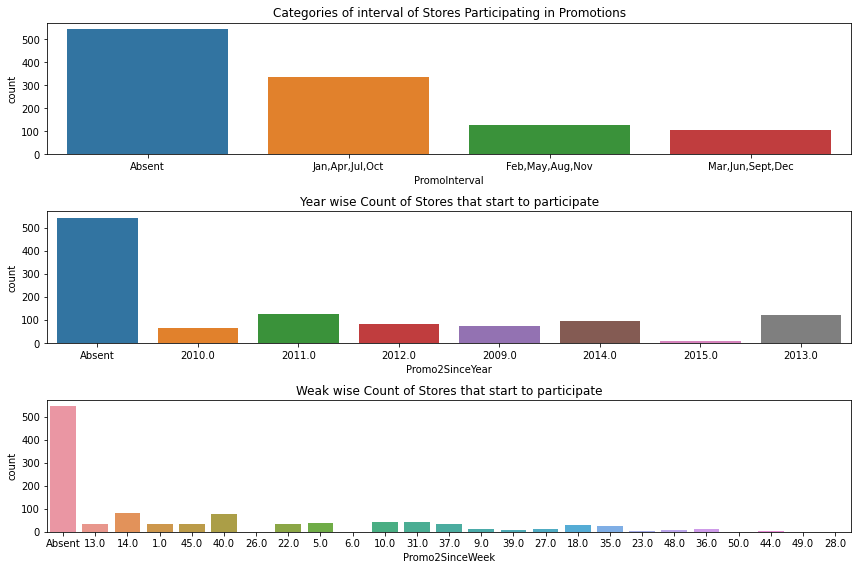

In [ ]:
# Plot Features : PromoInterval ,Promo2SinceYear ,Promo2SinceYear

fig, (axis1,axis2,axis3) = plt.subplots(3,1,figsize=(12,8))

sns.countplot(x='PromoInterval', data=store, ax =  axis1)
axis1.set_title('Categories of interval of Stores Participating in Promotions')

sns.countplot(x='Promo2SinceYear',data=store, ax = axis2)
axis2.set_title('Year wise Count of Stores that start to participate')

sns.countplot(x='Promo2SinceWeek',data=store, ax = axis3)
axis3.set_title('Weak wise Count of Stores that start to participate')

fig.tight_layout(pad = 1.0)

**Insights:**

- Above Count Plot Shows that Approciamately `~500` Records are absent in Each Feature. This Suggests that these `~500` Stores Do not Participate in Promotions Lets Check the Same using one `Count Plot` on Promo as well.

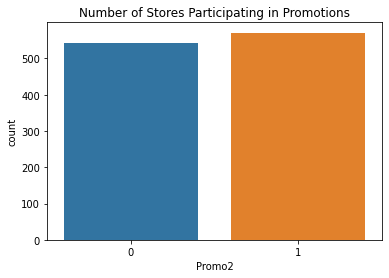

In [ ]:
plt.figsize = (15,10)
sns.countplot(x = 'Promo2', data = store)
plt.title('Number of Stores Participating in Promotions')
plt.show()

**Insights:**


- Above Count Plot Agree's to our previous asumptions that the `Missing Values are actually present in stores that do not participate in Promotions`.

In [ ]:
# Imputing the Missing Values for PromoInterval , Promo2SinceYear , Promo2SinceYear
store.Promo2SinceWeek.replace('Absent', 0, inplace = True)
store.Promo2SinceYear.replace('Absent', 0, inplace = True)
store.PromoInterval.replace('Absent', 0, inplace = True)

**Info About the Feature:**

- **CompetitionDistance:** describes thedistance in meters to the nearest competitor store

- **CompetitionOpenSince[Month/Year]:** gives the approximate year and month of the time the nearest competitor was opened

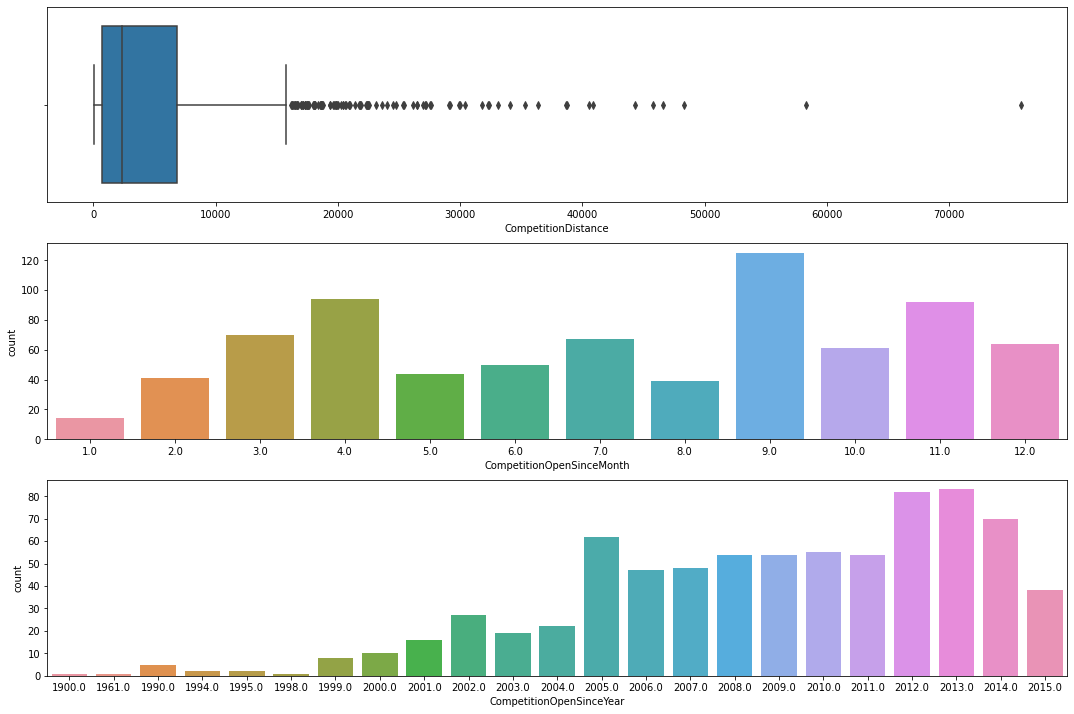

In [ ]:
### Feature : CompetitionDistance, CompetitionOpenSinceMonth, CompetitionOpenSinceYear
fig, (axis1,axis2,axis3) = plt.subplots(3,1,figsize=(15,10))

sns.boxplot(x = 'CompetitionDistance', data = store, ax = axis1)
sns.countplot(x = 'CompetitionOpenSinceMonth', data = store, ax = axis2)
sns.countplot(x = 'CompetitionOpenSinceYear',data = store, ax = axis3)

fig.tight_layout(pad = 1.0)

In [ ]:
# Imputing missing values
store.CompetitionDistance.fillna('Absent', inplace = True)
store.CompetitionOpenSinceMonth.fillna('Absent', inplace = True)
store.CompetitionOpenSinceYear.fillna('Absent', inplace = True)

In [ ]:
store[['Store','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']].head()

Store CompetitionDistance CompetitionOpenSinceMonth  \
0         1              1270.0                       9.0   
1         2               570.0                      11.0   
2         3             14130.0                      12.0   
3         4               620.0                       9.0   
4         5             29910.0                       4.0   
...     ...                 ...                       ...   
1110   1111              1900.0                       6.0   
1111   1112              1880.0                       4.0   
1112   1113              9260.0                    Absent   
1113   1114               870.0                    Absent   
1114   1115              5350.0                    Absent   

     CompetitionOpenSinceYear  
0                      2008.0  
1                      2007.0  
2                      2006.0  
3                      2009.0  
4                      2015.0  
...                       ...  
1110                   2014.0  
1111                   2006.0  
1112                   Absent  
1113                   Absent  
1114                   Absent  

[1115 rows x 4 columns]

In [ ]:
store[store.CompetitionDistance == 'Absent'][['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear']]

Store CompetitionDistance CompetitionOpenSinceMonth  \
290    291              Absent                    Absent   
621    622              Absent                    Absent   
878    879              Absent                    Absent   

    CompetitionOpenSinceYear  
290                   Absent  
621                   Absent  
878                   Absent

In [ ]:
print('- Store Dataset where ComprtionDistance is NaN/Absent {}'.format(len(store[store.CompetitionDistance == 'Absent'])))

- Store Dataset where ComprtionDistance is NaN/Absent 3


In [ ]:
print('- Store Dataset where ComprtionDistance is not NaN/Absent {}'.format(len(store[store.CompetitionDistance != 'Absent'])))

- Store Dataset where ComprtionDistance is not NaN/Absent 1112


**Insights:**


- Here Clearly we can see that there are 2 clusters:
  1. when Competition Distance is Absent, CompetitionOpenSinceMonth and CompetitionOpenSinceYear is also Absent.
  2. when Competition Distance is not Absent, CompetitionOpenSinceMonth and CompetitionOpenSinceYear is also Absent.

- Considering the Case 1 it's genuine to assume there is no Nearby Competion hence, We Can Impute them with 0 or Drop them as in our Scope we need to Process For 9 Stores that are : 1,3,8,9,13,25,29,31 and 46.

In [ ]:
store = store[store.CompetitionDistance != 'Absent']

In [ ]:
store.shape

(1112, 10)

In [ ]:
# Need to Impute the CompetitionOpenSinceMonth & CompetitionOpenSinceYear 
store[['Store','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear']].sort_values(by='CompetitionDistance', ascending=True)

Store CompetitionDistance CompetitionOpenSinceMonth  \
515     516                20.0                    Absent   
881     882                30.0                       4.0   
1007   1008                30.0                       9.0   
620     621                30.0                       7.0   
987     988                30.0                      11.0   
...     ...                 ...                       ...   
746     747             45740.0                       8.0   
109     110             46590.0                       4.0   
800     801             48330.0                       4.0   
121     122             58260.0                       4.0   
452     453             75860.0                    Absent   

     CompetitionOpenSinceYear  
515                    Absent  
881                    2013.0  
1007                   2010.0  
620                    2002.0  
987                    2012.0  
...                       ...  
746                    2008.0  
109                    2013.0  
800                    2013.0  
121                    2013.0  
452                    Absent  

[1112 rows x 4 columns]

##### Using Naive method to Impute Missing Values 

In [ ]:
print('- Median Value for CompetitionOpenSinceMonth : {} '.format(store[store['CompetitionOpenSinceMonth'] != 'Absent']['CompetitionOpenSinceMonth'].median()))
print('- Median Value for CompetitionOpenSinceYear : {}  '.format(store[store['CompetitionOpenSinceYear'] != 'Absent']['CompetitionOpenSinceYear'].median()))

- Median Value for CompetitionOpenSinceMonth : 8.0 
- Median Value for CompetitionOpenSinceYear : 2010.0  


In [ ]:
store.CompetitionOpenSinceMonth.replace('Absent', 8.0, inplace = True)
store.CompetitionOpenSinceYear.replace('Absent', 2010.0, inplace = True)

In [ ]:
# checking if any more missing values present or not
store.isnull().values.sum()

0

**Note:**

- Since the company is just embarking on this project, the scope has been kept to `nine key stores` across Europe. The stores are key for the company keeping in mind the revenue and historical prestige associated with them. These stores are numbered - `1,3,8,9,13,25,29,31 and 46`.

In [ ]:
key_train = train[train['Store'].isin([1, 3, 8, 9, 13, 25, 29, 31, 46])]
print('- Shape of the Train Dataset with Key Stores is {}'.format(key_train.shape))
key_store = store[store['Store'].isin([1, 3, 8, 9, 13, 25, 29, 31, 46])]
print('- Shape of the Store Dataset with Key Stores is {}'.format(key_store.shape))

- Shape of the Train Dataset with Key Stores is (8110, 9)
- Shape of the Store Dataset with Key Stores is (9, 10)


In [ ]:
# Joining The Train/Sales and Store Dataset
dataset = pd.merge(key_train, key_store, on = 'Store')

In [ ]:
dataset.head()

Store  DayOfWeek        Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5  2015-07-31   5263        555     1      1            0   
1      1          4  2015-07-30   5020        546     1      1            0   
2      1          3  2015-07-29   4782        523     1      1            0   
3      1          2  2015-07-28   5011        560     1      1            0   
4      1          1  2015-07-27   6102        612     1      1            0   

   SchoolHoliday StoreType Assortment CompetitionDistance  \
0              1         c          a              1270.0   
1              1         c          a              1270.0   
2              1         c          a              1270.0   
3              1         c          a              1270.0   
4              1         c          a              1270.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1                        9.0                    2008.0       0   
2                        9.0                    2008.0       0   
3                        9.0                    2008.0       0   
4                        9.0                    2008.0       0   

   Promo2SinceWeek  Promo2SinceYear PromoInterval  
0              0.0              0.0             0  
1              0.0              0.0             0  
2              0.0              0.0             0  
3              0.0              0.0             0  
4              0.0              0.0             0

#### Univariate Exploratory Data Analysis 

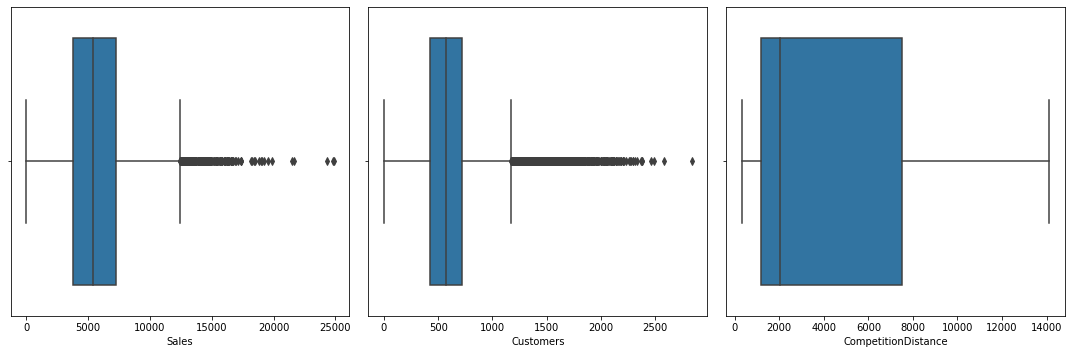

In [ ]:
fig, (axis1, axis2, axis3) = plt.subplots(1,3,figsize=(15,5))

sns.boxplot(x = 'Sales',data=dataset, ax = axis1)
sns.boxplot(x = 'Customers',data=dataset, ax = axis2)
sns.boxplot(x = 'CompetitionDistance', data = dataset, ax = axis3)

fig.tight_layout(pad = 1.0)

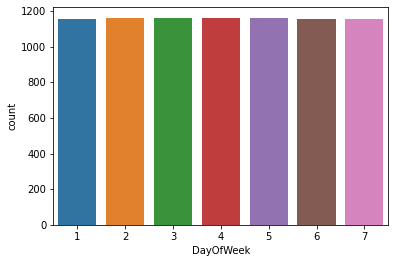

In [ ]:
sns.countplot(x = 'DayOfWeek', data = dataset)

In [ ]:
# StateHoliday column had 0 in numeric and 0 in categoric
set(dataset['StateHoliday'])
# lets fix it 
dataset['StateHoliday'].replace(0, '0', inplace = True)

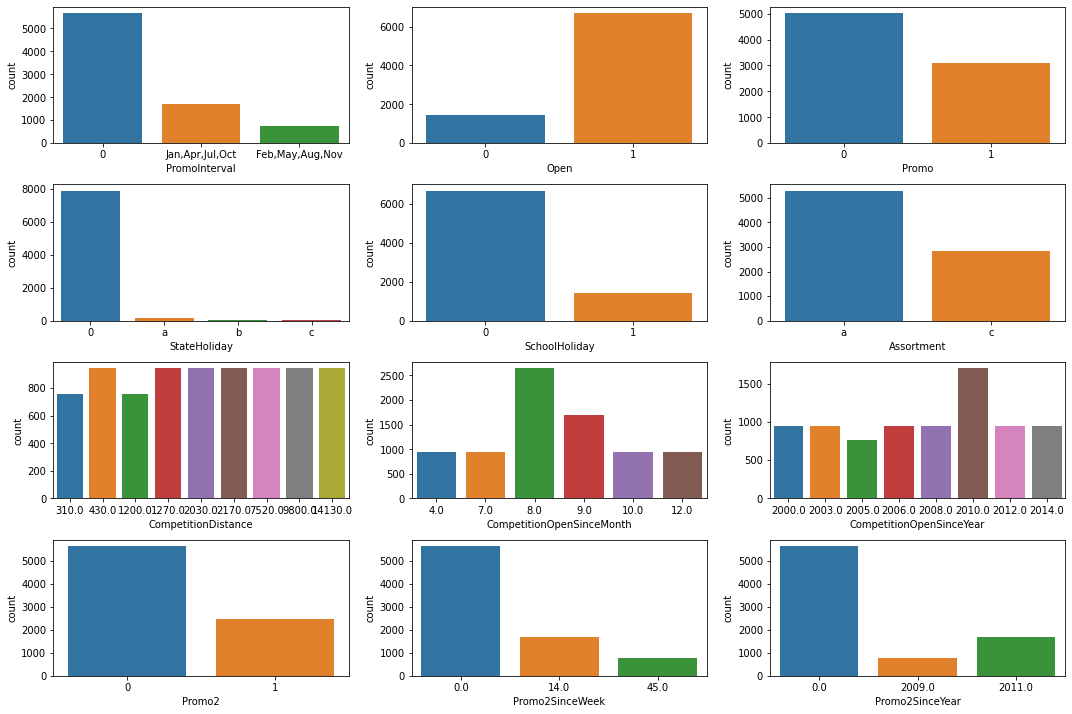

In [ ]:
fig, ((axis1,axis2,axis3),(axis4,axis5,axis6),(axis7,axis8,axis9),(axis10,axis11,axis12)) = plt.subplots(4, 3, figsize = (15,10))

sns.countplot(x = 'PromoInterval', data = dataset, ax = axis1)
sns.countplot(x = 'Open', data = dataset, ax = axis2)
sns.countplot(x = 'Promo', data = dataset, ax = axis3)

sns.countplot(x = 'StateHoliday', data = dataset, ax = axis4)
sns.countplot(x = 'SchoolHoliday', data = dataset, ax = axis5)
sns.countplot(x='Assortment',data=dataset, ax = axis6)

sns.countplot(x = 'CompetitionDistance', data = dataset, ax = axis7)
sns.countplot(x = 'CompetitionOpenSinceMonth', data = dataset, ax = axis8)
sns.countplot(x = 'CompetitionOpenSinceYear', data = dataset, ax = axis9)

sns.countplot(x = 'Promo2', data = dataset, ax = axis10)
sns.countplot(x = 'Promo2SinceWeek', data = dataset, ax = axis11)
sns.countplot(x = 'Promo2SinceYear', data = dataset, ax = axis12)

fig.tight_layout(pad=1.0)

**Insights:**


  - `Holiday` Features are Highky towards 0 category suggesting a Normal Function.
  - `Sales` and `Customers` seem to have `Outliers`. We will have to Treat the Outliers by removing them from our training set.
  - `Highest Competitors` opened there Drug Store in the Year `2010`
  - `Promo2` and its Attribute Suggest that Majority Stores `do not prefer` `opting` for it.
  - `8 & 9 Months` being the `Highest Category` that shows that competition has opened the store

#### Identifying Outliers

In [ ]:
# Lets Calculate the 99th Percentile.

sales_threshold=dataset['Sales'].quantile(.99)
customers_threshold=dataset['Customers'].quantile(.99)

print('- 99th Percentile Sales Threshold {}'.format(sales_threshold))
print('- 99th Percentile Customers Threshold {}'.format(customers_threshold))

- 99th Percentile Sales Threshold 14810.279999999999
- 99th Percentile Customers Threshold 1929.9099999999999


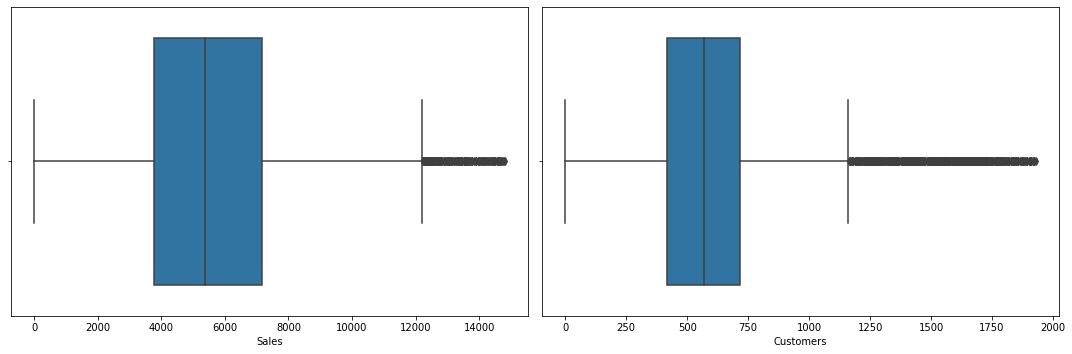

In [ ]:
# Visualization
fig, (axis1,axis2) = plt.subplots(1, 2, figsize = (15,5))

sns.boxplot(x = 'Sales', data = dataset[dataset['Sales'] <= sales_threshold], ax = axis1)
sns.boxplot(x = 'Customers', data = dataset[dataset['Customers'] <= customers_threshold], ax = axis2)
fig.tight_layout(pad=1.0)

**Note:** 
- Outlier Treatment Needs to be Done at Store Level to Better Results and the Above is just to get the inference and insights.

#### Bivarate Exploratory Data Analysis 

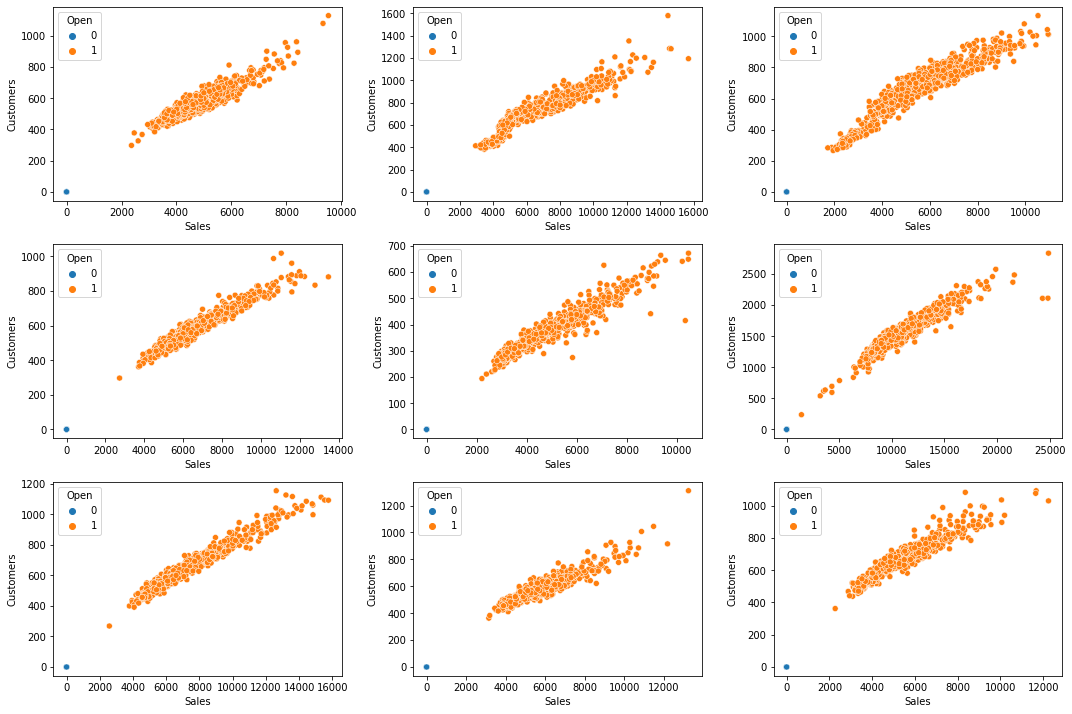

In [ ]:
fig, ((axis1,axis2,axis3),(axis4,axis5,axis6),(axis7,axis8,axis9)) = plt.subplots(3,3,figsize=(15,10))

sns.scatterplot(x='Sales', y='Customers', hue='Open', data = dataset[dataset['Store'] == 1], ax = axis1)
sns.scatterplot(x='Sales', y='Customers', hue='Open', data = dataset[dataset['Store'] == 3], ax = axis2)
sns.scatterplot(x='Sales', y='Customers', hue='Open', data = dataset[dataset['Store'] == 8], ax = axis3)
sns.scatterplot(x='Sales', y='Customers', hue='Open', data = dataset[dataset['Store'] == 9], ax = axis4)
sns.scatterplot(x='Sales', y='Customers', hue='Open', data = dataset[dataset['Store'] == 13], ax = axis5)
sns.scatterplot(x='Sales', y='Customers', hue='Open', data = dataset[dataset['Store'] == 25], ax = axis6)
sns.scatterplot(x='Sales', y='Customers', hue='Open', data = dataset[dataset['Store'] == 29], ax = axis7)
sns.scatterplot(x='Sales', y='Customers', hue='Open', data = dataset[dataset['Store'] == 31], ax = axis8)
sns.scatterplot(x='Sales', y='Customers', hue='Open', data = dataset[dataset['Store'] == 46], ax = axis9)

fig.tight_layout(pad=1.0)

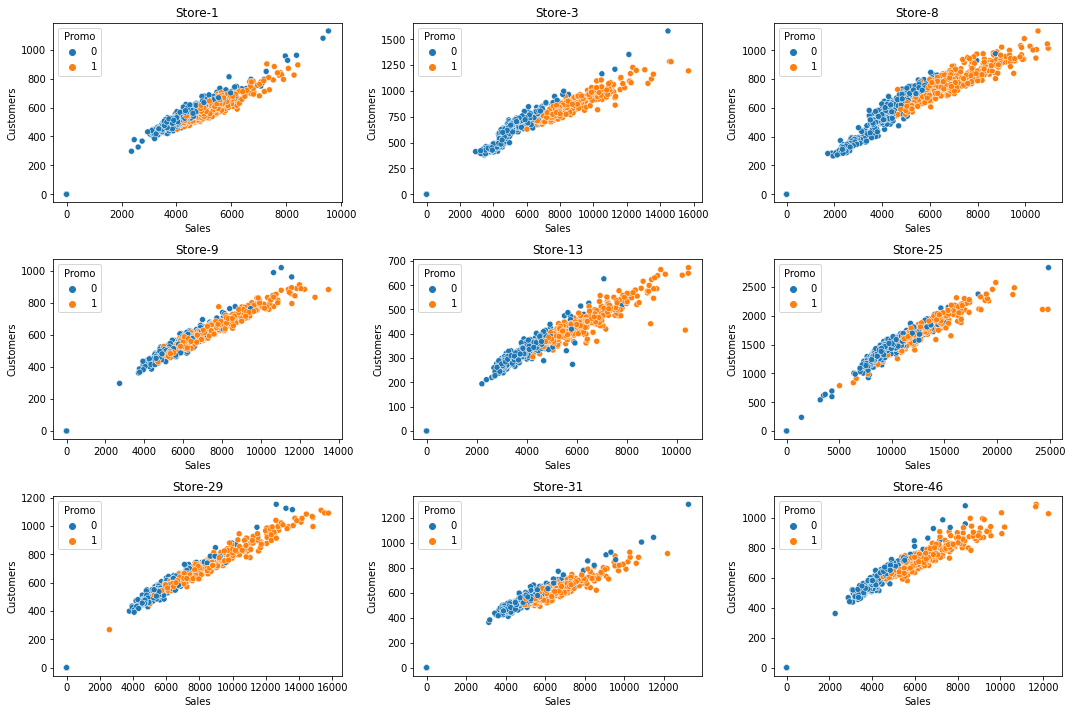

In [ ]:
fig, ((axis1,axis2,axis3),(axis4,axis5,axis6),(axis7,axis8,axis9)) = plt.subplots(3,3,figsize=(15,10))

sns.scatterplot(x='Sales',y='Customers', hue='Promo', data=dataset[dataset['Store']==1], ax=axis1)
axis1.set_title('Store-1')
sns.scatterplot(x='Sales',y='Customers', hue='Promo', data=dataset[dataset['Store']==3], ax=axis2)
axis2.set_title('Store-3') 
sns.scatterplot(x='Sales',y='Customers', hue='Promo', data=dataset[dataset['Store']==8], ax=axis3)
axis3.set_title('Store-8')
sns.scatterplot(x='Sales',y='Customers', hue='Promo', data=dataset[dataset['Store']==9], ax=axis4)
axis4.set_title('Store-9')
sns.scatterplot(x='Sales',y='Customers', hue='Promo', data=dataset[dataset['Store']==13], ax=axis5)
axis5.set_title('Store-13')
sns.scatterplot(x='Sales',y='Customers', hue='Promo', data=dataset[dataset['Store']==25], ax=axis6)
axis6.set_title('Store-25')
sns.scatterplot(x='Sales',y='Customers', hue='Promo', data=dataset[dataset['Store']==29], ax=axis7)
axis7.set_title('Store-29')
sns.scatterplot(x='Sales',y='Customers', hue='Promo', data=dataset[dataset['Store']==31], ax=axis8)
axis8.set_title('Store-31')
sns.scatterplot(x='Sales',y='Customers', hue='Promo', data=dataset[dataset['Store']==46], ax=axis9)
axis9.set_title('Store-46')

fig.tight_layout(pad=1.0)

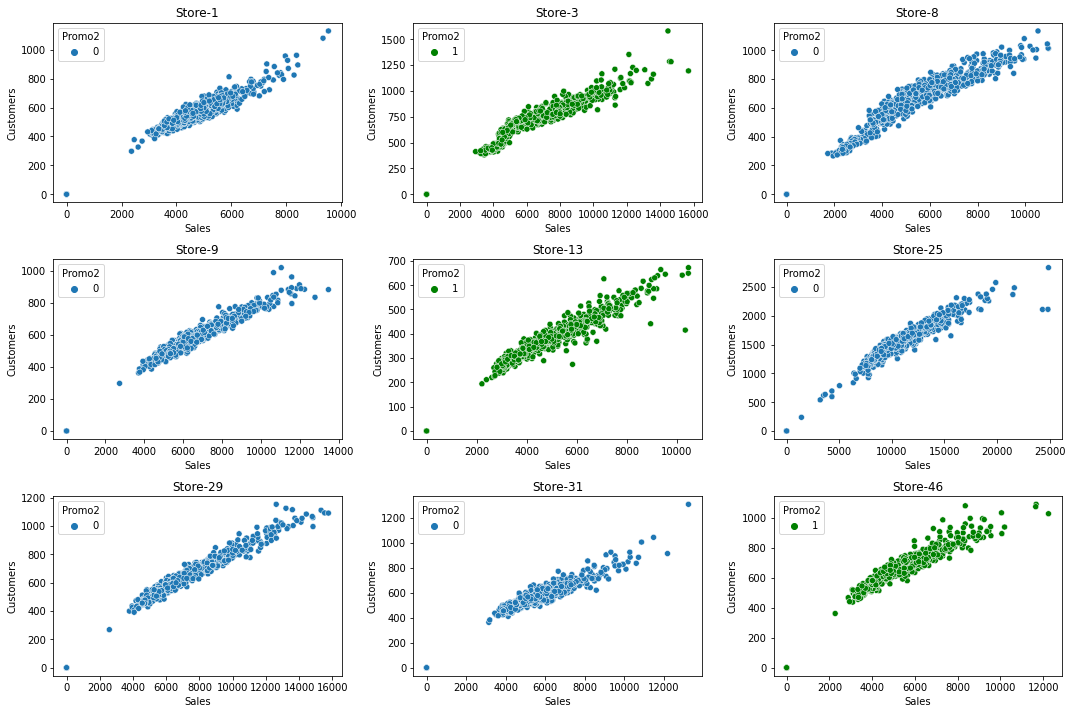

In [ ]:
fig, ((axis1,axis2,axis3),(axis4,axis5,axis6),(axis7,axis8,axis9)) = plt.subplots(3,3,figsize=(15,10))

sns.scatterplot(x='Sales',y='Customers',hue='Promo2',data=dataset[dataset['Store']==1],ax=axis1)
axis1.set_title('Store-1')
sns.scatterplot(x='Sales',y='Customers',hue='Promo2',data=dataset[dataset['Store']==3],palette=['green'],ax=axis2)
axis2.set_title('Store-3')
sns.scatterplot(x='Sales',y='Customers',hue='Promo2',data=dataset[dataset['Store']==8],ax=axis3)
axis3.set_title('Store-8')
sns.scatterplot(x='Sales',y='Customers',hue='Promo2',data=dataset[dataset['Store']==9],ax=axis4)
axis4.set_title('Store-9')
sns.scatterplot(x='Sales',y='Customers',hue='Promo2',data=dataset[dataset['Store']==13],palette=['green'],ax=axis5)
axis5.set_title('Store-13')
sns.scatterplot(x='Sales',y='Customers',hue='Promo2',data=dataset[dataset['Store']==25],ax=axis6)
axis6.set_title('Store-25')
sns.scatterplot(x='Sales',y='Customers',hue='Promo2',data=dataset[dataset['Store']==29],ax=axis7)
axis7.set_title('Store-29')
sns.scatterplot(x='Sales',y='Customers',hue='Promo2',data=dataset[dataset['Store']==31],ax=axis8)
axis8.set_title('Store-31')
sns.scatterplot(x='Sales',y='Customers',hue='Promo2',data=dataset[dataset['Store']==46],palette=['green'],ax=axis9)
axis9.set_title('Store-46')

fig.tight_layout(pad=1.0)

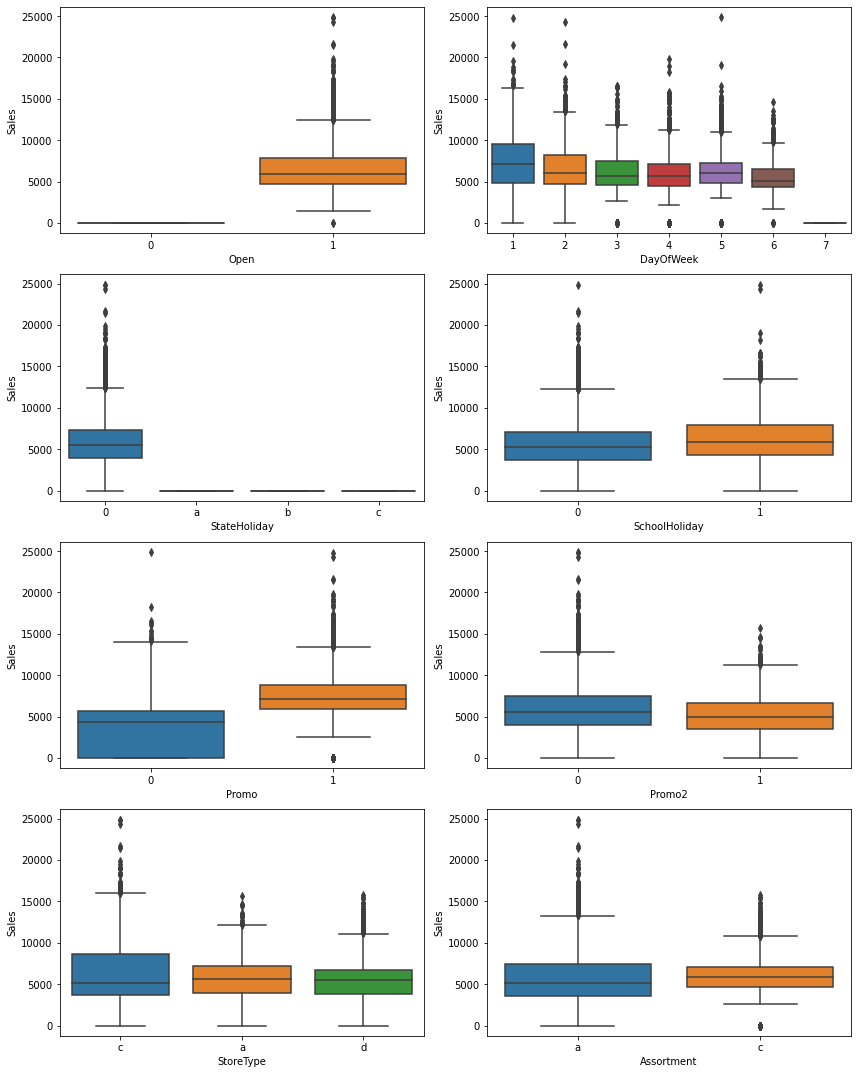

In [ ]:
fig, ((axis1,axis2),(axis3,axis4),(axis5,axis6),(axis7,axis8)) = plt.subplots(4,2,figsize=(12,15))

sns.boxplot(y = 'Sales', x = 'Open', data=dataset, ax = axis1)
sns.boxplot(y = 'Sales', x = 'DayOfWeek', data=dataset, ax = axis2)
sns.boxplot(y = 'Sales', x = 'StateHoliday', data=dataset, ax = axis3)
sns.boxplot(y = 'Sales', x = 'SchoolHoliday', data=dataset, ax = axis4)
sns.boxplot(y = 'Sales', x = 'Promo', data=dataset, ax = axis5)
sns.boxplot(y = 'Sales', x = 'Promo2', data=dataset, ax = axis6)
sns.boxplot(y = 'Sales', x = 'StoreType', data=dataset, ax = axis7)
sns.boxplot(y = 'Sales', x = 'Assortment', data=dataset, ax = axis8)

fig.tight_layout(pad=1.0)

**Insights:**


**Significant Columns:**

- `SchoolHoliday` , and `Promo` Seem to Contribute majorly to Sales.

**Insignificant Columns:**

- As we See in Box Plot and Scatter Plot the Sales happen only when the Stores are open hence keeping this feature is not of much importance to us. Most probably Sunday that is the 7th day of Week.
- Promo2 on other hand does seem to do much contribution as a whole to sales. As overal Sales feature shows similar/Nearby Mean for Promo2. Hence droping all `atributes realted to promo 2` will help.
- In addition `Promo2, StoreType & Assortment` shows similar characterisitics for its contribution to Sales i.e the mean value in Box Plot remains same almost.
- When State Holiday is  0 seems then sales is there but then other categories do not contribute the sales as much. hence this columns seems to be biased.
- Hence Lets Drop these Columns


In [ ]:
dataset.drop(columns = ['Open','StateHoliday','StoreType','Assortment','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval'], inplace=True)

In [ ]:
dataset['Date'] = pd.to_datetime(dataset['Date'], format='%Y-%m-%d')
dataset = dataset.sort_values(by=['Date'])

In [ ]:
dataset.head()

Store  DayOfWeek       Date  Sales  Customers  Promo  SchoolHoliday  \
8109     46          2 2013-01-01      0          0      0              1   
5467     25          2 2013-01-01      0          0      0              1   
2825      8          2 2013-01-01      0          0      0              1   
4525     13          2 2013-01-01      0          0      0              1   
3767      9          2 2013-01-01      0          0      0              1   

     CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  
8109              1200.0                        9.0                    2005.0  
5467               430.0                        4.0                    2003.0  
2825              7520.0                       10.0                    2014.0  
4525               310.0                        8.0                    2010.0  
3767              2030.0                        8.0                    2000.0

Text(0.5, 1.0, 'Corelation Matrix')

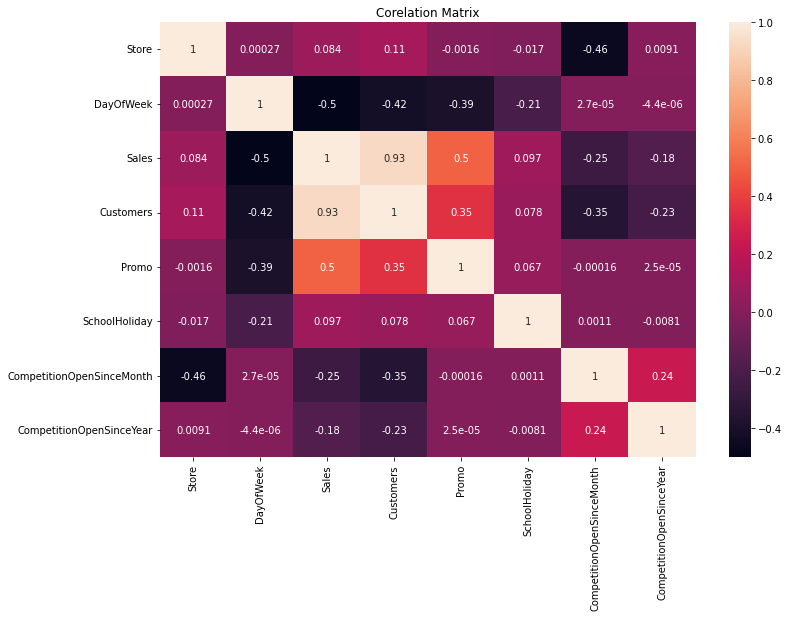

In [ ]:
# lets check co relation 
plt.figure(figsize = (12, 8))
sns.heatmap(dataset.corr(), annot=True)
plt.title('Corelation Matrix')

In [ ]:
# corelation matrix
corr_data = dataset.corr().abs().unstack().sort_values(ascending = False).to_frame().reset_index()
corr_data[(corr_data['level_0']=='Sales') & (corr_data[0]>=0.5)]

level_0    level_1         0
6    Sales      Sales  1.000000
8    Sales  Customers  0.928872
11   Sales      Promo  0.504876
13   Sales  DayOfWeek  0.500999

In [ ]:
# Insignificant Columns
dataset.drop(columns = ['SchoolHoliday','CompetitionDistance','CompetitionOpenSinceMonth','CompetitionOpenSinceYear'], inplace=True) #'SchoolHoliday'

In [ ]:
dataset.head()

Store  DayOfWeek       Date  Sales  Customers  Promo
8109     46          2 2013-01-01      0          0      0
5467     25          2 2013-01-01      0          0      0
2825      8          2 2013-01-01      0          0      0
4525     13          2 2013-01-01      0          0      0
3767      9          2 2013-01-01      0          0      0

In [ ]:
dataset.set_index('Date', inplace=True)

#### Test for Casuality

In [ ]:
causality_sales = grangercausalitytests(dataset[['Sales','Customers']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=629.6984, p=0.0000  , df_denom=8106, df_num=1
ssr based chi2 test:   chi2=629.9315, p=0.0000  , df=1
likelihood ratio test: chi2=606.6616, p=0.0000  , df=1
parameter F test:         F=629.6984, p=0.0000  , df_denom=8106, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=261.8936, p=0.0000  , df_denom=8103, df_num=2
ssr based chi2 test:   chi2=524.1105, p=0.0000  , df=2
likelihood ratio test: chi2=507.8673, p=0.0000  , df=2
parameter F test:         F=261.8936, p=0.0000  , df_denom=8103, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=167.4502, p=0.0000  , df_denom=8100, df_num=3
ssr based chi2 test:   chi2=502.7846, p=0.0000  , df=3
likelihood ratio test: chi2=487.8097, p=0.0000  , df=3
parameter F test:         F=167.4502, p=0.0000  , df_denom=8100, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=124.0579, p=0.

In [ ]:
causality_customers = grangercausalitytests(dataset[['Customers','Sales']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1164.2550, p=0.0000  , df_denom=8106, df_num=1
ssr based chi2 test:   chi2=1164.6858, p=0.0000  , df=1
likelihood ratio test: chi2=1088.2793, p=0.0000  , df=1
parameter F test:         F=1164.2550, p=0.0000  , df_denom=8106, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=500.7182, p=0.0000  , df_denom=8103, df_num=2
ssr based chi2 test:   chi2=1002.0543, p=0.0000  , df=2
likelihood ratio test: chi2=944.8045, p=0.0000  , df=2
parameter F test:         F=500.7182, p=0.0000  , df_denom=8103, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=306.2648, p=0.0000  , df_denom=8100, df_num=3
ssr based chi2 test:   chi2=919.5885, p=0.0000  , df=3
likelihood ratio test: chi2=871.0697, p=0.0000  , df=3
parameter F test:         F=306.2648, p=0.0000  , df_denom=8100, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=219.6943,

**Insight:**

- Since all the tests signify casuality at significant level 0.05, it means `casuality exists` between `sales & customer`.

#### Functions for Statisical Test

- We'll create a function for statistical checks on dataset.
- It'll make code reusable & reduce time & effort to write them again & again.

In [ ]:
# Johanson Cointegration Test
def johanson_coint_test(dataset):
    output=pd.DataFrame([dataset.lr1,dataset.lr2],index=['max_eig_stat','trace_stat'])
    print(output.T,'\n')
    print('- Crtical Values: (90%,95%,99%) of max_eig_stat :\n',dataset.cvm,'\n' )
    print('- Crtical Values: (90%,95%,99%) of trace_stat :\n',dataset.cvt,'\n' )
    
def coint_rank(dataset):
    rank = select_coint_rank(dataset,-1,0).rank
    print("- Rank of the Dataset for Features {} & {} is {}. ".format(dataset.columns[0],dataset.columns[1],rank))
    if rank == 2:
        print("- w1 and w2 are unique that happens when both Features are statioanry & not cointegrated we can build a VAR/ VARMAX model as it is.")
    elif rank == 1:
        print("- w1 can be expressed in terms of w2 both Features are not requered only 1 is enough Hence, they are cointegrated we can build a VAR\VARMAX model as it is.")
    else:
         print("- No cointegrating vector exists both Features are not cointegrated we cannot build a VAR\VARMAX model as it is.")

# Stationarity Test
def stationaryTest(dataset,store):
# We'll use Augumented Dickey Fuller Test  
    for target in ['Sales']:#,'Customers']:
        adf_test_Sales = adfuller(dataset[target])

        print('- ADF Test Results for "{}" in Store {} :'.format(target,store))
        print('- ADF Statistic: %f' % adf_test_Sales[0])
        print('- Critical Values @ 0.05: %.2f' % adf_test_Sales[4]['5%'])
        print('- p-value: %f' % adf_test_Sales[1])

        if adf_test_Sales[1] <= 0.05 :
            print('- ADF Test Suggests :Null Hypothesis (H0): The series is stationary')
        else :
            print('- ADF Test Suggests :Alternate Hypothesis (H1): The series is not stationary')
            
        print('\n')

#### Functions for ACF & PACF Plots

In [ ]:
# function for plotting AutoCorrelation & Partial AutoCorelation function
def correlationlPlot(feature, featureValues):
    fig, (axis1, axis2) = plt.subplots(2,1, figsize=(20,10))

    plot_acf(featureValues, lags = 75, ax = axis1)
    axis1.set_title('Auto Correlation Plot for {}'.format(feature))
    plot_pacf(featureValues, lags = 75, ax = axis2)
    axis2.set_title('Partial Auto Correlation Plot for {}'.format(feature))
    
    plt.show()

**Stationarity Test** 
  - If a time series is stationary, its statistical properties like `mean, variance, and covariance` will be the same throughout the series, irrespective of the time at which you observe them. 
  - To Check a Time Series is Stationary or Not we can do using `ADF-Test` 
  - if p value > 0.05 => Null Hypothesis (H0): The series is `stationary`
or if p value <= 0.05 => Alternate Hypothesis (H1): The series is `non-stationary`
  - if the Series is `non-Stationary`, we can `Diffference` the data upto its 2nd or 3rd Order or can do `Power Transformation` such as `Box-Cox Transformations`.

#### Plotting the Aggregated Dataset

In [ ]:
aggregated_dataset = dataset.groupby('Date').agg({'Sales': 'mean',
                                                  'Customers':'mean'})

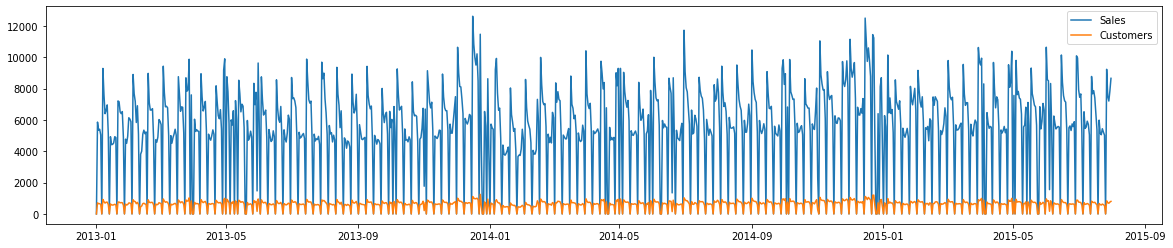

In [ ]:
plt.figure(figsize = (20,4)) 
plt.plot(aggregated_dataset['Sales'], label = 'Sales')
plt.plot(aggregated_dataset['Customers'], label = 'Customers')
plt.legend(loc = 'best')
plt.show()

#### Checking Rank of DataSet

In [ ]:
# Johanson Cointegration Test 
independent_columns = list(dataset.columns)
independent_columns.remove('Sales')
for element in independent_columns:
    coint_rank(dataset[['Sales',element]])
    print(' ')

- Rank of the Dataset for Features Sales & Store is 2. 
- w1 and w2 are unique that happens when both Features are statioanry & not cointegrated we can build a VAR/ VARMAX model as it is.
 
- Rank of the Dataset for Features Sales & DayOfWeek is 2. 
- w1 and w2 are unique that happens when both Features are statioanry & not cointegrated we can build a VAR/ VARMAX model as it is.
 
- Rank of the Dataset for Features Sales & Customers is 2. 
- w1 and w2 are unique that happens when both Features are statioanry & not cointegrated we can build a VAR/ VARMAX model as it is.
 
- Rank of the Dataset for Features Sales & Promo is 2. 
- w1 and w2 are unique that happens when both Features are statioanry & not cointegrated we can build a VAR/ VARMAX model as it is.
 


#### Impact of the number of customers on sales


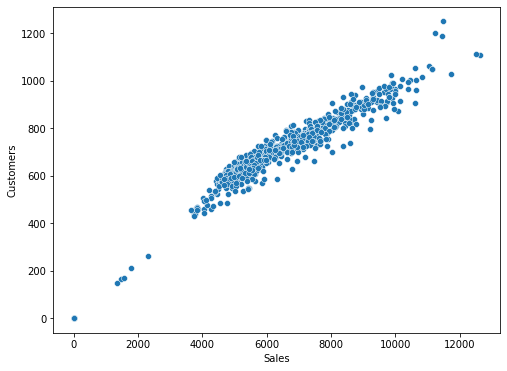

In [ ]:
plt.figure(figsize = (8,6)) 
sns.scatterplot(x = 'Sales', y = 'Customers', data = aggregated_dataset, palette = ['green'])
plt.show()

- Sales is `Linearly Dependent` on Customers and Shows a `Linear Raising Relationship` 

In [ ]:
dataset.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Promo'], dtype='object')

#### Impact of promo and promo2 variables on sales

- From previous box plot:

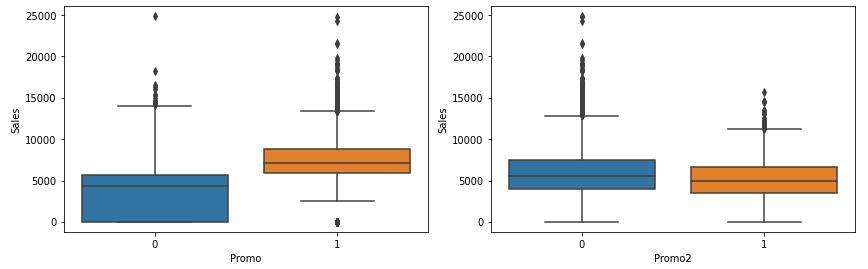

- As we have seen Customers Play an Important Role in Sales, and Promo Attracts Customers that would help in sale thus more revenue. 
- But it was Found that Promo contributed more for the Sales than Promo2. Also with and Without Promo2 the Average Sales were almost same.
- Further only Store 3 , 13 and 46 Opted for it.

- Hence, Promo2 being not that much useful, makes us understand that its nearby variables such as Promo2SinceWeek and Year wont have much impact.

#### Functions for building model

In [ ]:
# ARIMA
def arimaFunction(train_dataset,test_dataset,order):

    # Train Code
    endog = train_dataset[['Sales']].astype(float)
    arima_model = ARIMA(endog, order=order)
    arima_model_fit = arima_model.fit()
    print(arima_model_fit.summary())
    
    #Forecast Code
    arima_sales = arima_model_fit.predict(start=test_dataset.index.min(),end=test_dataset.index.max())
    arima_forecast = pd.DataFrame(arima_sales, index=test_dataset.index, columns=['Sales'])
    test_dataset['ARIMAForecastedSales'] = arima_forecast.Sales.round(2)
    
    return test_dataset

# ARIMAX    
def arimaxFunction(train_dataset,test_dataset,order):
  
    # Train Code
    exog = train_dataset[['Customers','Promo','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5',
                          'DayOfWeek_6','DayOfWeek_7']].astype(float)
    endog = train_dataset[['Sales']].astype(float)
    arimax_model = ARIMA(endog = endog, exog = exog, order = order)
    arimax_model_fit = arimax_model.fit()
    print(arimax_model_fit.summary())
    
    #Forecast Code
    exog_test=test_dataset[['Customers','Promo','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5',
                          'DayOfWeek_6','DayOfWeek_7']].astype(float)
    arimax_sales = arimax_model_fit.predict(start = test_dataset.index.min(), end = test_dataset.index.max(), exog = exog_test)
    arimax_forecast = pd.DataFrame(arimax_sales, index=test_dataset.index, columns=['Sales'])
    test_dataset['ARIMAXForecastedSales'] = arimax_forecast.Sales.round(2)
    
    return test_dataset

In [ ]:
# SARIMA    
def sarimaFunction(train_dataset,test_dataset,order,seasonal_order):
  
    # Train Code
    endog = train_dataset[['Sales']].astype(float)
    sarima_model = SARIMAX(endog = endog, order = order, seasonal_order = seasonal_order)
    sarima_model_fit = sarima_model.fit()
    print(sarima_model_fit.summary())

    #Forecast Code
    sarima_sales = sarima_model_fit.predict(start = test_dataset.index.min(), end = test_dataset.index.max())
    sarima_forecast = pd.DataFrame(sarima_sales, index = test_dataset.index, columns = ['Sales'])
    test_dataset['SARIMAForecastedSales'] = sarima_forecast.Sales.round(2)
    
    return test_dataset

# SARIMAX    
def sarimaxFunction(train_dataset,test_dataset,order,seasonal_order):
    
    # Train Code
    exog = train_dataset[['Customers','Promo','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5',
                          'DayOfWeek_6','DayOfWeek_7']].astype(float)
    endog = train_dataset[['Sales']].astype(float)
    sarimax_model = SARIMAX(endog = endog, order = order, seasonal_order = seasonal_order, exog = exog)
    sarimax_model_fit = sarimax_model.fit()
    print(sarimax_model_fit.summary())

    #Forecast Code
    test_exog = test_dataset[['Customers','Promo','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5',
                          'DayOfWeek_6','DayOfWeek_7']].astype(float)
    sarimax_sales = sarimax_model_fit.predict(start=test_dataset.index.min(),end=test_dataset.index.max(),exog=test_exog)
    sarimax_forecast = pd.DataFrame(sarimax_sales, index=test_dataset.index, columns=['Sales'])
    test_dataset['SARIMAXForecastedSales']=sarimax_forecast.Sales.round(2)
    
    return test_dataset

In [ ]:
# VAR    
def varFunction(train_dataset,test_dataset, p):

    exog = train_dataset[['Promo','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
    var_mod = sm.tsa.VAR(train_dataset[['Sales','Customers']], exog = exog)
    res = var_mod.select_order(maxlags = 30)
    print(res.summary())
    
    var_model_final = var_mod.fit(p)
    print(var_model_final.summary())
    
    # Get the lag order
    lag_order = var_model_final.k_ar
    forecast_input = train_dataset[['Sales','Customers']].values[-lag_order:]
    
    exog_test = test_dataset[['Promo','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
    var_sales = var_model_final.forecast(y = forecast_input, steps = 42, exog_future = exog_test)
    var_forecast = pd.DataFrame(var_sales, index = test_dataset.index, columns = ['Sales','Customers'])
    test_dataset['VARForecastedSales'] = var_forecast.Sales.round(2)
    
    return test_dataset

# VARMAX
def varmaxFunction(train_dataset,test_dataset,order):
  
    # Train Code
    exog = train_dataset[['Promo','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5',
                          'DayOfWeek_6','DayOfWeek_7']].astype(float)
    varmax_model = sm.tsa.VARMAX(train_dataset[['Sales','Customers']], order=order,  exog=exog)
    varmax_model_fit = varmax_model.fit(maxiter=500, disp=False)
    print(varmax_model_fit.summary())
    
    exog_test = test_dataset[['Promo','DayOfWeek_2','DayOfWeek_3','DayOfWeek_4','DayOfWeek_5','DayOfWeek_6','DayOfWeek_7']].astype(float)
    varmax_fc = varmax_model_fit.predict(start = test_dataset.index.min(),end=test_dataset.index.max(),exog=exog_test)
    varmax_forecast = pd.DataFrame(varmax_fc, index=test_dataset.index, columns=['Sales','Customers'])
    test_dataset['VARMAXForecastedSales'] = varmax_forecast.Sales.round(2)
    
    return test_dataset

#### Functions for Plots & Evaluation

In [ ]:
# plotting result
def plot(test_dataset, modelName):
    plt.figure(figsize = (16,2)) 
    plt.plot(test_dataset['Sales'], label = 'Test')
    plt.plot(test_dataset[modelName + 'ForecastedSales'], label = modelName)
    plt.legend(loc = 'best')
    plt.title(modelName + 'Model')
    plt.show()

# evaluation
def scoringMetric(test_dataset, modelName, storeNo, results):
    rmse_sales = np.sqrt(mean_squared_error(test_dataset['Sales'], test_dataset[modelName+'ForecastedSales'])).round(2)
    mape_sales = np.round(np.mean((np.abs(test_dataset['Sales'] - test_dataset[modelName+'ForecastedSales'])/test_dataset['Sales']).replace(np.inf,0))*100,2).round(2)
    smape_sales = np.round(np.mean(np.abs(test_dataset['Sales'] - test_dataset[modelName+'ForecastedSales'])/((abs(test_dataset['Sales'])+abs(test_dataset[modelName+'ForecastedSales']))/2))*100,2)
    results = results.append({'Time Series Model' : modelName, 'Store' : storeNo, 'MAPE' : mape_sales,
                            'SMAPE' : smape_sales, 'RMSE' : rmse_sales}, 
                                                                        ignore_index = True)
    return results

In [ ]:
# DataFrame For Storing Results 
results = pd.DataFrame(columns = ['Time Series Model', 'Store', 'MAPE', 'SMAPE', 'RMSE'])
results

Empty DataFrame
Columns: [Time Series Model, Store, MAPE, SMAPE, RMSE]
Index: []

# Building Models for Stores:
- Store no: `1,3,8,9,13,25,29,31,46`

## Store-1:

In [ ]:
store_1 = dataset[dataset['Store'] == 1]
store_1.drop(columns=['Store'], inplace = True)
store_1.shape

(942, 4)

#### Handling Outlier

In [ ]:
# Saving the 99th Quantile Values as threshold
sales_threshold=store_1['Sales'].quantile(.99)
customers_threshold=store_1['Customers'].quantile(.99)

# Marking Outliers
store_1['sales_outlier']=np.where(store_1['Sales']<=sales_threshold,0,1)
store_1['customers_outlier']=np.where(store_1['Customers']<=customers_threshold,0,1)

# Removing Outliers
store_1_outlier=store_1[(store_1['sales_outlier'] != 1) & (store_1['customers_outlier'] != 1) ]
store_1_outlier.shape

(929, 6)

In [ ]:
# Lets Check the min and Max Date 
print('- First and Last Dates of Store 1 :',store_1_outlier.index.min() ,'and' ,store_1_outlier.index.max())

- First and Last Dates of Store 1 : 2013-01-01 00:00:00 and 2015-07-31 00:00:00


In [ ]:
# checking Missing Dates due to Outlier Removal
pd.date_range(start = '2013-01-01', end = '2015-07-31' ).difference(store_1_outlier.index)

DatetimeIndex(['2013-03-28', '2013-05-31', '2013-12-16', '2013-12-18',
               '2013-12-20', '2013-12-21', '2013-12-23', '2014-12-13',
               '2014-12-15', '2014-12-19', '2014-12-20', '2014-12-22',
               '2014-12-23'],
              dtype='datetime64[ns]', freq=None)

#### Missing Date Imputation with Linear Interpolation

In [ ]:
# Adding the Removed Dates to Impute them with Correct Values 
temp = pd.date_range(start = '2013-01-01', end = '2015-07-31' )
store_1_treated_outlier = store_1_outlier.reindex(temp, fill_value=np.nan)
store_1_treated_outlier.shape

(942, 6)

In [ ]:
# Linear Interpolation
store_1_treated_outlier = store_1_treated_outlier.assign(Sales_Linear_Interpolation=store_1_treated_outlier.Sales.interpolate(method='linear'))
store_1_treated_outlier = store_1_treated_outlier.assign(Customers_Linear_Interpolation=store_1_treated_outlier.Customers.interpolate(method='linear'))

In [ ]:
# Droping Unnceccsary Columns
store_1_treated_outlier.drop(columns=['Sales', 'Customers','sales_outlier','customers_outlier'], inplace=True)

In [ ]:
# Store - 1:  Data PostProcessing for Analysis and Training
store_1_treated_outlier['DayOfWeek']=store_1['DayOfWeek']
store_1_treated_outlier['Promo']=store_1['Promo']
store_1_treated_outlier.rename(columns={'Sales_Linear_Interpolation':'Sales',
       'Customers_Linear_Interpolation':'Customers'},inplace=True)

In [ ]:
store_1_treated_outlier.head()

DayOfWeek  Promo   Sales  Customers
2013-01-01          2      0     0.0        0.0
2013-01-02          3      0  5530.0      668.0
2013-01-03          4      0  4327.0      578.0
2013-01-04          5      0  4486.0      619.0
2013-01-05          6      0  4997.0      635.0

In [ ]:
# Creating Dummies for Day of Week Column
store_1_treated_outlier = pd.get_dummies(store_1_treated_outlier, columns=['DayOfWeek'],drop_first=True)

#### Time Series - Casuality Test

In [ ]:
causality_sales = grangercausalitytests(store_1_treated_outlier[['Sales','Customers']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=97.0836 , p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=97.3941 , p=0.0000  , df=1
likelihood ratio test: chi2=92.6767 , p=0.0000  , df=1
parameter F test:         F=97.0836 , p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=50.2108 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=100.9586, p=0.0000  , df=2
likelihood ratio test: chi2=95.8964 , p=0.0000  , df=2
parameter F test:         F=50.2108 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=33.3564 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=100.8208, p=0.0000  , df=3
likelihood ratio test: chi2=95.7669 , p=0.0000  , df=3
parameter F test:         F=33.3564 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=27.0958 , p=0.0000  

In [ ]:
causality_customers = grangercausalitytests(store_1_treated_outlier[['Customers','Sales']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=35.9512 , p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=36.0662 , p=0.0000  , df=1
likelihood ratio test: chi2=35.3922 , p=0.0000  , df=1
parameter F test:         F=35.9512 , p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.3445 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=34.8745 , p=0.0000  , df=2
likelihood ratio test: chi2=34.2432 , p=0.0000  , df=2
parameter F test:         F=17.3445 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=11.8990 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=35.9652 , p=0.0000  , df=3
likelihood ratio test: chi2=35.2936 , p=0.0000  , df=3
parameter F test:         F=11.8990 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=9.8756  , p=0.0000  

- Since all the tests signify causality at significance level 0.05, it means that causality exists between sales and customers.

#### Time Series - Tests to Check the Stationarity of Data 

In [ ]:
stationaryTest(store_1_treated_outlier, 1)

- ADF Test Results for "Sales" in Store 1 :
- ADF Statistic: -5.484182
- Critical Values @ 0.05: -2.86
- p-value: 0.000002
- ADF Test Suggests :Null Hypothesis (H0): The series is stationary




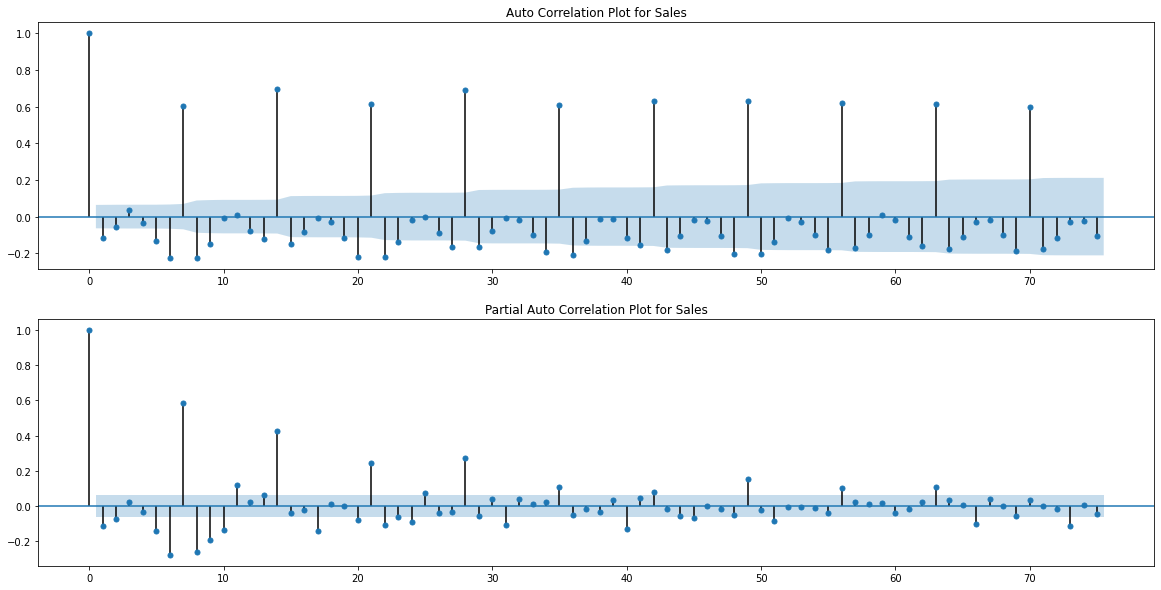

In [ ]:
correlationlPlot('Sales',store_1_treated_outlier['Sales'])

**Insights:**


    Store 1 : p = 7
              q = 0
              d = 0
                          
    Reason :  
              p's --> possibility is 7,14,21,28,35,49,56,.., but seeing the Data has a weekly Pattern and 7 Being Highly  
                      Partial Corelated with the Data series we opt for 7.
              d --> is 0 , As data is staionary and there is no requirement of Differencing.
              q --> is 0 , As the autocorrelation never dies down.

In [ ]:
# Creating a MinMaxScaler for Standarzing the Columns
mms = sklearn.preprocessing.MinMaxScaler()

#### Train Test Split

In [ ]:
train_len = len(store_1_treated_outlier)-42
store_1_train = store_1_treated_outlier.iloc[:train_len,:]
store_1_test = store_1_treated_outlier.iloc[train_len:,:]

In [ ]:
print('- Train and Test Data Shape of Store 1 :', store_1_train.shape ,'and' ,store_1_test.shape)

- Train and Test Data Shape of Store 1 : (900, 9) and (42, 9)


#### Standardization

In [ ]:
# Standarizing the Columns
store_1_train[["Sales", "Customers"]] = mms.fit_transform(store_1_train[["Sales", "Customers"]])
store_1_test[['Sales','Customers']] = mms.transform(store_1_test[['Sales','Customers']])

#### ARIMA

In [ ]:
store_1_test = arimaFunction(store_1_train, store_1_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                 196.949
Method:                       css-mle   S.D. of innovations              0.194
Date:                Sun, 06 Mar 2022   AIC                           -375.898
Time:                        04:21:05   BIC                           -332.676
Sample:                    01-01-2013   HQIC                          -359.387
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4990      0.009     56.895      0.000       0.482       0.516
ar.L1.Sales    -0.0092      0.027     -0.341      0.733      -0.062       0.044
ar.L2.Sales     0.0211      0.026      0.800    

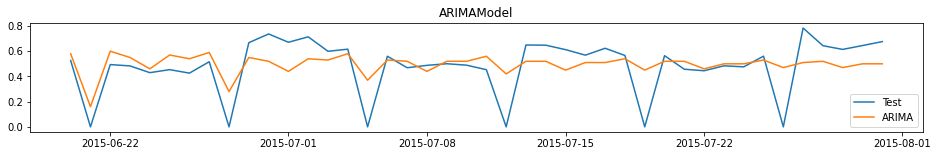

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_1_test, 'ARIMA')

In [ ]:
results = scoringMetric(store_1_test,'ARIMA',1,results)
results

Time Series Model Store   MAPE  SMAPE  RMSE
0             ARIMA     1  13.48  42.87  0.18

#### ARIMAX

In [ ]:
store_1_test = arimaxFunction(store_1_train,store_1_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                1867.391
Method:                       css-mle   S.D. of innovations              0.030
Date:                Sun, 06 Mar 2022   AIC                          -3700.782
Time:                        04:21:17   BIC                          -3619.141
Sample:                    01-01-2013   HQIC                         -3669.594
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0342      0.006     -5.947      0.000      -0.046      -0.023
Customers       0.9358      0.008    124.024      0.000       0.921       0.951
Promo           0.0675      0.003     24.261    

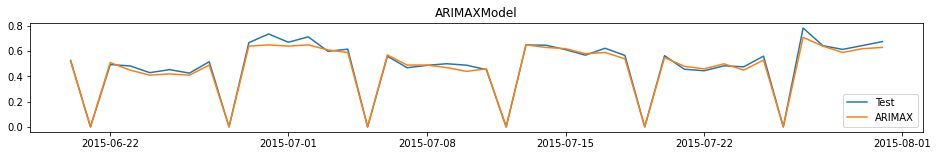

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_1_test,'ARIMAX')

In [ ]:
results = scoringMetric(store_1_test,'ARIMAX',1,results)
results

Time Series Model Store   MAPE  SMAPE  RMSE
0             ARIMA     1  13.48  42.87  0.18
1            ARIMAX     1   4.39   4.50  0.03

#### SARIMA

In [ ]:
store_1_test = sarimaFunction(store_1_train,store_1_test,(7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                 192.788
Date:                            Sun, 06 Mar 2022   AIC                           -355.577
Time:                                    04:24:15   BIC                           -283.541
Sample:                                01-01-2013   HQIC                          -328.059
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2224      0.029      7.719      0.000       0.166       0.279
ar.L2          0.1642      0.033   

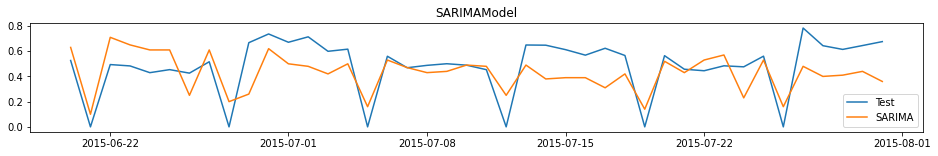

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_1_test,'SARIMA')

In [ ]:
results = scoringMetric(store_1_test,'SARIMA',1,results)
results

Time Series Model Store   MAPE  SMAPE  RMSE
0             ARIMA     1  13.48  42.87  0.18
1            ARIMAX     1   4.39   4.50  0.03
2            SARIMA     1  22.83  54.71  0.18

#### SARIMAX

In [ ]:
store_1_test=sarimaxFunction(store_1_train,store_1_test,(7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                1857.514
Date:                            Sun, 06 Mar 2022   AIC                          -3669.028
Time:                                    04:37:31   BIC                          -3558.573
Sample:                                01-01-2013   HQIC                         -3626.833
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Customers       0.8987      0.004    217.278      0.000       0.891       0.907
Promo           0.0680      0.00

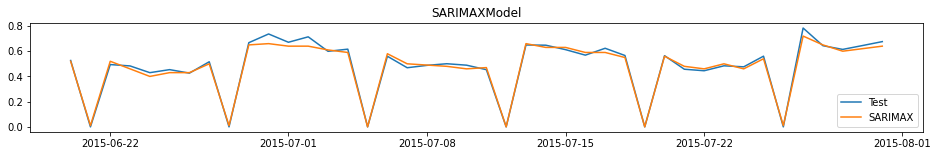

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_1_test,'SARIMAX')

In [ ]:
results=scoringMetric(store_1_test,'SARIMAX',1,results)
results

Time Series Model Store   MAPE  SMAPE  RMSE
0             ARIMA     1  13.48  42.87  0.18
1            ARIMAX     1   4.39   4.50  0.03
2            SARIMA     1  22.83  54.71  0.18
3           SARIMAX     1   3.73  19.17  0.03

#### Johanson Test for Multivariate Time Analysis 

In [ ]:
johanson_coint_test(coint_johansen(store_1_treated_outlier[['Sales', 'Customers']],-1,0))  
coint_rank(store_1_treated_outlier[['Sales', 'Customers']])

   max_eig_stat  trace_stat
0    379.846430  267.471941
1    112.374489  112.374489 

- Crtical Values: (90%,95%,99%) of max_eig_stat :
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

- Crtical Values: (90%,95%,99%) of trace_stat :
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

- Rank of the Dataset for Features Sales & Customers is 2. 
- w1 and w2 are unique that happens when both Features are statioanry & not cointegrated we can build a VAR/ VARMAX model as it is.


#### VAR

In [ ]:
store_1_test = varFunction(store_1_train, store_1_test, 7)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -10.81      -10.72   2.020e-05      -10.78
1       -10.89      -10.78   1.869e-05      -10.85
2       -10.91     -10.78*   1.821e-05      -10.86
3       -10.92      -10.77   1.802e-05      -10.87
4       -10.93      -10.76   1.783e-05      -10.87
5       -10.94      -10.75   1.766e-05     -10.87*
6       -10.95      -10.73   1.761e-05      -10.86
7       -10.94      -10.70   1.769e-05      -10.85
8       -10.94      -10.68   1.769e-05      -10.84
9       -10.95      -10.66   1.761e-05      -10.84
10      -10.96      -10.66   1.731e-05      -10.85
11      -10.96      -10.63   1.736e-05      -10.84
12      -10.96      -10.61   1.745e-05      -10.82
13      -10.96      -10.59   1.731e-05      -10.82
14      -10.97      -10.57   1.722e-05      -10.82
15      -10.97      -10.55   1.723e-05      -10.81
16      -10.96      -10.52   1.

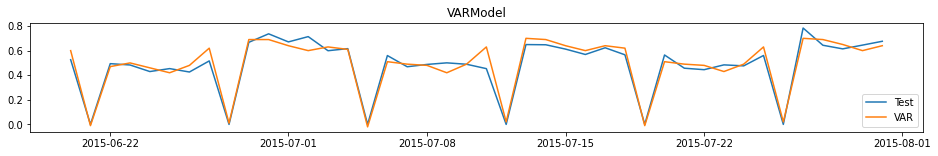

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_1_test,'VAR')

In [ ]:
results=scoringMetric(store_1_test,'VAR',1,results)
results

Time Series Model Store   MAPE  SMAPE  RMSE
0             ARIMA     1  13.48  42.87  0.18
1            ARIMAX     1   4.39   4.50  0.03
2            SARIMA     1  22.83  54.71  0.18
3           SARIMAX     1   3.73  19.17  0.03
4               VAR     1   7.14  35.54  0.05

#### VARMAX

In [ ]:
store_1_test = varmaxFunction(store_1_train,store_1_test,(7,0))

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                2408.234
                              + intercept   AIC                          -4722.468
Date:                    Sun, 06 Mar 2022   BIC                          -4496.756
Time:                            04:41:00   HQIC                         -4636.244
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):                68.91, 84.35   Jarque-Bera (JB):       2841.18, 41.91
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.30, 1.12   Skew:                     -1.77, -0.17
P

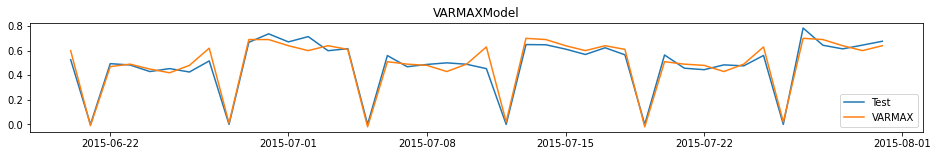

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_1_test,'VARMAX')

In [ ]:
results = scoringMetric(store_1_test,'VARMAX',1,results)
results

Time Series Model Store   MAPE  SMAPE  RMSE
0             ARIMA     1  13.48  42.87  0.18
1            ARIMAX     1   4.39   4.50  0.03
2            SARIMA     1  22.83  54.71  0.18
3           SARIMAX     1   3.73  19.17  0.03
4               VAR     1   7.14  35.54  0.05
5            VARMAX     1   6.95  35.35  0.05

## Store - 3:

In [ ]:
store_3 = dataset[dataset['Store'] == 3]
store_3.drop(columns=['Store'], inplace = True)
store_3.shape

(942, 4)

#### Handling Outlier

In [ ]:
# Saving the 99th Quantile Values as threshold
sales_threshold=store_3['Sales'].quantile(.99)
customers_threshold=store_3['Customers'].quantile(.99)

# Marking Outliers
store_3['sales_outlier']=np.where(store_3['Sales']<=sales_threshold,0,1)
store_3['customers_outlier']=np.where(store_3['Customers']<=customers_threshold,0,1)

# Removing Outliers
store_3_outlier=store_3[(store_3['sales_outlier'] != 1) & (store_3['customers_outlier'] != 1) ]
store_3_outlier.shape

(929, 6)

In [ ]:
# Lets Check the min and Max Date 
pd.date_range(start = '2013-01-01', end = '2015-07-31' ).difference(store_3_outlier.index)

DatetimeIndex(['2013-05-31', '2013-12-16', '2013-12-17', '2013-12-18',
               '2013-12-20', '2013-12-23', '2014-03-31', '2014-06-30',
               '2014-12-15', '2014-12-16', '2014-12-22', '2014-12-23',
               '2015-06-30'],
              dtype='datetime64[ns]', freq=None)

#### Missing Date Imputation with Linear Interpolation

In [ ]:
# Adding the Removed Dates to Impute them with Correct Values 
temp=pd.date_range(start = '2013-01-01', end = '2015-07-31' )
store_3_treated_outlier = store_3_outlier.reindex(temp, fill_value=np.nan)
store_3_treated_outlier.shape

(942, 6)

In [ ]:
# Linear Interpolation
store_3_treated_outlier = store_3_treated_outlier.assign(Sales_Linear_Interpolation=store_3_treated_outlier.Sales.interpolate(method='linear'))
store_3_treated_outlier = store_3_treated_outlier.assign(Customers_Linear_Interpolation=store_3_treated_outlier.Customers.interpolate(method='linear'))

In [ ]:
# Droping Unnceccsary Columns
store_3_treated_outlier.drop(columns=['Sales', 'Customers','sales_outlier','customers_outlier'],inplace=True)

In [ ]:
# Store - 3:  Data PostProcessing for Analysis and Training
store_3_treated_outlier['DayOfWeek']=store_3['DayOfWeek']
store_3_treated_outlier['Promo']=store_3['Promo']
store_3_treated_outlier.rename(columns={'Sales_Linear_Interpolation':'Sales',
       'Customers_Linear_Interpolation':'Customers'},inplace=True)
store_3_treated_outlier.shape

(942, 4)

In [ ]:
store_3_treated_outlier.head()

DayOfWeek  Promo   Sales  Customers
2013-01-01          2      0     0.0        0.0
2013-01-02          3      0  6823.0      805.0
2013-01-03          4      0  5902.0      721.0
2013-01-04          5      0  6069.0      690.0
2013-01-05          6      0  4523.0      525.0

In [ ]:
# Creating Dummies for Day of Week Column
store_3_treated_outlier=pd.get_dummies(store_3_treated_outlier, columns=['DayOfWeek'],drop_first=True)

#### Time Series - Casuality Test

In [ ]:
causality_sales = grangercausalitytests(store_3_treated_outlier[['Sales','Customers']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=158.4702, p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=158.9770, p=0.0000  , df=1
likelihood ratio test: chi2=146.8914, p=0.0000  , df=1
parameter F test:         F=158.4702, p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=93.9442 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=188.8931, p=0.0000  , df=2
likelihood ratio test: chi2=172.1262, p=0.0000  , df=2
parameter F test:         F=93.9442 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=68.9524 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=208.4108, p=0.0000  , df=3
likelihood ratio test: chi2=188.2204, p=0.0000  , df=3
parameter F test:         F=68.9524 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=61.7075 , p=0.0000  

In [ ]:
causality_customers = grangercausalitytests(store_3_treated_outlier[['Customers','Sales']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=76.9208 , p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=77.1668 , p=0.0000  , df=1
likelihood ratio test: chi2=74.1658 , p=0.0000  , df=1
parameter F test:         F=76.9208 , p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=40.8569 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=82.1508 , p=0.0000  , df=2
likelihood ratio test: chi2=78.7574 , p=0.0000  , df=2
parameter F test:         F=40.8569 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=29.4231 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=88.9322 , p=0.0000  , df=3
likelihood ratio test: chi2=84.9692 , p=0.0000  , df=3
parameter F test:         F=29.4231 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=25.3107 , p=0.0000  

- Since all the tests signify causality at significance level 0.05, it means that causality exists between sales and customers.

#### Time Series - Tests to Check the Stationarity of Data 

In [ ]:
stationaryTest(store_3_treated_outlier,3)

- ADF Test Results for "Sales" in Store 3 :
- ADF Statistic: -7.213068
- Critical Values @ 0.05: -2.86
- p-value: 0.000000
- ADF Test Suggests :Null Hypothesis (H0): The series is stationary




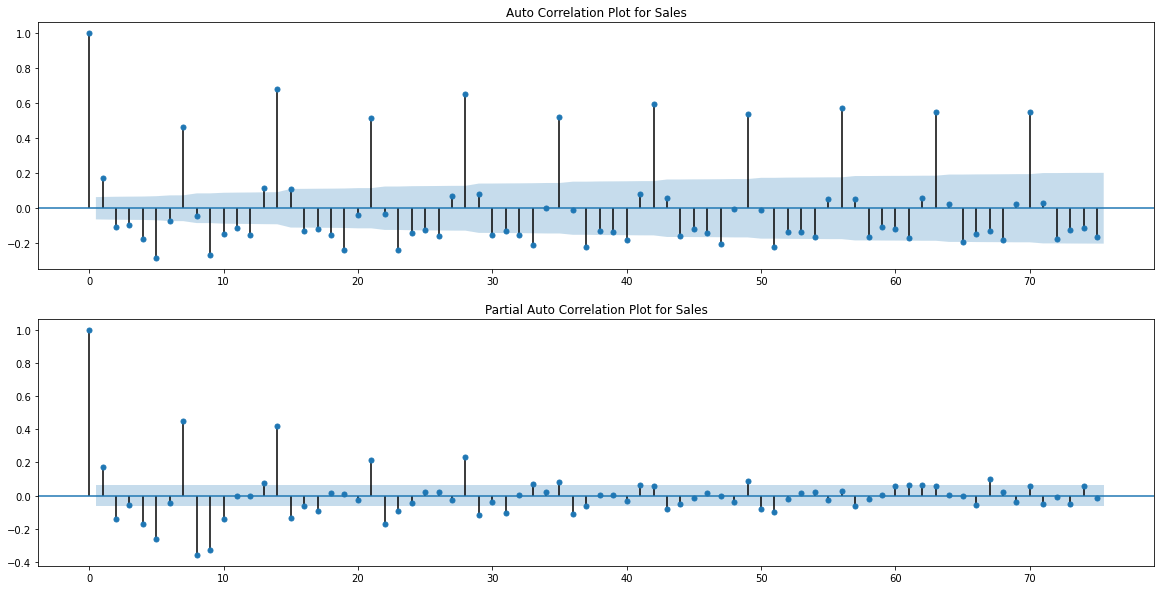

In [ ]:
correlationlPlot('Sales',store_3_treated_outlier['Sales'])

**Insights:**


    Store 1 : p = 7
              q = 0
              d = 0              
              
    Reason :  
              p's --> possibility is 7,14,21,28,35,49,56,.., but seeing the Data has a weekly Pattern and 7 Being Highly  
                      Partial Corelated with the Data series we opt for 7.
              d --> is 0 , As data is staionary and there is no requirement of Differencing.
              q --> is 0 , As the autocorrelation never dies down.

#### Train Test Split

In [ ]:
train_len = len(store_3_treated_outlier)-42
store_3_train = store_3_treated_outlier.iloc[:train_len,:]
store_3_test = store_3_treated_outlier.iloc[train_len:,:]

In [ ]:
print('- Train and Test Data Shape of Store 3 :', store_3_train.shape ,'and' ,store_3_test.shape)

- Train and Test Data Shape of Store 3 : (900, 9) and (42, 9)


In [ ]:
# Standarizing the Columns
store_3_train[["Sales", "Customers"]] = mms.fit_transform(store_3_train[["Sales", "Customers"]])
store_3_test[['Sales','Customers']] = mms.transform(store_3_test[['Sales','Customers']])

#### ARIMA

In [ ]:
store_3_test = arimaFunction(store_3_train,store_3_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                  98.251
Method:                       css-mle   S.D. of innovations              0.217
Date:                Sun, 06 Mar 2022   AIC                           -178.503
Time:                        04:41:02   BIC                           -135.281
Sample:                    01-01-2013   HQIC                          -161.992
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4580      0.008     54.264      0.000       0.441       0.475
ar.L1.Sales     0.1378      0.030      4.606      0.000       0.079       0.196
ar.L2.Sales    -0.0469      0.030     -1.557    

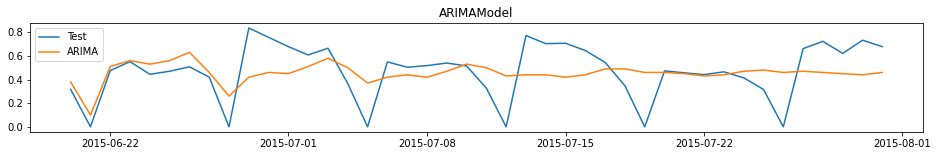

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_3_test,'ARIMA')

In [ ]:
results = scoringMetric(store_3_test,'ARIMA',3,results)
results

Time Series Model Store   MAPE  SMAPE  RMSE
0             ARIMA     1  13.48  42.87  0.18
1            ARIMAX     1   4.39   4.50  0.03
2            SARIMA     1  22.83  54.71  0.18
3           SARIMAX     1   3.73  19.17  0.03
4               VAR     1   7.14  35.54  0.05
5            VARMAX     1   6.95  35.35  0.05
6             ARIMA     3  20.44  50.66  0.21

#### ARIMAX

In [ ]:
store_3_test = arimaxFunction(store_3_train,store_3_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                1826.123
Method:                       css-mle   S.D. of innovations              0.032
Date:                Sun, 06 Mar 2022   AIC                          -3618.246
Time:                        04:41:10   BIC                          -3536.606
Sample:                    01-01-2013   HQIC                         -3587.059
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0425      0.005     -7.818      0.000      -0.053      -0.032
Customers       0.8878      0.007    122.210      0.000       0.874       0.902
Promo           0.1149      0.004     31.341    

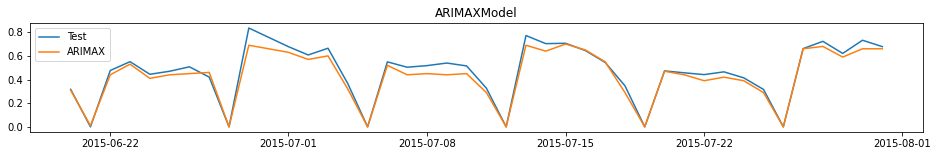

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_3_test,'ARIMAX')

In [ ]:
results=scoringMetric(store_3_test,'ARIMAX',3,results)
results[results['Store']==3]

Time Series Model Store   MAPE  SMAPE  RMSE
6             ARIMA     3  20.44  50.66  0.21
7            ARIMAX     3   7.84  13.68  0.05

#### SARIMA

In [ ]:
store_3_test = sarimaFunction(store_3_train,store_3_test,(7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                 132.582
Date:                            Sun, 06 Mar 2022   AIC                           -235.165
Time:                                    04:45:22   BIC                           -163.129
Sample:                                01-01-2013   HQIC                          -207.647
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2130      0.031      6.881      0.000       0.152       0.274
ar.L2          0.1202      0.040   

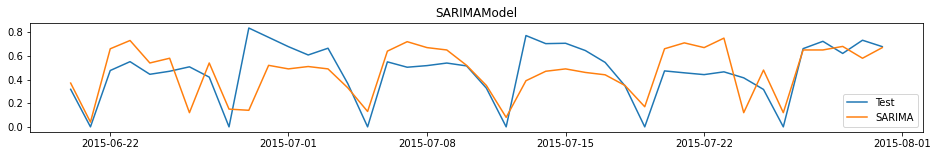

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_3_test, 'SARIMA')

In [ ]:
results = scoringMetric(store_3_test,'SARIMA',3,results)
results[results['Store']==3]

Time Series Model Store   MAPE  SMAPE  RMSE
6             ARIMA     3  20.44  50.66  0.21
7            ARIMAX     3   7.84  13.68  0.05
8            SARIMA     3  25.83  57.03  0.20

#### SARIMAX

In [ ]:
store_3_test = sarimaxFunction(store_3_train, store_3_test, (7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                1799.539
Date:                            Sun, 06 Mar 2022   AIC                          -3553.078
Time:                                    05:02:49   BIC                          -3442.623
Sample:                                01-01-2013   HQIC                         -3510.884
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Customers       0.8425      0.004    199.412      0.000       0.834       0.851
Promo           0.1116      0.00

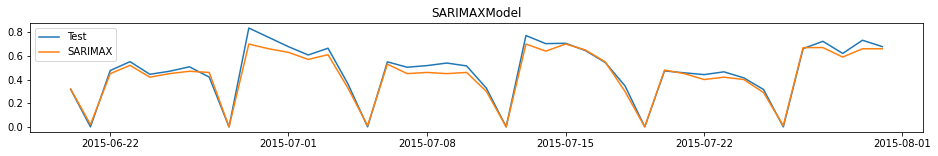

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_3_test,'SARIMAX')

In [ ]:
results = scoringMetric(store_3_test, 'SARIMAX', 3, results)
results[results['Store']==3]

Time Series Model Store   MAPE  SMAPE  RMSE
6             ARIMA     3  20.44  50.66  0.21
7            ARIMAX     3   7.84  13.68  0.05
8            SARIMA     3  25.83  57.03  0.20
9           SARIMAX     3   6.52  22.22  0.05

#### Johanson Test for Multivariate Time Analysis 

In [ ]:
johanson_coint_test(coint_johansen(store_3_treated_outlier[['Sales', 'Customers']],-1,0))  
coint_rank(store_3_treated_outlier[['Sales', 'Customers']])

   max_eig_stat  trace_stat
0    311.164963  211.110991
1    100.053972  100.053972 

- Crtical Values: (90%,95%,99%) of max_eig_stat :
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

- Crtical Values: (90%,95%,99%) of trace_stat :
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

- Rank of the Dataset for Features Sales & Customers is 2. 
- w1 and w2 are unique that happens when both Features are statioanry & not cointegrated we can build a VAR/ VARMAX model as it is.


#### VAR

In [ ]:
store_3_test = varFunction(store_3_train, store_3_test, 7)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -10.63      -10.54   2.422e-05      -10.59
1       -10.65      -10.54   2.368e-05      -10.61
2       -10.68      -10.55   2.299e-05      -10.63
3       -10.75     -10.60*   2.141e-05      -10.69
4       -10.76      -10.58   2.132e-05      -10.69
5       -10.76      -10.56   2.123e-05      -10.68
6       -10.76      -10.54   2.123e-05      -10.68
7       -10.77      -10.53   2.104e-05      -10.68
8       -10.80      -10.54   2.038e-05      -10.70
9       -10.81      -10.52   2.027e-05      -10.70
10      -10.82      -10.51   1.997e-05     -10.70*
11     -10.82*      -10.50  1.991e-05*      -10.70
12      -10.82      -10.47   2.006e-05      -10.68
13      -10.82      -10.44   2.009e-05      -10.67
14      -10.82      -10.42   2.002e-05      -10.67
15      -10.81      -10.40   2.016e-05      -10.65
16      -10.81      -10.37   2.

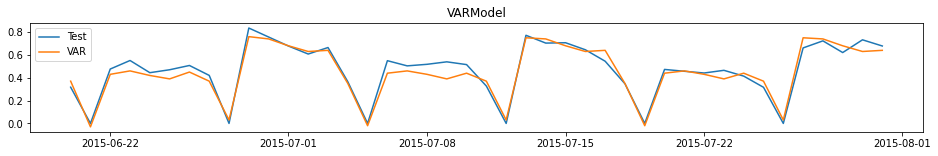

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_3_test,'VAR')

In [ ]:
results=scoringMetric(store_3_test,'VAR',3,results)
results[results['Store']==3]

Time Series Model Store   MAPE  SMAPE  RMSE
6              ARIMA     3  20.44  50.66  0.21
7             ARIMAX     3   7.84  13.68  0.05
8             SARIMA     3  25.83  57.03  0.20
9            SARIMAX     3   6.52  22.22  0.05
10               VAR     3   8.09  36.95  0.06

#### VARMAX

In [ ]:
store_3_test=varmaxFunction(store_3_train,store_3_test,(7,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                2334.716
                              + intercept   AIC                          -4575.432
Date:                    Sun, 06 Mar 2022   BIC                          -4349.720
Time:                            05:06:40   HQIC                         -4489.208
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               64.30, 140.05   Jarque-Bera (JB):      3447.21, 298.62
Prob(Q):                        0.01, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.16, 1.15   Skew:                     -2.12, -0.64
P

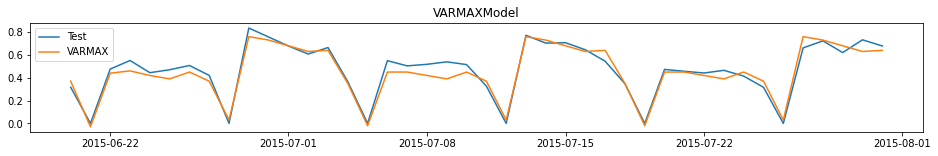

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_3_test,'VARMAX')

In [ ]:
results = scoringMetric(store_3_test,'VARMAX',3,results)
results[results['Store']==3]

Time Series Model Store   MAPE  SMAPE  RMSE
6              ARIMA     3  20.44  50.66  0.21
7             ARIMAX     3   7.84  13.68  0.05
8             SARIMA     3  25.83  57.03  0.20
9            SARIMAX     3   6.52  22.22  0.05
10               VAR     3   8.09  36.95  0.06
11            VARMAX     3   8.09  36.94  0.06

## Store-8:

In [ ]:
store_8 = dataset[dataset['Store'] == 8]
store_8.drop(columns=['Store'], inplace = True)
store_8.shape

(942, 4)

#### Handling Outlier

In [ ]:
# Saving the 99th Quantile Values as threshold
sales_threshold=store_8['Sales'].quantile(.99)
customers_threshold=store_8['Customers'].quantile(.99)

# Marking Outliers
store_8['sales_outlier']=np.where(store_8['Sales']<=sales_threshold,0,1)
store_8['customers_outlier']=np.where(store_8['Customers']<=customers_threshold,0,1)

# Removing Outliers
store_8_outlier = store_8[(store_8['sales_outlier'] != 1) & (store_8['customers_outlier'] != 1) ]
store_8_outlier.shape

(929, 6)

In [ ]:
# Lets Check the min and Max Date 
print('First and Last Dates of Store 8',store_8_outlier.index.min() ,'and' ,store_8_outlier.index.max())

First and Last Dates of Store 8 2013-01-01 00:00:00 and 2015-07-31 00:00:00


In [ ]:
# checking Missing Dates due to Outlier Removal 
pd.date_range(start = '2013-01-01', end = '2015-07-31' ).difference(store_8_outlier.index)

DatetimeIndex(['2013-12-16', '2014-10-06', '2014-11-03', '2014-12-01',
               '2014-12-15', '2014-12-18', '2015-04-02', '2015-04-27',
               '2015-04-30', '2015-05-04', '2015-06-01', '2015-06-15',
               '2015-06-29'],
              dtype='datetime64[ns]', freq=None)

#### Missing Date Imputation with Linear Interpolation

In [ ]:
# Adding the Removed Dates to Impute them with Correct Values 
temp = pd.date_range(start = '2013-01-01', end = '2015-07-31' )
store_8_treated_outlier = store_8_outlier.reindex(temp, fill_value=np.nan)
store_8_treated_outlier.shape

(942, 6)

In [ ]:
# Linear Interpolation
store_8_treated_outlier = store_8_treated_outlier.assign(Sales_Linear_Interpolation=store_8_treated_outlier.Sales.interpolate(method='linear'))
store_8_treated_outlier = store_8_treated_outlier.assign(Customers_Linear_Interpolation=store_8_treated_outlier.Customers.interpolate(method='linear'))

In [ ]:
# Droping Unnceccsary Columns
store_8_treated_outlier.drop(columns=['Sales', 'Customers','sales_outlier','customers_outlier'],inplace=True)

In [ ]:
# Store - 8 :  Data PostProcessing for Analysis and Training
store_8_treated_outlier['DayOfWeek'] = store_8['DayOfWeek']
store_8_treated_outlier['Promo'] = store_8['Promo']
store_8_treated_outlier.rename(columns={'Sales_Linear_Interpolation':'Sales',
       'Customers_Linear_Interpolation':'Customers'}, inplace=True)

In [ ]:
store_8_treated_outlier.head()

DayOfWeek  Promo   Sales  Customers
2013-01-01          2      0     0.0        0.0
2013-01-02          3      0  5419.0      698.0
2013-01-03          4      0  4842.0      662.0
2013-01-04          5      0  4059.0      517.0
2013-01-05          6      0  2337.0      312.0

In [ ]:
# Creating Dummies for Day of Week Column
store_8_treated_outlier = pd.get_dummies(store_8_treated_outlier, columns=['DayOfWeek'], drop_first=True)

#### Time Series - Casuality Test

In [ ]:
causality_sales = grangercausalitytests(store_8_treated_outlier[['Sales','Customers']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=98.0665 , p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=98.3802 , p=0.0000  , df=1
likelihood ratio test: chi2=93.5699 , p=0.0000  , df=1
parameter F test:         F=98.0665 , p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=63.6769 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=128.0349, p=0.0000  , df=2
likelihood ratio test: chi2=120.0341, p=0.0000  , df=2
parameter F test:         F=63.6769 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=67.3102 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=203.4473, p=0.0000  , df=3
likelihood ratio test: chi2=184.1496, p=0.0000  , df=3
parameter F test:         F=67.3102 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=70.8402 , p=0.0000  

In [ ]:
causality_customers = grangercausalitytests(store_8_treated_outlier[['Customers','Sales']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=51.5715 , p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=51.7364 , p=0.0000  , df=1
likelihood ratio test: chi2=50.3642 , p=0.0000  , df=1
parameter F test:         F=51.5715 , p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=27.5318 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=55.3581 , p=0.0000  , df=2
likelihood ratio test: chi2=53.7893 , p=0.0000  , df=2
parameter F test:         F=27.5318 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=40.8585 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=123.4960, p=0.0000  , df=3
likelihood ratio test: chi2=116.0235, p=0.0000  , df=3
parameter F test:         F=40.8585 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=43.8299 , p=0.0000  

- Since all the tests signify causality at significance level 0.05, it means that causality exists between sales and customers.

#### Stationarity Test

In [ ]:
stationaryTest(store_8_treated_outlier, 8)

- ADF Test Results for "Sales" in Store 8 :
- ADF Statistic: -3.866695
- Critical Values @ 0.05: -2.86
- p-value: 0.002294
- ADF Test Suggests :Null Hypothesis (H0): The series is stationary




#### ACF & PACF plots

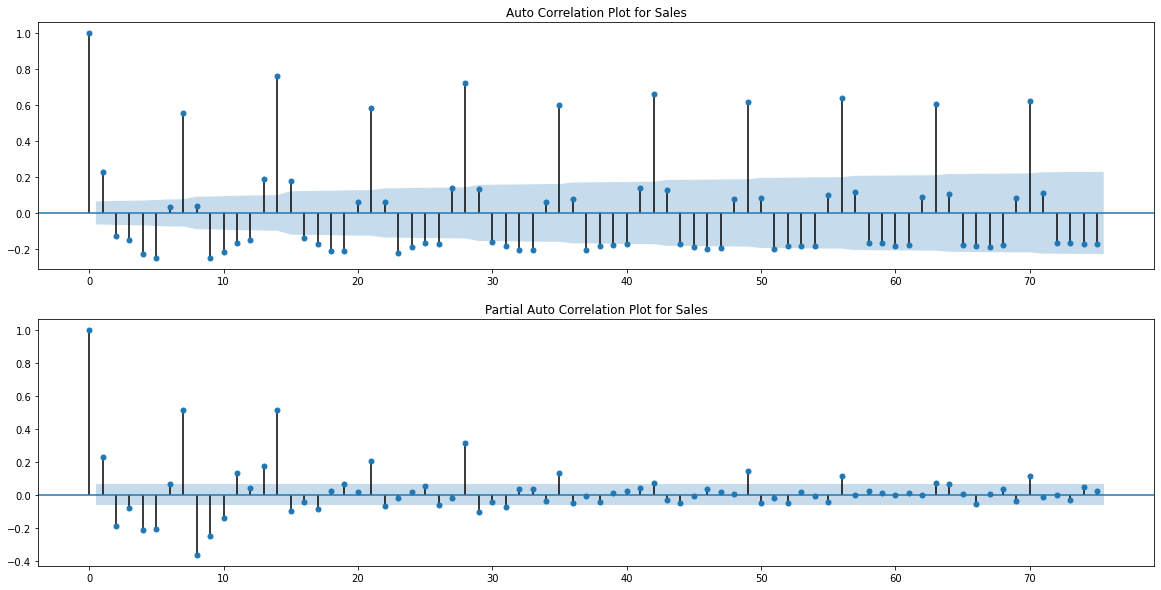

In [ ]:
correlationlPlot('Sales',store_8_treated_outlier['Sales'])

**Insights:**


    Store 1 : p = 7
              q = 0
              d = 0
              
              
    Reason :  
              p's --> possibility is 7,14,21,28,35,49,56,.., but seeing the Data has a weekly Pattern and 7 Being Highly  
                      Partial Corelated with the Data series we opt for 7.
              d --> is 0 , As data is staionary and there is no requirement of Differencing.
              q --> is 0 , As the autocorrelation never dies down.

#### Train Test Split

In [ ]:
train_len = len(store_8_treated_outlier)-42
store_8_train=store_8_treated_outlier.iloc[:train_len,:]
store_8_test=store_8_treated_outlier.iloc[train_len:,:]

In [ ]:
print('- Train and Test Data Shape of Store 8 :', store_8_train.shape ,'and' ,store_8_test.shape)

- Train and Test Data Shape of Store 8 : (900, 9) and (42, 9)


In [ ]:
# Standarizing the Columns
store_8_train[["Sales", "Customers"]] = mms.fit_transform(store_8_train[["Sales", "Customers"]])
store_8_test[['Sales','Customers']] = mms.transform(store_8_test[['Sales','Customers']])

#### ARIMA

In [ ]:
store_8_test = arimaFunction(store_8_train, store_8_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                 143.599
Method:                       css-mle   S.D. of innovations              0.206
Date:                Sun, 06 Mar 2022   AIC                           -269.198
Time:                        05:06:43   BIC                           -225.976
Sample:                    01-01-2013   HQIC                          -252.687
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4544      0.010     45.544      0.000       0.435       0.474
ar.L1.Sales     0.1669      0.029      5.809      0.000       0.111       0.223
ar.L2.Sales    -0.0846      0.029     -2.893    

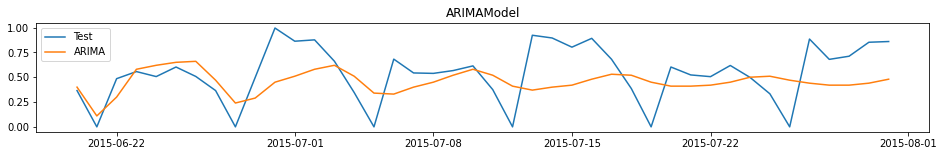

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_8_test, 'ARIMA')

In [ ]:
results = scoringMetric(store_8_test, 'ARIMA', 8, results)
results[results['Store'] == 8]

Time Series Model Store   MAPE  SMAPE  RMSE
12             ARIMA     8  27.42  60.69  0.28

#### ARIMAX

In [ ]:
store_8_test = arimaxFunction(store_8_train,store_8_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                1761.132
Method:                       css-mle   S.D. of innovations              0.034
Date:                Sun, 06 Mar 2022   AIC                          -3488.265
Time:                        05:06:49   BIC                          -3406.624
Sample:                    01-01-2013   HQIC                         -3457.078
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0347      0.006     -5.353      0.000      -0.047      -0.022
Customers       0.8655      0.008    105.260      0.000       0.849       0.882
Promo           0.0990      0.004     26.726    

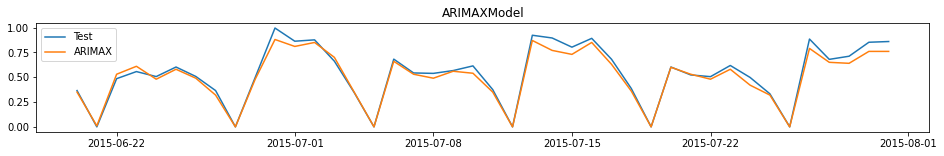

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_8_test,'ARIMAX')

In [ ]:
results=scoringMetric(store_8_test,'ARIMAX',8,results)
results[results['Store']==8]

Time Series Model Store   MAPE  SMAPE  RMSE
12             ARIMA     8  27.42  60.69  0.28
13            ARIMAX     8   6.52  12.18  0.05

#### SARIMA

In [ ]:
store_8_test = sarimaFunction(store_8_train,store_8_test,(7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                 223.091
Date:                            Sun, 06 Mar 2022   AIC                           -416.182
Time:                                    05:12:35   BIC                           -344.146
Sample:                                01-01-2013   HQIC                          -388.663
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2327      0.029      8.125      0.000       0.177       0.289
ar.L2          0.0849      0.044   

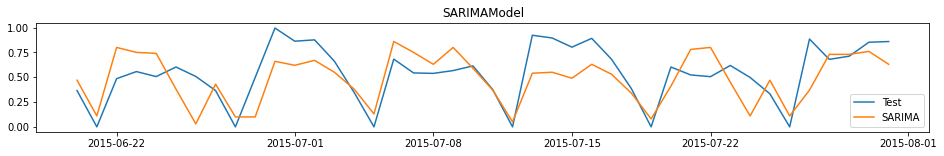

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_8_test,'SARIMA')

In [ ]:
results = scoringMetric(store_8_test,'SARIMA',8,results)
results[results['Store'] == 8]

Time Series Model Store   MAPE  SMAPE  RMSE
12             ARIMA     8  27.42  60.69  0.28
13            ARIMAX     8   6.52  12.18  0.05
14            SARIMA     8  28.96  62.42  0.23

#### SARIMAX

In [ ]:
store_8_test = sarimaxFunction(store_8_train,store_8_test, (7,0,0), (7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                1749.456
Date:                            Sun, 06 Mar 2022   AIC                          -3452.912
Time:                                    05:24:13   BIC                          -3342.457
Sample:                                01-01-2013   HQIC                         -3410.717
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Customers       0.8301      0.005    183.818      0.000       0.821       0.839
Promo           0.0982      0.00

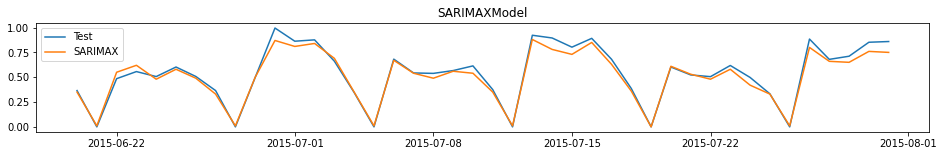

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_8_test,'SARIMAX')

In [ ]:
results = scoringMetric(store_8_test,'SARIMAX',8,results)
results[results['Store'] == 8]

Time Series Model Store   MAPE  SMAPE  RMSE
12             ARIMA     8  27.42  60.69  0.28
13            ARIMAX     8   6.52  12.18  0.05
14            SARIMA     8  28.96  62.42  0.23
15           SARIMAX     8   5.65  30.23  0.05

#### Johanson Test for Multivariate Time Analysis 

In [ ]:
# Johanson Test for Multivariate Time Analysis 
johanson_coint_test(coint_johansen(store_8_treated_outlier[['Sales', 'Customers']],-1,0))  
coint_rank(store_8_treated_outlier[['Sales', 'Customers']])

   max_eig_stat  trace_stat
0    342.761108  248.553302
1     94.207806   94.207806 

- Crtical Values: (90%,95%,99%) of max_eig_stat :
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

- Crtical Values: (90%,95%,99%) of trace_stat :
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

- Rank of the Dataset for Features Sales & Customers is 2. 
- w1 and w2 are unique that happens when both Features are statioanry & not cointegrated we can build a VAR/ VARMAX model as it is.


#### VAR

In [ ]:
store_8_test = varFunction(store_8_train, store_8_test, 7)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -10.52      -10.43   2.711e-05      -10.48
1       -10.56     -10.45*   2.587e-05      -10.52
2       -10.57      -10.44   2.568e-05      -10.52
3       -10.59      -10.44   2.511e-05      -10.53
4       -10.61      -10.43   2.468e-05      -10.54
5       -10.62      -10.42   2.440e-05      -10.55
6       -10.63      -10.41   2.420e-05      -10.55
7       -10.63      -10.39   2.412e-05      -10.54
8       -10.69      -10.43   2.268e-05      -10.59
9       -10.71      -10.43   2.230e-05      -10.60
10      -10.73      -10.43   2.177e-05      -10.62
11      -10.74      -10.41   2.160e-05      -10.62
12      -10.74      -10.39   2.160e-05      -10.61
13      -10.77      -10.39   2.108e-05      -10.62
14      -10.80      -10.41   2.037e-05     -10.65*
15      -10.80      -10.38   2.038e-05      -10.64
16      -10.79      -10.36   2.

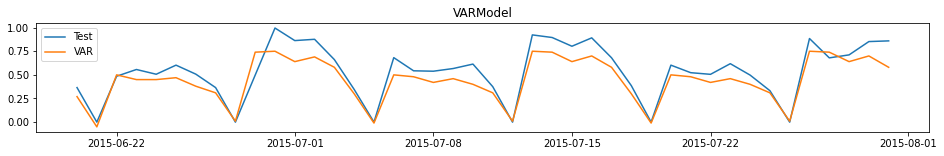

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_8_test,'VAR')

In [ ]:
results = scoringMetric(store_8_test,'VAR',8,results)
results[results['Store'] == 8]

Time Series Model Store   MAPE  SMAPE  RMSE
12             ARIMA     8  27.42  60.69  0.28
13            ARIMAX     8   6.52  12.18  0.05
14            SARIMA     8  28.96  62.42  0.23
15           SARIMAX     8   5.65  30.23  0.05
16               VAR     8  16.49  46.64  0.13

#### VARMAX

In [ ]:
store_8_test = varmaxFunction(store_8_train,store_8_test,(7,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                2276.354
                              + intercept   AIC                          -4458.707
Date:                    Sun, 06 Mar 2022   BIC                          -4232.994
Time:                            05:28:06   HQIC                         -4372.483
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              176.86, 305.07   Jarque-Bera (JB):      2910.90, 349.56
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         2.02, 1.44   Skew:                     -1.87, -0.53
P

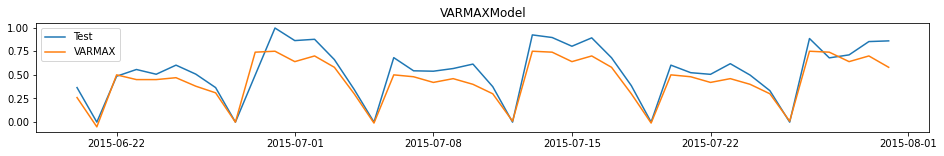

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_8_test,'VARMAX')

In [ ]:
results = scoringMetric(store_8_test, 'VARMAX', 8, results)
results[results['Store'] == 8]

Time Series Model Store   MAPE  SMAPE  RMSE
12             ARIMA     8  27.42  60.69  0.28
13            ARIMAX     8   6.52  12.18  0.05
14            SARIMA     8  28.96  62.42  0.23
15           SARIMAX     8   5.65  30.23  0.05
16               VAR     8  16.49  46.64  0.13
17            VARMAX     8  17.07  43.12  0.13

## Store-9:

In [ ]:
store_9 = dataset[dataset['Store'] == 9]
store_9.drop(columns=['Store'], inplace = True)
store_9.shape

(942, 4)

#### Handling Outlier

In [ ]:
# Saving the 99th Quantile Values as threshold
sales_threshold = store_9['Sales'].quantile(.99)
customers_threshold=store_9['Customers'].quantile(.99)

# Marking Outliers
store_9['sales_outlier'] = np.where(store_9['Sales'] <= sales_threshold, 0, 1)
store_9['customers_outlier'] = np.where(store_9['Customers'] <= customers_threshold,0,1)

# Removing Outliers
store_9_outlier = store_9[(store_9['sales_outlier'] != 1) & (store_9['customers_outlier'] != 1) ]
store_9_outlier.shape

(929, 6)

In [ ]:
# Lets Check the min and Max Date 
pd.date_range(start = '2013-01-01', end = '2015-07-31' ).difference(store_9_outlier.index)

DatetimeIndex(['2013-12-23', '2014-06-30', '2014-11-03', '2014-12-15',
               '2014-12-22', '2014-12-23', '2015-03-16', '2015-03-30',
               '2015-04-13', '2015-04-27', '2015-05-04', '2015-06-01',
               '2015-06-29'],
              dtype='datetime64[ns]', freq=None)

#### checking Missing Dates due to Outlier Removal

In [ ]:
# Checking Missing Dates due to Outlier Removal
temp=pd.date_range(start = '2013-01-01', end = '2015-07-31' )
store_9_treated_outlier = store_9_outlier.reindex(temp, fill_value=np.nan)
store_9_treated_outlier.shape

(942, 6)

In [ ]:
# Linear Interpolation
store_9_treated_outlier = store_9_treated_outlier.assign(Sales_Linear_Interpolation=store_9_treated_outlier.Sales.interpolate(method='linear'))
store_9_treated_outlier = store_9_treated_outlier.assign(Customers_Linear_Interpolation=store_9_treated_outlier.Customers.interpolate(method='linear'))

In [ ]:
# Droping Unnceccsary Columns
store_9_treated_outlier.drop(columns=['Sales', 'Customers','sales_outlier','customers_outlier'],inplace=True)

In [ ]:
# Store - 9:  Data PostProcessing for Analysis and Training
store_9_treated_outlier['DayOfWeek']=store_9['DayOfWeek']
store_9_treated_outlier['Promo']=store_9['Promo']
store_9_treated_outlier.rename(columns={'Sales_Linear_Interpolation':'Sales',
                                        'Customers_Linear_Interpolation':'Customers'},inplace=True)

In [ ]:
store_9_treated_outlier.head()

DayOfWeek  Promo   Sales  Customers
2013-01-01          2      0     0.0        0.0
2013-01-02          3      0  4903.0      481.0
2013-01-03          4      0  4602.0      453.0
2013-01-04          5      0  4798.0      497.0
2013-01-05          6      0  4254.0      450.0

In [ ]:
# Creating Dummies for Day of Week Column
store_9_treated_outlier = pd.get_dummies(store_9_treated_outlier, columns=['DayOfWeek'], drop_first = True)

#### Time Series - Casuality Test

In [ ]:
causality_sales = grangercausalitytests(store_9_treated_outlier[['Sales','Customers']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=116.1199, p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=116.4913, p=0.0000  , df=1
likelihood ratio test: chi2=109.8256, p=0.0000  , df=1
parameter F test:         F=116.1199, p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=70.2653 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=141.2821, p=0.0000  , df=2
likelihood ratio test: chi2=131.6215, p=0.0000  , df=2
parameter F test:         F=70.2653 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=50.3075 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=152.0561, p=0.0000  , df=3
likelihood ratio test: chi2=140.9307, p=0.0000  , df=3
parameter F test:         F=50.3075 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=40.4389 , p=0.0000  

In [ ]:
causality_customers = grangercausalitytests(store_9_treated_outlier[['Customers','Sales']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=56.0905 , p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=56.2699 , p=0.0000  , df=1
likelihood ratio test: chi2=54.6517 , p=0.0000  , df=1
parameter F test:         F=56.0905 , p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=33.8810 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=68.1244 , p=0.0000  , df=2
likelihood ratio test: chi2=65.7690 , p=0.0000  , df=2
parameter F test:         F=33.8810 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=28.5002 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=86.1429 , p=0.0000  , df=3
likelihood ratio test: chi2=82.4177 , p=0.0000  , df=3
parameter F test:         F=28.5002 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=24.0417 , p=0.0000  

- Since all the tests signify causality at significance level 0.05, it means that causality exists between sales and customers.

#### Time Series - Tests to Check the Stationarity of Data

In [ ]:
stationaryTest(store_9_treated_outlier, 9)

- ADF Test Results for "Sales" in Store 9 :
- ADF Statistic: -3.782094
- Critical Values @ 0.05: -2.86
- p-value: 0.003096
- ADF Test Suggests :Null Hypothesis (H0): The series is stationary




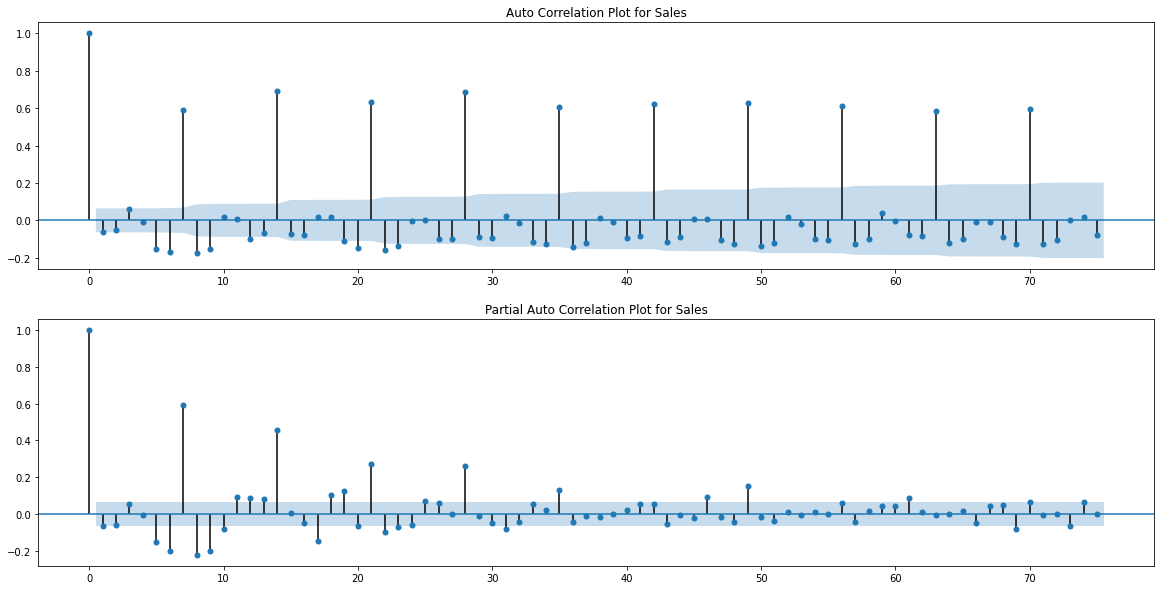

In [ ]:
correlationlPlot('Sales',store_9_treated_outlier['Sales'])

**Insights:**


    Store 1 : p = 7
              q = 0
              d = 0
              
              
    Reason :  
              p's --> possibility is 7,14,21,28,35,49,56,.., but seeing the Data has a weekly Pattern and 7 Being Highly  
                      Partial Corelated with the Data series we opt for 7.
              d --> is 0 , As data is staionary and there is no requirement of Differencing.
              q --> is 0 , As the autocorrelation never dies down.

#### Train Test Split

In [ ]:
train_len = len(store_9_treated_outlier)-42
store_9_train = store_9_treated_outlier.iloc[:train_len,:]
store_9_test = store_9_treated_outlier.iloc[train_len:,:]

In [ ]:
print('- Train and Test Data Shape of Store 9 :', store_9_train.shape ,'and' ,store_9_test.shape)

- Train and Test Data Shape of Store 9 : (900, 9) and (42, 9)


In [ ]:
# Standarizing the Columns
store_9_train[["Sales", "Customers"]] = mms.fit_transform(store_9_train[["Sales", "Customers"]])
store_9_test[['Sales','Customers']] = mms.transform(store_9_test[['Sales','Customers']])

#### ARIMA

In [ ]:
store_9_test = arimaFunction(store_9_train, store_9_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                 222.956
Method:                       css-mle   S.D. of innovations              0.189
Date:                Sun, 06 Mar 2022   AIC                           -427.913
Time:                        05:28:08   BIC                           -384.691
Sample:                    01-01-2013   HQIC                          -411.402
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4582      0.010     44.581      0.000       0.438       0.478
ar.L1.Sales     0.0196      0.027      0.724      0.469      -0.033       0.073
ar.L2.Sales     0.0519      0.027      1.949    

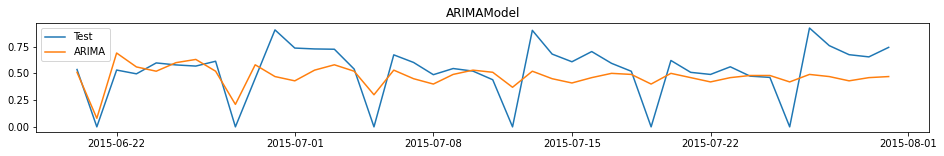

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_9_test,'ARIMA')

In [ ]:
results = scoringMetric(store_9_test,'ARIMA',9,results)
results[results['Store'] == 9]

Time Series Model Store   MAPE  SMAPE  RMSE
18             ARIMA     9  18.34   49.7  0.21

#### ARIMAX

In [ ]:
store_9_test = arimaxFunction(store_9_train,store_9_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                1940.093
Method:                       css-mle   S.D. of innovations              0.028
Date:                Sun, 06 Mar 2022   AIC                          -3846.186
Time:                        05:28:15   BIC                          -3764.545
Sample:                    01-01-2013   HQIC                         -3814.999
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0345      0.005     -6.985      0.000      -0.044      -0.025
Customers       0.8921      0.006    143.397      0.000       0.880       0.904
Promo           0.0577      0.003     20.168    

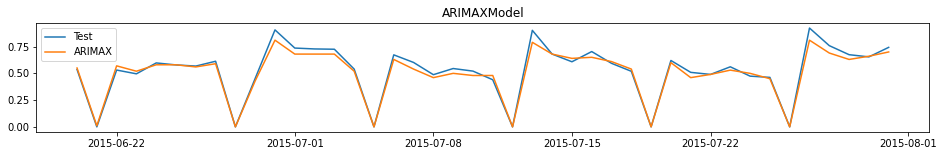

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_9_test,'ARIMAX')

In [ ]:
results=scoringMetric(store_9_test,'ARIMAX',9,results)
results[results['Store']==9]

Time Series Model Store   MAPE  SMAPE  RMSE
18             ARIMA     9  18.34  49.70  0.21
19            ARIMAX     9   5.51  11.07  0.04

#### SARIMA

In [ ]:
store_9_test = sarimaFunction(store_9_train,store_9_test,(7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                 222.280
Date:                            Sun, 06 Mar 2022   AIC                           -414.560
Time:                                    05:30:42   BIC                           -342.524
Sample:                                01-01-2013   HQIC                          -387.042
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2055      0.030      6.890      0.000       0.147       0.264
ar.L2          0.2559      0.039   

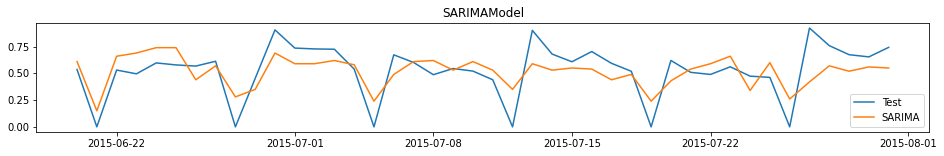

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_9_test,'SARIMA')

In [ ]:
results=scoringMetric(store_9_test,'SARIMA',9,results)
results[results['Store']==9]

Time Series Model Store   MAPE  SMAPE  RMSE
18             ARIMA     9  18.34  49.70  0.21
19            ARIMAX     9   5.51  11.07  0.04
20            SARIMA     9  18.06  47.78  0.18

#### SARIMAX

In [ ]:
store_9_test = sarimaxFunction(store_9_train,store_9_test,(7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                1918.521
Date:                            Sun, 06 Mar 2022   AIC                          -3791.042
Time:                                    05:40:48   BIC                          -3680.587
Sample:                                01-01-2013   HQIC                         -3748.847
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Customers       0.8620      0.004    203.847      0.000       0.854       0.870
Promo           0.0559      0.00

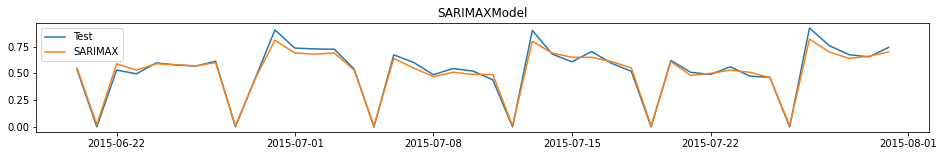

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_9_test,'SARIMAX')

In [ ]:
results = scoringMetric(store_9_test,'SARIMAX',9,results)
results[results['Store'] == 9]

Time Series Model Store   MAPE  SMAPE  RMSE
18             ARIMA     9  18.34  49.70  0.21
19            ARIMAX     9   5.51  11.07  0.04
20            SARIMA     9  18.06  47.78  0.18
21           SARIMAX     9   4.43  33.06  0.04

#### Johanson Test for Multivariate Time Analysis 

In [ ]:
johanson_coint_test(coint_johansen(store_9_treated_outlier[['Sales', 'Customers']],-1,0))  
coint_rank(store_9_treated_outlier[['Sales', 'Customers']])

   max_eig_stat  trace_stat
0    382.567748  273.556438
1    109.011310  109.011310 

- Crtical Values: (90%,95%,99%) of max_eig_stat :
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

- Crtical Values: (90%,95%,99%) of trace_stat :
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

- Rank of the Dataset for Features Sales & Customers is 2. 
- w1 and w2 are unique that happens when both Features are statioanry & not cointegrated we can build a VAR/ VARMAX model as it is.


#### VAR

In [ ]:
store_9_test = varFunction(store_9_train, store_9_test, 7)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -10.86      -10.77   1.918e-05      -10.83
1       -10.93     -10.82*   1.787e-05      -10.89
2       -10.92      -10.79   1.802e-05      -10.87
3       -10.96      -10.80   1.746e-05      -10.90
4       -10.95      -10.77   1.760e-05      -10.88
5       -10.95      -10.75   1.761e-05      -10.87
6       -10.95      -10.73   1.761e-05      -10.86
7       -10.95      -10.71   1.748e-05      -10.86
8       -10.97      -10.71   1.721e-05      -10.87
9       -10.99      -10.70   1.690e-05      -10.88
10      -11.02      -10.71   1.638e-05     -10.90*
11      -11.02      -10.69   1.632e-05      -10.90
12      -11.03      -10.68   1.627e-05      -10.89
13      -11.03      -10.66   1.616e-05      -10.89
14      -11.05      -10.66   1.587e-05      -10.90
15      -11.05      -10.63   1.594e-05      -10.89
16      -11.04      -10.60   1.

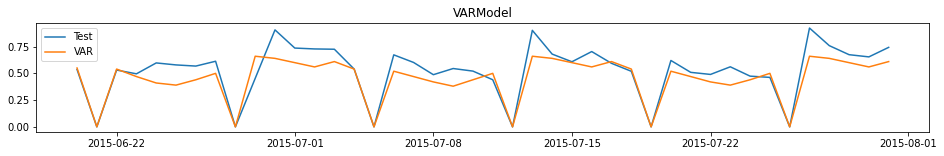

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_9_test,'VAR')

In [ ]:
results=scoringMetric(store_9_test,'VAR',9,results)
results[results['Store']==9]

Time Series Model Store   MAPE  SMAPE  RMSE
18             ARIMA     9  18.34  49.70  0.21
19            ARIMAX     9   5.51  11.07  0.04
20            SARIMA     9  18.06  47.78  0.18
21           SARIMAX     9   4.43  33.06  0.04
22               VAR     9  16.60  18.18  0.12

#### VARMAX

In [ ]:
store_9_test = varmaxFunction(store_9_train,store_9_test,(7,0))

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                2420.041
                              + intercept   AIC                          -4746.081
Date:                    Sun, 06 Mar 2022   BIC                          -4520.369
Time:                            05:44:31   HQIC                         -4659.857
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              164.41, 127.87   Jarque-Bera (JB):       2528.66, 61.83
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.89, 1.34   Skew:                     -1.92, -0.42
P

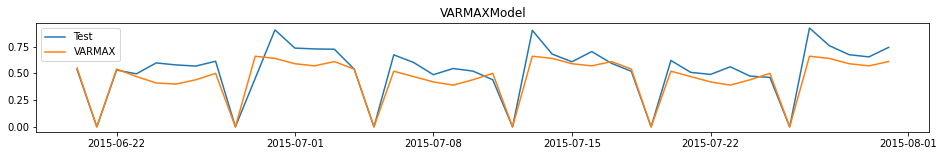

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_9_test,'VARMAX')

In [ ]:
results=scoringMetric(store_9_test,'VARMAX',9,results)
results[results['Store']==9]

Time Series Model Store   MAPE  SMAPE  RMSE
18             ARIMA     9  18.34  49.70  0.21
19            ARIMAX     9   5.51  11.07  0.04
20            SARIMA     9  18.06  47.78  0.18
21           SARIMAX     9   4.43  33.06  0.04
22               VAR     9  16.60  18.18  0.12
23            VARMAX     9  16.51  18.03  0.12

## Store - 25:

In [ ]:
store_25 = dataset[dataset['Store']==25]
store_25.drop(columns=['Store'],inplace=True)
store_25.shape

(942, 4)

#### Handling Outlier

In [ ]:
# Saving the 99th Quantile Values as threshold
sales_threshold=store_25['Sales'].quantile(.99)
customers_threshold=store_25['Customers'].quantile(.99)

# Marking Outliers
store_25['sales_outlier']=np.where(store_25['Sales']<=sales_threshold,0,1)
store_25['customers_outlier']=np.where(store_25['Customers']<=customers_threshold,0,1)

# Removing Outliers
store_25_outlier=store_25[(store_25['sales_outlier'] != 1) & (store_25['customers_outlier'] != 1) ]
store_25_outlier.shape

(929, 6)

In [ ]:
# Lets Check the min and Max Date 
print('First and Last Dates of Store 25',store_25_outlier.index.min() ,'and' ,store_25_outlier.index.max())

First and Last Dates of Store 25 2013-01-01 00:00:00 and 2015-07-31 00:00:00


In [ ]:
# Checking Missing Dates due to Outlier Removal
pd.date_range(start = '2013-01-01', end = '2015-07-31' ).difference(store_25_outlier.index)

DatetimeIndex(['2013-03-28', '2013-04-22', '2013-04-29', '2013-04-30',
               '2013-05-02', '2013-05-31', '2013-12-02', '2013-12-23',
               '2014-01-06', '2014-01-07', '2014-02-14', '2014-02-17',
               '2014-02-18'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
# Adding the Removed Dates to Impute them with Correct Values 
temp=pd.date_range(start = '2013-01-01', end = '2015-07-31' )
store_25_treated_outlier = store_25_outlier.reindex(temp, fill_value=np.nan)
store_25_treated_outlier.shape

(942, 6)

In [ ]:
# Linear Interpolation
store_25_treated_outlier = store_25_treated_outlier.assign(Sales_Linear_Interpolation=store_25_treated_outlier.Sales.interpolate(method='linear'))
store_25_treated_outlier = store_25_treated_outlier.assign(Customers_Linear_Interpolation=store_25_treated_outlier.Customers.interpolate(method='linear'))

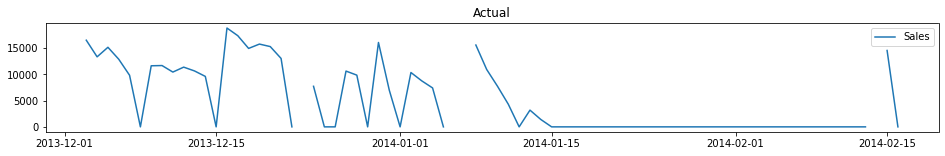

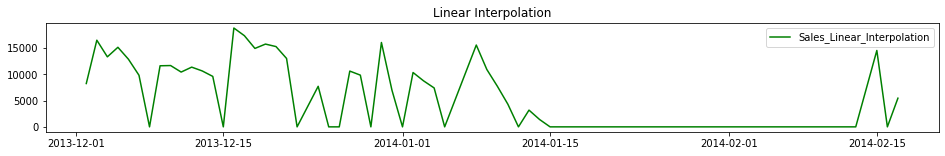

In [ ]:
# Missing Values fixed using INTERPOLATION Visualization
plt.figure(figsize=(16,2)) 
plt.plot(store_25_treated_outlier.loc['2013-12-02':'2014-02-17']['Sales'], label='Sales')
plt.legend(loc='best')
plt.title('Actual')
plt.show()

plt.figure(figsize=(16,2)) 
plt.plot(store_25_treated_outlier.loc['2013-12-02':'2014-02-17']['Sales_Linear_Interpolation'], label='Sales_Linear_Interpolation',color='green')
plt.legend(loc='best')
plt.title('Linear Interpolation')
plt.show()

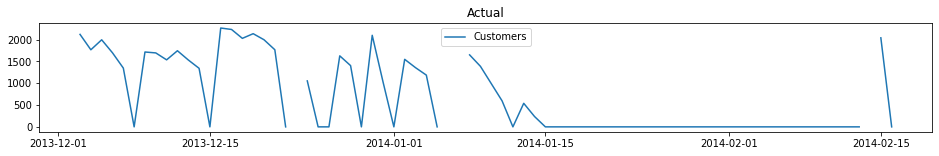

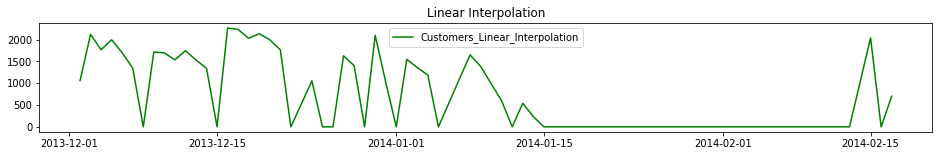

In [ ]:
# Missing Values fixed using INTERPOLATION Visualization
plt.figure(figsize=(16,2)) 
plt.plot(store_25_treated_outlier.loc['2013-12-02':'2014-02-17']['Customers'], label='Customers')
plt.legend(loc='best')
plt.title('Actual')
plt.show()

plt.figure(figsize=(16,2)) 
plt.plot(store_25_treated_outlier.loc['2013-12-02':'2014-02-17']['Customers_Linear_Interpolation'], label='Customers_Linear_Interpolation',color='green')
plt.legend(loc='best')
plt.title('Linear Interpolation')
plt.show()

In [ ]:
# Droping Unnceccsary Columns
store_25_treated_outlier.drop(columns=['Sales','Customers','sales_outlier','customers_outlier'],inplace=True)

In [ ]:
# Store - 25 :  Data PostProcessing for Analysis and Training
store_25_treated_outlier['DayOfWeek']=store_25['DayOfWeek']
store_25_treated_outlier['Promo']=store_25['Promo']
store_25_treated_outlier.rename(columns={'Sales_Linear_Interpolation':'Sales',
                                         'Customers_Linear_Interpolation':'Customers'},inplace=True)

In [ ]:
store_25_treated_outlier.head()

DayOfWeek  Promo    Sales  Customers
2013-01-01          2      0      0.0        0.0
2013-01-02          3      0  11944.0     1698.0
2013-01-03          4      0  10409.0     1587.0
2013-01-04          5      0   9729.0     1520.0
2013-01-05          6      0   8987.0     1381.0

In [ ]:
# Creating Dummies for Day of Week Column
store_25_treated_outlier = pd.get_dummies(store_25_treated_outlier, columns=['DayOfWeek'],drop_first=True)

#### Time Series - Casuality Test

In [ ]:
causality_sales = grangercausalitytests(store_25_treated_outlier[['Sales','Customers']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=49.1412 , p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=49.2983 , p=0.0000  , df=1
likelihood ratio test: chi2=48.0504 , p=0.0000  , df=1
parameter F test:         F=49.1412 , p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=25.6449 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=51.5642 , p=0.0000  , df=2
likelihood ratio test: chi2=50.1996 , p=0.0000  , df=2
parameter F test:         F=25.6449 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=16.7128 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=50.5148 , p=0.0000  , df=3
likelihood ratio test: chi2=49.2029 , p=0.0000  , df=3
parameter F test:         F=16.7128 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=15.8199 , p=0.0000  

In [ ]:
causality_customers = grangercausalitytests(store_25_treated_outlier[['Customers','Sales']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=22.9178 , p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=22.9911 , p=0.0000  , df=1
likelihood ratio test: chi2=22.7147 , p=0.0000  , df=1
parameter F test:         F=22.9178 , p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.2948 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=26.7317 , p=0.0000  , df=2
likelihood ratio test: chi2=26.3587 , p=0.0000  , df=2
parameter F test:         F=13.2948 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.9147  , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=26.9450 , p=0.0000  , df=3
likelihood ratio test: chi2=26.5656 , p=0.0000  , df=3
parameter F test:         F=8.9147  , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=9.5863  , p=0.0000  

- Since all the tests signify causality at significance level 0.05, it means that causality exists between sales and customers.

#### Time Series - Tests to Check the Stationarity of Data

In [ ]:
stationaryTest(store_25_treated_outlier,25)

- ADF Test Results for "Sales" in Store 25 :
- ADF Statistic: -4.153286
- Critical Values @ 0.05: -2.86
- p-value: 0.000790
- ADF Test Suggests :Null Hypothesis (H0): The series is stationary




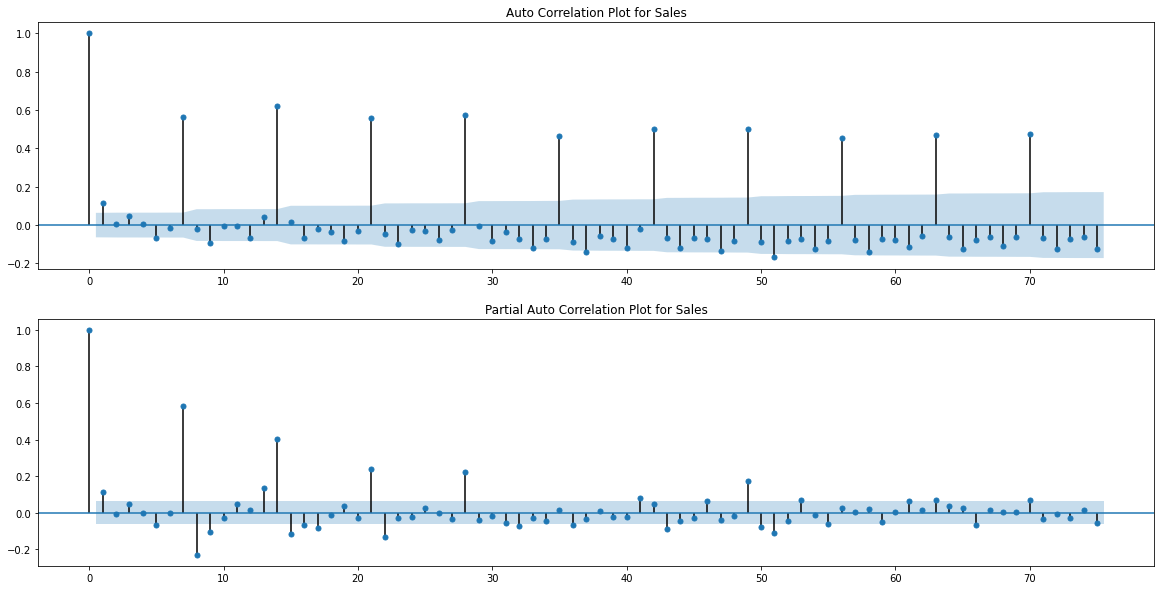

In [ ]:
correlationlPlot('Sales',store_25_treated_outlier['Sales'])

#### Train Test Split

In [ ]:
train_len = len(store_25_treated_outlier)-42
store_25_train = store_25_treated_outlier.iloc[:train_len,:]
store_25_test = store_25_treated_outlier.iloc[train_len:,:]

In [ ]:
print('- Train and Test Data Shape of Store 25 :', store_25_train.shape ,'and' ,store_25_test.shape)

- Train and Test Data Shape of Store 25 : (900, 9) and (42, 9)


In [ ]:
# Standarizing the Columns
store_25_train[["Sales", "Customers"]] = mms.fit_transform(store_25_train[["Sales", "Customers"]])
store_25_test[['Sales','Customers']] = mms.transform(store_25_test[['Sales','Customers']])

#### ARIMA

In [ ]:
store_25_test = arimaFunction(store_25_train,store_25_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                 104.872
Method:                       css-mle   S.D. of innovations              0.215
Date:                Sun, 06 Mar 2022   AIC                           -191.744
Time:                        05:44:34   BIC                           -148.522
Sample:                    01-01-2013   HQIC                          -175.233
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4606      0.019     24.852      0.000       0.424       0.497
ar.L1.Sales     0.1173      0.027      4.306      0.000       0.064       0.171
ar.L2.Sales     0.0288      0.027      1.050    

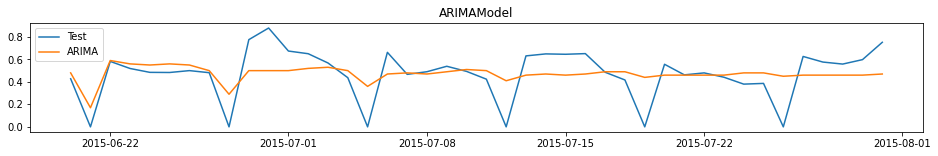

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_25_test,'ARIMA')

In [ ]:
results=scoringMetric(store_25_test,'ARIMA',25,results)
results[results['Store']==25]

Time Series Model Store   MAPE  SMAPE  RMSE
24             ARIMA    25  14.47  44.41  0.19

#### ARIMAX

In [ ]:
store_25_test=arimaxFunction(store_25_train,store_25_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                1934.377
Method:                       css-mle   S.D. of innovations              0.028
Date:                Sun, 06 Mar 2022   AIC                          -3834.754
Time:                        05:44:40   BIC                          -3753.114
Sample:                    01-01-2013   HQIC                         -3803.567
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0379      0.005     -7.850      0.000      -0.047      -0.028
Customers       0.8996      0.005    168.669      0.000       0.889       0.910
Promo           0.0476      0.003     14.918    

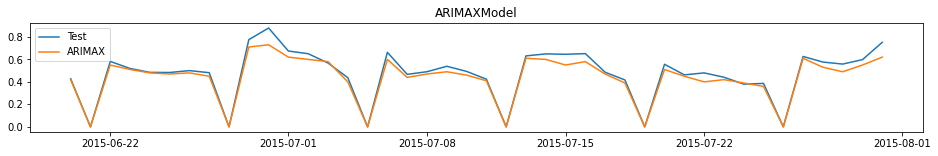

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_25_test,'ARIMAX')

In [ ]:
results=scoringMetric(store_25_test,'ARIMAX',25,results)
results[results['Store']==25]

Time Series Model Store   MAPE  SMAPE  RMSE
24             ARIMA    25  14.47  44.41  0.19
25            ARIMAX    25   6.96   7.31  0.05

#### SARIMA

In [ ]:
store_25_test=sarimaFunction(store_25_train,store_25_test,(7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                 111.817
Date:                            Sun, 06 Mar 2022   AIC                           -193.634
Time:                                    05:47:20   BIC                           -121.598
Sample:                                01-01-2013   HQIC                          -166.116
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2824      0.028     10.218      0.000       0.228       0.337
ar.L2          0.1102      0.037   

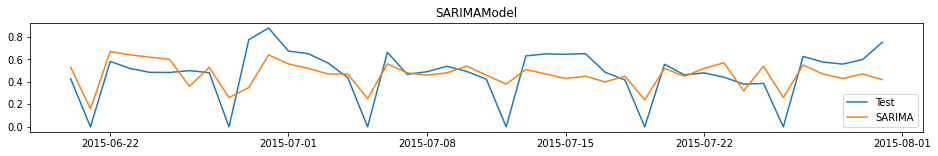

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_25_test,'SARIMA')

In [ ]:
results=scoringMetric(store_25_test,'SARIMA',25,results)
results[results['Store']==25]

Time Series Model Store   MAPE  SMAPE  RMSE
24             ARIMA    25  14.47  44.41  0.19
25            ARIMAX    25   6.96   7.31  0.05
26            SARIMA    25  16.85  46.74  0.17

#### SARIMAX

In [ ]:
store_25_test=sarimaxFunction(store_25_train,store_25_test,(7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                1913.490
Date:                            Sun, 06 Mar 2022   AIC                          -3780.980
Time:                                    05:57:21   BIC                          -3670.525
Sample:                                01-01-2013   HQIC                         -3738.785
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Customers       0.8827      0.005    190.599      0.000       0.874       0.892
Promo           0.0447      0.00

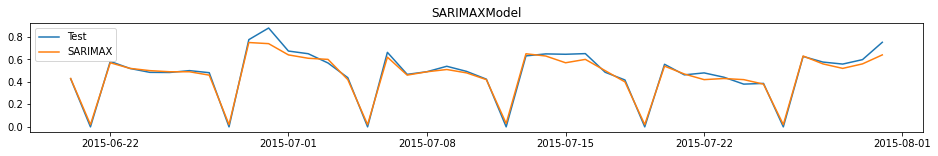

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_25_test,'SARIMAX')

In [ ]:
results=scoringMetric(store_25_test,'SARIMAX',25,results)
results[results['Store']==25]

Time Series Model Store   MAPE  SMAPE  RMSE
24             ARIMA    25  14.47  44.41  0.19
25            ARIMAX    25   6.96   7.31  0.05
26            SARIMA    25  16.85  46.74  0.17
27           SARIMAX    25   3.97  32.67  0.04

#### Johanson Test for Multivariate Time Analysis 

In [ ]:
johanson_coint_test(coint_johansen(store_25_treated_outlier[['Sales', 'Customers']],-1,0))  
coint_rank(store_25_treated_outlier[['Sales', 'Customers']])

   max_eig_stat  trace_stat
0    362.659588  258.182488
1    104.477100  104.477100 

- Crtical Values: (90%,95%,99%) of max_eig_stat :
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

- Crtical Values: (90%,95%,99%) of trace_stat :
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

- Rank of the Dataset for Features Sales & Customers is 2. 
- w1 and w2 are unique that happens when both Features are statioanry & not cointegrated we can build a VAR/ VARMAX model as it is.


#### VAR

In [ ]:
store_25_test = varFunction(store_25_train, store_25_test, 7)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -10.09      -10.00   4.141e-05      -10.06
1       -10.44      -10.33   2.918e-05      -10.40
2       -10.46      -10.33   2.872e-05      -10.41
3       -10.49     -10.33*   2.788e-05     -10.43*
4       -10.49      -10.31   2.782e-05      -10.42
5       -10.50      -10.30   2.751e-05      -10.43
6       -10.51      -10.29   2.735e-05      -10.42
7       -10.51      -10.27   2.713e-05      -10.42
8       -10.52      -10.26   2.696e-05      -10.42
9       -10.52      -10.24   2.689e-05      -10.41
10      -10.52      -10.22   2.689e-05      -10.41
11      -10.52      -10.19   2.701e-05      -10.39
12      -10.51      -10.16   2.718e-05      -10.38
13      -10.51      -10.14   2.720e-05      -10.37
14      -10.52      -10.12   2.712e-05      -10.36
15      -10.51      -10.10   2.719e-05      -10.35
16      -10.51      -10.07   2.

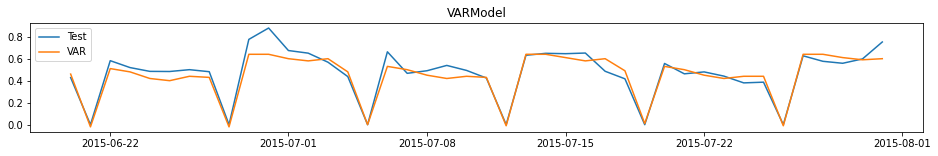

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_25_test,'VAR')

In [ ]:
results=scoringMetric(store_25_test,'VAR',25,results)
results[results['Store']==25]

Time Series Model Store   MAPE  SMAPE  RMSE
24             ARIMA    25  14.47  44.41  0.19
25            ARIMAX    25   6.96   7.31  0.05
26            SARIMA    25  16.85  46.74  0.17
27           SARIMAX    25   3.97  32.67  0.04
28               VAR    25   9.52  34.24  0.07

#### VARMAX

In [ ]:
store_25_test=varmaxFunction(store_25_train,store_25_test,(7,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                2228.350
                              + intercept   AIC                          -4362.701
Date:                    Sun, 06 Mar 2022   BIC                          -4136.988
Time:                            06:01:11   HQIC                         -4276.477
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               56.66, 107.86   Jarque-Bera (JB):      1343.92, 267.02
Prob(Q):                        0.04, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         0.94, 1.16   Skew:                     -1.47, -0.73
P

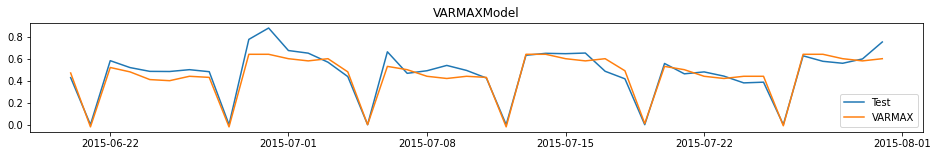

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_25_test,'VARMAX')

In [ ]:
results = scoringMetric(store_25_test,'VARMAX',25,results)
results[results['Store']==25]

Time Series Model Store   MAPE  SMAPE  RMSE
24             ARIMA    25  14.47  44.41  0.19
25            ARIMAX    25   6.96   7.31  0.05
26            SARIMA    25  16.85  46.74  0.17
27           SARIMAX    25   3.97  32.67  0.04
28               VAR    25   9.52  34.24  0.07
29            VARMAX    25   9.72  34.45  0.07

## Store - 29:

In [ ]:
store_29 = dataset[dataset['Store']==29]
store_29.drop(columns=['Store'],inplace=True)
store_29.shape

(942, 4)

#### Handling Outlier

In [ ]:
#### Outlier Detection and Fixation

# Saving the 99th Quantile Values as threshold
sales_threshold=store_29['Sales'].quantile(.99)
customers_threshold=store_29['Customers'].quantile(.99)

# Marking Outliers
store_29['sales_outlier']=np.where(store_29['Sales']<=sales_threshold,0,1)
store_29['customers_outlier']=np.where(store_29['Customers']<=customers_threshold,0,1)

# Removing Outliers
store_29_outlier=store_29[(store_29['sales_outlier'] != 1) & (store_29['customers_outlier'] != 1) ]
store_29_outlier.shape

(928, 6)

In [ ]:
# Lets check if we have missed any date in between while removing outliers
print('First and Last Dates of Store 29',store_29.index.min() ,'and' ,store_29.index.max())

First and Last Dates of Store 29 2013-01-01 00:00:00 and 2015-07-31 00:00:00


#### checking Missing Dates due to Outlier Removal

In [ ]:
#checking Missing Dates due to Outlier Removal
pd.date_range(start = '2013-01-01', end = '2015-07-31' ).difference(store_29_outlier.index)

DatetimeIndex(['2013-12-16', '2013-12-23', '2014-02-03', '2014-06-30',
               '2014-11-03', '2014-12-01', '2014-12-15', '2014-12-22',
               '2014-12-23', '2015-03-16', '2015-03-30', '2015-06-01',
               '2015-06-15', '2015-06-29'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
# Adding the Removed Dates to Impute them with Correct Values 
temp = pd.date_range(start = '2013-01-01', end = '2015-07-31' )
store_29_treated_outlier = store_29_outlier.reindex(temp, fill_value=np.nan)
store_29_treated_outlier.shape

(942, 6)

In [ ]:
# Linear Interpolation
store_29_treated_outlier = store_29_treated_outlier.assign(Sales_Linear_Interpolation=store_29_treated_outlier.Sales.interpolate(method='linear'))
store_29_treated_outlier = store_29_treated_outlier.assign(Customers_Linear_Interpolation=store_29_treated_outlier.Customers.interpolate(method='linear'))

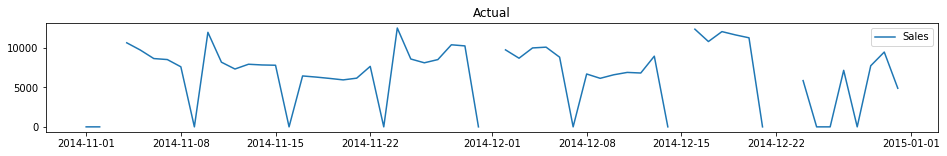

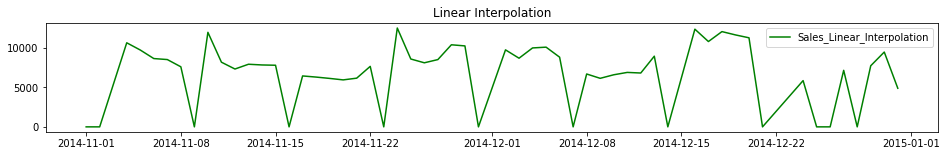

In [ ]:
# Missing Values fixed using INTERPOLATION Visualization
plt.figure(figsize=(16,2)) 
plt.plot(store_29_treated_outlier.loc['2014-11-01':'2014-12-31']['Sales'], label='Sales')
plt.legend(loc='best')
plt.title('Actual')
plt.show()

plt.figure(figsize=(16,2)) 
plt.plot(store_29_treated_outlier.loc['2014-11-01':'2014-12-31']['Sales_Linear_Interpolation'], label='Sales_Linear_Interpolation',color='green')
plt.legend(loc='best')
plt.title('Linear Interpolation')
plt.show()

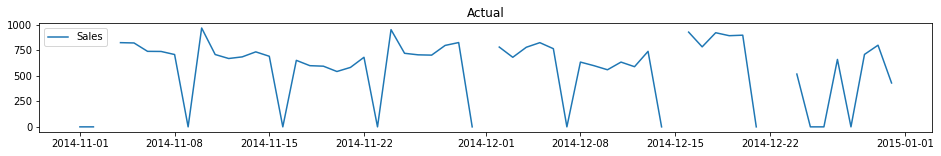

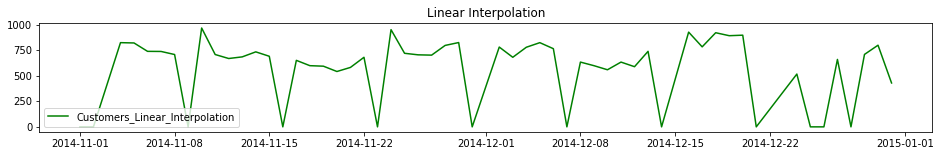

In [ ]:
# Missing Values fixed using INTERPOLATION Visualization
plt.figure(figsize=(16,2)) 
plt.plot(store_29_treated_outlier.loc['2014-11-01':'2014-12-31']['Customers'], label='Sales')
plt.legend(loc='best')
plt.title('Actual')
plt.show()

plt.figure(figsize=(16,2)) 
plt.plot(store_29_treated_outlier.loc['2014-11-01':'2014-12-31']['Customers_Linear_Interpolation'], label='Customers_Linear_Interpolation',color='green')
plt.legend(loc='best')
plt.title('Linear Interpolation')
plt.show()

In [ ]:
# Droping Unnceccsary Columns
store_29_treated_outlier.drop(columns=['Sales','Customers','sales_outlier','customers_outlier'],inplace=True)

In [ ]:
# Store - 29 :  Data PostProcessing for Analysis and Training
store_29_treated_outlier['DayOfWeek']=store_29['DayOfWeek']
store_29_treated_outlier['Promo']=store_29['Promo']
store_29_treated_outlier.rename(columns={'Sales_Linear_Interpolation':'Sales',
       'Customers_Linear_Interpolation':'Customers'},inplace=True)

In [ ]:
store_29_treated_outlier.head()

DayOfWeek  Promo   Sales  Customers
2013-01-01          2      0     0.0        0.0
2013-01-02          3      0  5269.0      550.0
2013-01-03          4      0  4554.0      456.0
2013-01-04          5      0  5411.0      505.0
2013-01-05          6      0  5564.0      537.0

In [ ]:
# Creating Dummies for Day of Week Column
store_29_treated_outlier = pd.get_dummies(store_29_treated_outlier, columns=['DayOfWeek'],drop_first=True)

#### Time Series - Casuality Test

In [ ]:
causality_sales = grangercausalitytests(store_29_treated_outlier[['Sales','Customers']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=279.9205, p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=280.8158, p=0.0000  , df=1
likelihood ratio test: chi2=245.7424, p=0.0000  , df=1
parameter F test:         F=279.9205, p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=155.4993, p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=312.6617, p=0.0000  , df=2
likelihood ratio test: chi2=269.9173, p=0.0000  , df=2
parameter F test:         F=155.4993, p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=104.3295, p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=315.3392, p=0.0000  , df=3
likelihood ratio test: chi2=271.8862, p=0.0000  , df=3
parameter F test:         F=104.3295, p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=79.3110 , p=0.0000  

In [ ]:
causality_customers = grangercausalitytests(store_29_treated_outlier[['Customers','Sales']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=162.4241, p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=162.9436, p=0.0000  , df=1
likelihood ratio test: chi2=150.2786, p=0.0000  , df=1
parameter F test:         F=162.4241, p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=89.3224 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=179.6002, p=0.0000  , df=2
likelihood ratio test: chi2=164.3562, p=0.0000  , df=2
parameter F test:         F=89.3224 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=62.6357 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=189.3184, p=0.0000  , df=3
likelihood ratio test: chi2=172.4644, p=0.0000  , df=3
parameter F test:         F=62.6357 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=47.5745 , p=0.0000  

- Since all the tests signify causality at significance level 0.05, it means that causality exists between sales and customers.

#### Time Series - Tests to Check the Stationarity of Data 

In [ ]:
stationaryTest(store_29_treated_outlier,29)

- ADF Test Results for "Sales" in Store 29 :
- ADF Statistic: -3.707216
- Critical Values @ 0.05: -2.86
- p-value: 0.004013
- ADF Test Suggests :Null Hypothesis (H0): The series is stationary




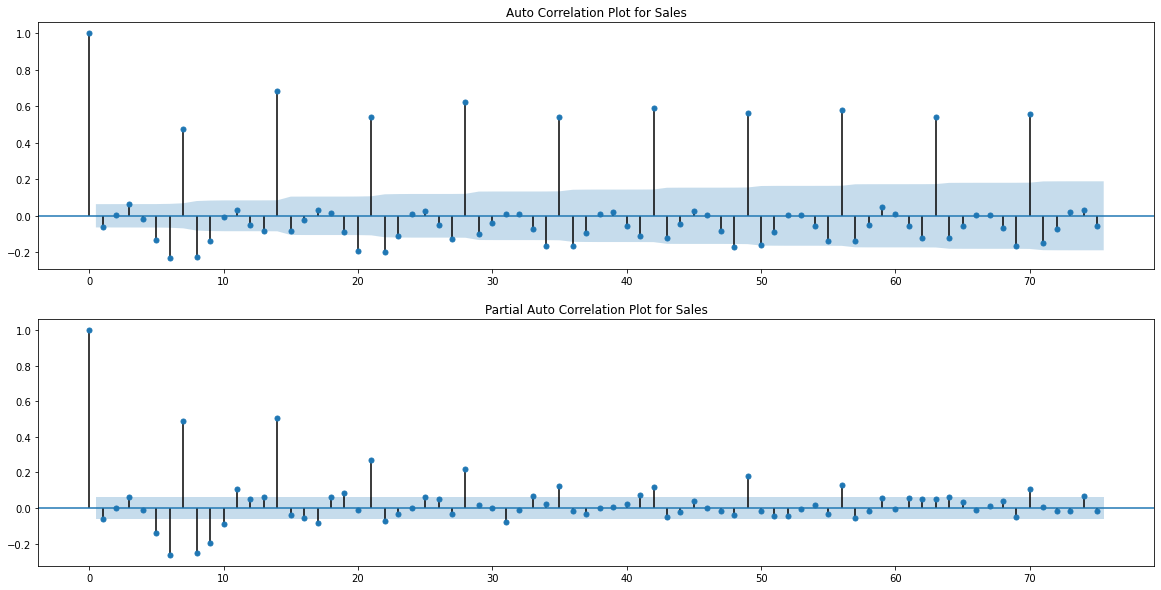

In [ ]:
correlationlPlot('Sales',store_29_treated_outlier['Sales'])

**Insights:**


    Store 1 : p = 7
              q = 0
              d = 0
              
              
    Reason :  
              p's --> possibility is 7,14,21,28,35,49,56,.., but seeing the Data has a weekly Pattern and 7 Being Highly  
                      Partial Corelated with the Data series we opt for 7.
              d --> is 0 , As data is staionary and there is no requirement of Differencing.
              q --> is 0 , As the autocorrelation never dies down.
			  

In [ ]:
train_len = len(store_29_treated_outlier)-42
store_29_train = store_29_treated_outlier.iloc[:train_len,:]
store_29_test = store_29_treated_outlier.iloc[train_len:,:]

In [ ]:
print('- Train and Test Data Shape of Store 29 :', store_29_train.shape ,'and' ,store_29_test.shape)

- Train and Test Data Shape of Store 29 : (900, 9) and (42, 9)


In [ ]:
# Standarizing the Columns
store_29_train[["Sales", "Customers"]] = mms.fit_transform(store_29_train[["Sales", "Customers"]])
store_29_test[['Sales','Customers']] = mms.transform(store_29_test[['Sales','Customers']])

#### ARIMA

In [ ]:
# ARIMA
store_29_test=arimaFunction(store_29_train,store_29_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                 164.590
Method:                       css-mle   S.D. of innovations              0.201
Date:                Sun, 06 Mar 2022   AIC                           -311.181
Time:                        06:01:14   BIC                           -267.959
Sample:                    01-01-2013   HQIC                          -294.670
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4343      0.009     48.088      0.000       0.417       0.452
ar.L1.Sales     0.0307      0.029      1.050      0.294      -0.027       0.088
ar.L2.Sales     0.0874      0.028      3.084    

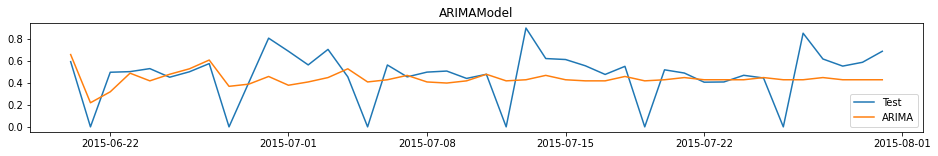

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_29_test,'ARIMA')

In [ ]:
results = scoringMetric(store_29_test,'ARIMA',29,results)
results[results['Store']==29]

Time Series Model Store  MAPE  SMAPE  RMSE
30             ARIMA    29  16.7  48.25  0.21

#### ARIMAX

In [ ]:
store_29_test = arimaxFunction(store_29_train,store_29_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                1905.032
Method:                       css-mle   S.D. of innovations              0.029
Date:                Sun, 06 Mar 2022   AIC                          -3776.064
Time:                        06:01:23   BIC                          -3694.424
Sample:                    01-01-2013   HQIC                         -3744.877
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0379      0.005     -7.523      0.000      -0.048      -0.028
Customers       0.9127      0.007    132.403      0.000       0.899       0.926
Promo           0.0580      0.003     18.074    

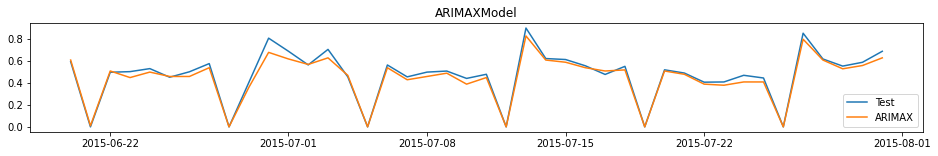

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_29_test,'ARIMAX')

In [ ]:
results = scoringMetric(store_29_test,'ARIMAX',29,results)
results[results['Store']==29]

Time Series Model Store   MAPE  SMAPE  RMSE
30             ARIMA    29  16.70  48.25  0.21
31            ARIMAX    29   6.03  11.68  0.04

#### SARIMA

In [ ]:
store_29_test = sarimaFunction(store_29_train,store_29_test,(7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                 163.412
Date:                            Sun, 06 Mar 2022   AIC                           -296.824
Time:                                    06:03:48   BIC                           -224.788
Sample:                                01-01-2013   HQIC                          -269.305
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3081      0.034      8.963      0.000       0.241       0.375
ar.L2          0.3079      0.043   

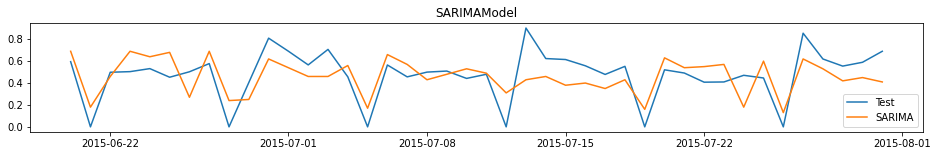

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_29_test,'SARIMA')

In [ ]:
results = scoringMetric(store_29_test,'SARIMA',29,results)
results[results['Store']==29]

Time Series Model Store   MAPE  SMAPE  RMSE
30             ARIMA    29  16.70  48.25  0.21
31            ARIMAX    29   6.03  11.68  0.04
32            SARIMA    29  22.99  53.58  0.18

#### SARIMAX

In [ ]:
store_29_test = sarimaxFunction(store_29_train,store_29_test,(7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                1882.469
Date:                            Sun, 06 Mar 2022   AIC                          -3718.937
Time:                                    06:14:03   BIC                          -3608.482
Sample:                                01-01-2013   HQIC                         -3676.743
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Customers       0.8783      0.005    186.009      0.000       0.869       0.888
Promo           0.0572      0.00

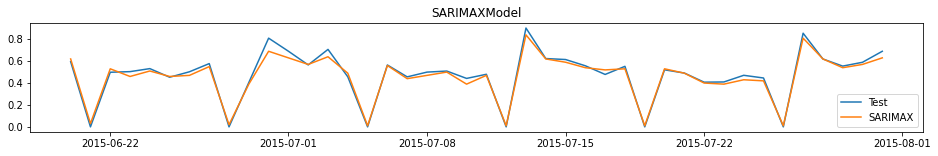

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_29_test,'SARIMAX')

In [ ]:
results = scoringMetric(store_29_test,'SARIMAX',29,results)
results[results['Store']==29]

Time Series Model Store   MAPE  SMAPE  RMSE
30             ARIMA    29  16.70  48.25  0.21
31            ARIMAX    29   6.03  11.68  0.04
32            SARIMA    29  22.99  53.58  0.18
33           SARIMAX    29   4.23  32.92  0.04

#### Johanson Test for Multivariate Time Analysis 

In [ ]:
johanson_coint_test(coint_johansen(store_29_treated_outlier[['Sales', 'Customers']],-1,0))  
coint_rank(store_29_treated_outlier[['Sales', 'Customers']])

   max_eig_stat  trace_stat
0    409.496255  288.575116
1    120.921139  120.921139 

- Crtical Values: (90%,95%,99%) of max_eig_stat :
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

- Crtical Values: (90%,95%,99%) of trace_stat :
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

- Rank of the Dataset for Features Sales & Customers is 2. 
- w1 and w2 are unique that happens when both Features are statioanry & not cointegrated we can build a VAR/ VARMAX model as it is.


#### VAR

In [ ]:
store_29_test = varFunction(store_29_train, store_29_test, 7)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -10.81      -10.72   2.027e-05      -10.77
1       -10.89     -10.78*   1.863e-05      -10.85
2       -10.89      -10.76   1.862e-05      -10.84
3       -10.92      -10.77   1.801e-05      -10.87
4       -10.92      -10.75   1.801e-05      -10.86
5       -10.92      -10.73   1.804e-05      -10.85
6       -10.94      -10.72   1.778e-05      -10.85
7       -10.94      -10.70   1.772e-05      -10.85
8       -10.99      -10.73   1.687e-05      -10.89
9       -11.00      -10.71   1.676e-05      -10.89
10      -11.02      -10.72   1.631e-05      -10.91
11      -11.05      -10.72   1.588e-05      -10.92
12      -11.05      -10.70   1.590e-05      -10.91
13      -11.06      -10.69   1.575e-05      -10.92
14      -11.09      -10.69   1.530e-05     -10.94*
15      -11.08      -10.66   1.542e-05      -10.92
16      -11.07      -10.63   1.

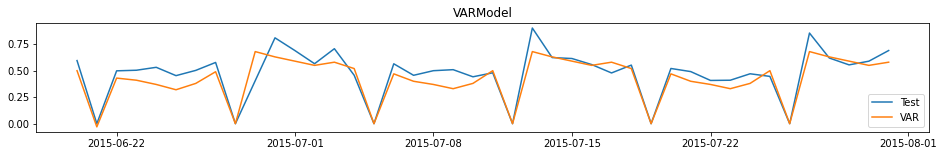

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_29_test,'VAR')

In [ ]:
results = scoringMetric(store_29_test,'VAR',29,results)
results[results['Store'] == 29]

Time Series Model Store   MAPE  SMAPE  RMSE
30             ARIMA    29  16.70  48.25  0.21
31            ARIMAX    29   6.03  11.68  0.04
32            SARIMA    29  22.99  53.58  0.18
33           SARIMAX    29   4.23  32.92  0.04
34               VAR    29  16.04  22.35  0.10

#### VARMAX

In [ ]:
store_29_test = varmaxFunction(store_29_train,store_29_test,(7,0))

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                2416.958
                              + intercept   AIC                          -4739.917
Date:                    Sun, 06 Mar 2022   BIC                          -4514.204
Time:                            06:17:41   HQIC                         -4653.693
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              311.38, 208.80   Jarque-Bera (JB):      1135.96, 163.27
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.76, 1.45   Skew:                     -1.37, -0.76
P

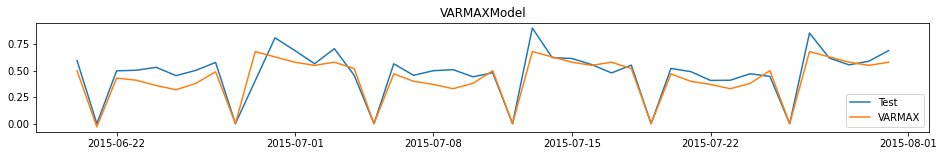

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_29_test,'VARMAX')

In [ ]:
results = scoringMetric(store_29_test,'VARMAX',29,results)
results[results['Store'] == 29]

Time Series Model Store   MAPE  SMAPE  RMSE
30             ARIMA    29  16.70  48.25  0.21
31            ARIMAX    29   6.03  11.68  0.04
32            SARIMA    29  22.99  53.58  0.18
33           SARIMAX    29   4.23  32.92  0.04
34               VAR    29  16.04  22.35  0.10
35            VARMAX    29  16.12  22.47  0.10

## Store - 31:

In [ ]:
store_31 = dataset[dataset['Store'] == 31]
store_31.drop(columns=['Store'], inplace = True)
store_31.shape

(942, 4)

#### Handling Outlier

In [ ]:
# Saving the 99th Quantile Values as threshold
sales_threshold=store_31['Sales'].quantile(.99)
customers_threshold=store_31['Customers'].quantile(.99)

# Marking Outliers
store_31['sales_outlier']=np.where(store_31['Sales']<=sales_threshold,0,1)
store_31['customers_outlier']=np.where(store_31['Customers']<=customers_threshold,0,1)

# Removing Outliers
store_31_outlier=store_31[(store_31['sales_outlier'] != 1) & (store_31['customers_outlier'] != 1) ]
store_31_outlier.shape

(929, 6)

In [ ]:
# Lets check if we have missed any date in between while removing outliers
print('First and Last Dates of Store 31',store_31.index.min() ,'and' ,store_31.index.max())

First and Last Dates of Store 31 2013-01-01 00:00:00 and 2015-07-31 00:00:00


#### checking Missing Dates due to Outlier Removal

In [ ]:
# checking Missing Dates due to Outlier Removal
pd.date_range(start = '2013-01-01', end = '2015-07-31' ).difference(store_31_outlier.index)

DatetimeIndex(['2013-03-28', '2013-03-30', '2013-12-16', '2013-12-20',
               '2013-12-23', '2014-05-02', '2014-12-05', '2014-12-15',
               '2014-12-19', '2014-12-22', '2014-12-23', '2015-04-02',
               '2015-04-04'],
              dtype='datetime64[ns]', freq=None)

In [ ]:
# Adding the Removed Dates to Impute them with Correct Values
temp = pd.date_range(start = '2013-01-01', end = '2015-07-31' )
store_31_treated_outlier = store_31_outlier.reindex(temp, fill_value=np.nan)
store_31_treated_outlier.shape

(942, 6)

In [ ]:
# Linear Interpolation
store_31_treated_outlier = store_31_treated_outlier.assign(Sales_Linear_Interpolation=store_31_treated_outlier.Sales.interpolate(method='linear'))
store_31_treated_outlier = store_31_treated_outlier.assign(Customers_Linear_Interpolation=store_31_treated_outlier.Customers.interpolate(method='linear'))

In [ ]:
# Droping Unnceccsary Columns
store_31_treated_outlier.drop(columns=['Sales', 'Customers','sales_outlier','customers_outlier'],inplace=True)

In [ ]:
# Store - 31:  Data PostProcessing for Analysis and Training
store_31_treated_outlier['DayOfWeek']=store_31['DayOfWeek']
store_31_treated_outlier['Promo']=store_31['Promo']
store_31_treated_outlier.rename(columns={'Sales_Linear_Interpolation':'Sales',
       'Customers_Linear_Interpolation':'Customers'},inplace=True)

In [ ]:
store_31_treated_outlier.head()

DayOfWeek  Promo   Sales  Customers
2013-01-01          2      0     0.0        0.0
2013-01-02          3      0  5122.0      567.0
2013-01-03          4      0  5623.0      578.0
2013-01-04          5      0  6140.0      633.0
2013-01-05          6      0  5607.0      624.0

In [ ]:
# Creating Dummies for Day of Week Column
store_31_treated_outlier = pd.get_dummies(store_31_treated_outlier, columns=['DayOfWeek'],drop_first=True)

#### Time Series - Casuality Test

In [ ]:
causality_sales = grangercausalitytests(store_8_treated_outlier[['Sales','Customers']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=98.0665 , p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=98.3802 , p=0.0000  , df=1
likelihood ratio test: chi2=93.5699 , p=0.0000  , df=1
parameter F test:         F=98.0665 , p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=63.6769 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=128.0349, p=0.0000  , df=2
likelihood ratio test: chi2=120.0341, p=0.0000  , df=2
parameter F test:         F=63.6769 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=67.3102 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=203.4473, p=0.0000  , df=3
likelihood ratio test: chi2=184.1496, p=0.0000  , df=3
parameter F test:         F=67.3102 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=70.8402 , p=0.0000  

In [ ]:
causality_customers = grangercausalitytests(store_8_treated_outlier[['Customers','Sales']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=51.5715 , p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=51.7364 , p=0.0000  , df=1
likelihood ratio test: chi2=50.3642 , p=0.0000  , df=1
parameter F test:         F=51.5715 , p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=27.5318 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=55.3581 , p=0.0000  , df=2
likelihood ratio test: chi2=53.7893 , p=0.0000  , df=2
parameter F test:         F=27.5318 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=40.8585 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=123.4960, p=0.0000  , df=3
likelihood ratio test: chi2=116.0235, p=0.0000  , df=3
parameter F test:         F=40.8585 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=43.8299 , p=0.0000  

- Since all the tests signify causality at significance level 0.05, it means that causality exists between sales and customers.

#### Time Series - Tests to Check the Stationarity of Data

In [ ]:
stationaryTest(store_31_treated_outlier,1)

- ADF Test Results for "Sales" in Store 1 :
- ADF Statistic: -5.803575
- Critical Values @ 0.05: -2.86
- p-value: 0.000000
- ADF Test Suggests :Null Hypothesis (H0): The series is stationary




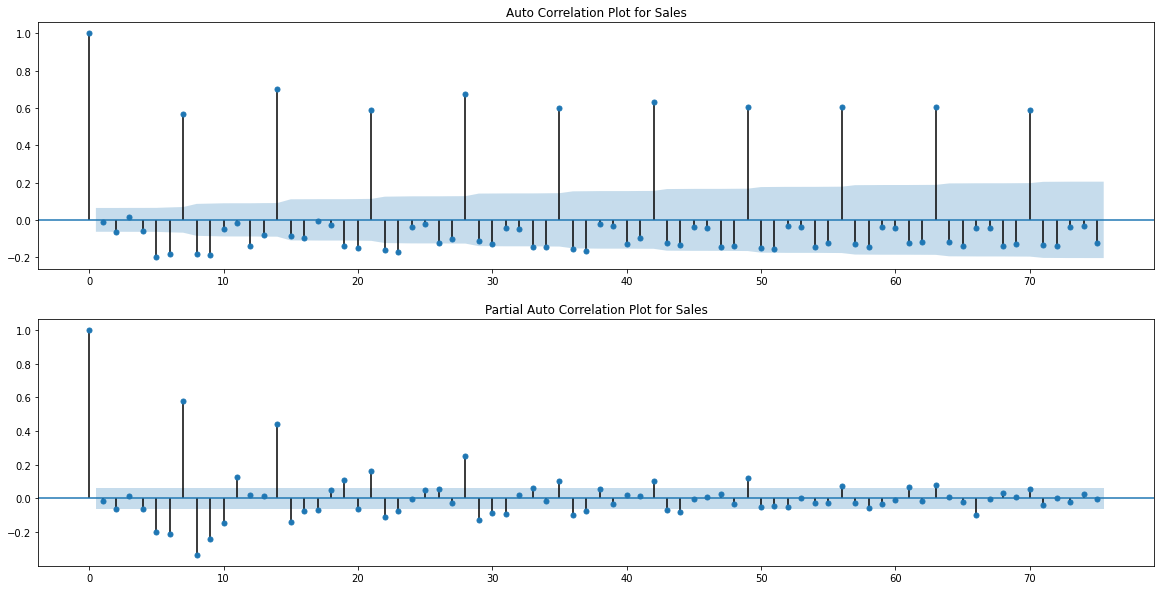

In [ ]:
correlationlPlot('Sales',store_31_treated_outlier['Sales'])

**Insights:**


    Store 1 : p = 7
              q = 0
              d = 0
              
              
    Reason :  
              p's --> possibility is 7,14,21,28,35,49,56,.., but seeing the Data has a weekly Pattern and 7 Being Highly  
                      Partial Corelated with the Data series we opt for 7.
              d --> is 0 , As data is staionary and there is no requirement of Differencing.
              q --> is 0 , As the autocorrelation never dies down.

#### Train Test Split

In [ ]:
train_len = len(store_31_treated_outlier)-42
store_31_train = store_31_treated_outlier.iloc[:train_len,:]
store_31_test = store_31_treated_outlier.iloc[train_len:,:]

In [ ]:
print('- Train and Test Data Shape of Store 31 :', store_31_train.shape ,'and' ,store_31_test.shape)

- Train and Test Data Shape of Store 31 : (900, 9) and (42, 9)


#### Standardization

In [ ]:
# Standarizing the Columns
store_31_train[["Sales", "Customers"]] = mms.fit_transform(store_3_train[["Sales", "Customers"]])
store_31_test[['Sales','Customers']] = mms.transform(store_3_test[['Sales','Customers']])

#### ARIMA

In [ ]:
store_31_test=arimaFunction(store_31_train,store_31_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                  98.251
Method:                       css-mle   S.D. of innovations              0.217
Date:                Sun, 06 Mar 2022   AIC                           -178.503
Time:                        06:17:44   BIC                           -135.281
Sample:                    01-01-2013   HQIC                          -161.992
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4580      0.008     54.264      0.000       0.441       0.475
ar.L1.Sales     0.1378      0.030      4.606      0.000       0.079       0.196
ar.L2.Sales    -0.0469      0.030     -1.557    

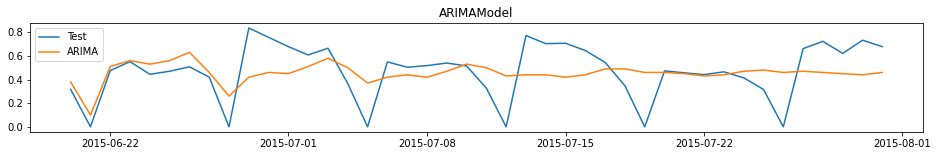

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_31_test,'ARIMA')

In [ ]:
results = scoringMetric(store_31_test,'ARIMA',31,results)
results[results['Store']==31]

Time Series Model Store   MAPE  SMAPE  RMSE
0              ARIMA     1  13.48  42.87  0.18
1             ARIMAX     1   4.39   4.50  0.03
2             SARIMA     1  22.83  54.71  0.18
3            SARIMAX     1   3.73  19.17  0.03
4                VAR     1   7.14  35.54  0.05
5             VARMAX     1   6.95  35.35  0.05
6              ARIMA     3  20.44  50.66  0.21
7             ARIMAX     3   7.84  13.68  0.05
8             SARIMA     3  25.83  57.03  0.20
9            SARIMAX     3   6.52  22.22  0.05
10               VAR     3   8.09  36.95  0.06
11            VARMAX     3   8.09  36.94  0.06
12             ARIMA     8  27.42  60.69  0.28
13            ARIMAX     8   6.52  12.18  0.05
14            SARIMA     8  28.96  62.42  0.23
15           SARIMAX     8   5.65  30.23  0.05
16               VAR     8  16.49  46.64  0.13
17            VARMAX     8  17.07  43.12  0.13
18             ARIMA     9  18.34  49.70  0.21
19            ARIMAX     9   5.51  11.07  0.04
20            SARIMA     9  18.06  47.78  0.18
21           SARIMAX     9   4.43  33.06  0.04
22               VAR     9  16.60  18.18  0.12
23            VARMAX     9  16.51  18.03  0.12
24             ARIMA    25  14.47  44.41  0.19
25            ARIMAX    25   6.96   7.31  0.05
26            SARIMA    25  16.85  46.74  0.17
27           SARIMAX    25   3.97  32.67  0.04
28               VAR    25   9.52  34.24  0.07
29            VARMAX    25   9.72  34.45  0.07
30             ARIMA    29  16.70  48.25  0.21
31            ARIMAX    29   6.03  11.68  0.04
32            SARIMA    29  22.99  53.58  0.18
33           SARIMAX    29   4.23  32.92  0.04
34               VAR    29  16.04  22.35  0.10
35            VARMAX    29  16.12  22.47  0.10
36             ARIMA    31  20.44  50.66  0.21

#### ARIMAX

In [ ]:
store_31_test=arimaxFunction(store_31_train,store_31_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                1826.123
Method:                       css-mle   S.D. of innovations              0.032
Date:                Sun, 06 Mar 2022   AIC                          -3618.246
Time:                        06:17:52   BIC                          -3536.606
Sample:                    01-01-2013   HQIC                         -3587.059
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0425      0.005     -7.818      0.000      -0.053      -0.032
Customers       0.8878      0.007    122.210      0.000       0.874       0.902
Promo           0.1149      0.004     31.341    

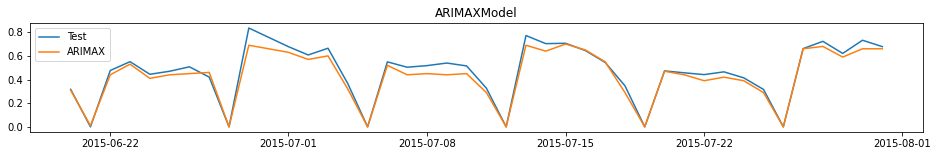

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_31_test,'ARIMAX')

In [ ]:
results=scoringMetric(store_31_test,'ARIMAX',31,results)
results[results['Store']==31]

Time Series Model Store   MAPE  SMAPE  RMSE
36             ARIMA    31  20.44  50.66  0.21
37            ARIMAX    31   7.84  13.68  0.05

#### SARIMA

In [ ]:
store_31_test=sarimaFunction(store_31_train,store_31_test,(7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                 132.582
Date:                            Sun, 06 Mar 2022   AIC                           -235.165
Time:                                    06:22:21   BIC                           -163.129
Sample:                                01-01-2013   HQIC                          -207.647
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2130      0.031      6.881      0.000       0.152       0.274
ar.L2          0.1202      0.040   

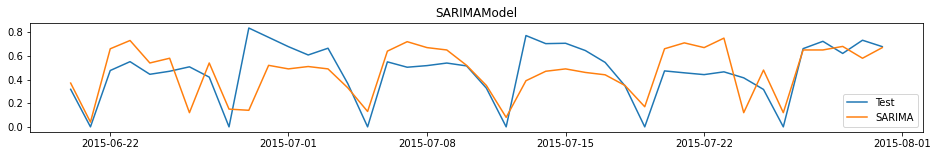

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_31_test,'SARIMA')

In [ ]:
results=scoringMetric(store_31_test,'SARIMA',31,results)
results[results['Store']==31]

Time Series Model Store   MAPE  SMAPE  RMSE
36             ARIMA    31  20.44  50.66  0.21
37            ARIMAX    31   7.84  13.68  0.05
38            SARIMA    31  25.83  57.03  0.20

#### SARIMAX

In [ ]:
store_31_test = sarimaxFunction(store_31_train,store_31_test,(7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                1799.539
Date:                            Sun, 06 Mar 2022   AIC                          -3553.078
Time:                                    06:39:25   BIC                          -3442.623
Sample:                                01-01-2013   HQIC                         -3510.884
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Customers       0.8425      0.004    199.412      0.000       0.834       0.851
Promo           0.1116      0.00

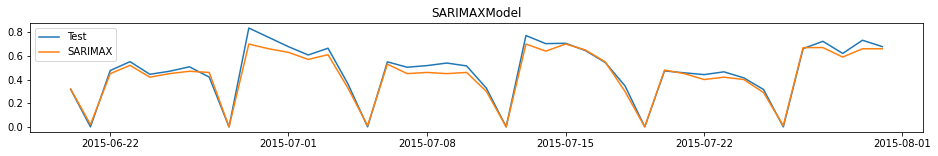

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_31_test,'SARIMAX')

In [ ]:
results = scoringMetric(store_31_test, 'SARIMAX', 31, results)
results[results['Store'] == 31]

Time Series Model Store   MAPE  SMAPE  RMSE
36             ARIMA    31  20.44  50.66  0.21
37            ARIMAX    31   7.84  13.68  0.05
38            SARIMA    31  25.83  57.03  0.20
39           SARIMAX    31   6.52  22.22  0.05

#### Johanson Test for Multivariate Time Analysis 

In [ ]:
johanson_coint_test(coint_johansen(store_31_treated_outlier[['Sales', 'Customers']],-1,0))  
coint_rank(store_31_treated_outlier[['Sales', 'Customers']])

   max_eig_stat  trace_stat
0    311.164963  211.110991
1    100.053972  100.053972 

- Crtical Values: (90%,95%,99%) of max_eig_stat :
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

- Crtical Values: (90%,95%,99%) of trace_stat :
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

- Rank of the Dataset for Features Sales & Customers is 2. 
- w1 and w2 are unique that happens when both Features are statioanry & not cointegrated we can build a VAR/ VARMAX model as it is.


#### VAR

In [ ]:
store_31_test = varFunction(store_31_train, store_31_test, 7)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -10.63      -10.54   2.422e-05      -10.59
1       -10.65      -10.54   2.368e-05      -10.61
2       -10.68      -10.55   2.299e-05      -10.63
3       -10.75     -10.60*   2.141e-05      -10.69
4       -10.76      -10.58   2.132e-05      -10.69
5       -10.76      -10.56   2.123e-05      -10.68
6       -10.76      -10.54   2.123e-05      -10.68
7       -10.77      -10.53   2.104e-05      -10.68
8       -10.80      -10.54   2.038e-05      -10.70
9       -10.81      -10.52   2.027e-05      -10.70
10      -10.82      -10.51   1.997e-05     -10.70*
11     -10.82*      -10.50  1.991e-05*      -10.70
12      -10.82      -10.47   2.006e-05      -10.68
13      -10.82      -10.44   2.009e-05      -10.67
14      -10.82      -10.42   2.002e-05      -10.67
15      -10.81      -10.40   2.016e-05      -10.65
16      -10.81      -10.37   2.

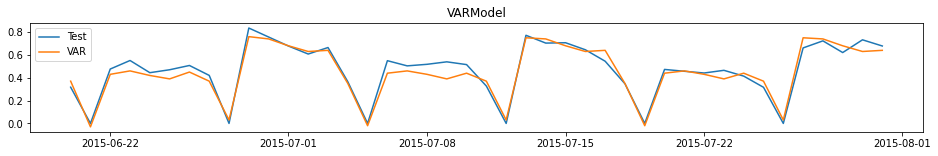

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_31_test,'VAR')

In [ ]:
results=scoringMetric(store_31_test,'VAR',31,results)
results[results['Store'] == 31]

Time Series Model Store   MAPE  SMAPE  RMSE
36             ARIMA    31  20.44  50.66  0.21
37            ARIMAX    31   7.84  13.68  0.05
38            SARIMA    31  25.83  57.03  0.20
39           SARIMAX    31   6.52  22.22  0.05
40               VAR    31   8.09  36.95  0.06

#### VARMAX

In [ ]:
store_31_test = varmaxFunction(store_31_train, store_31_test, (7,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                2334.716
                              + intercept   AIC                          -4575.432
Date:                    Sun, 06 Mar 2022   BIC                          -4349.720
Time:                            06:43:13   HQIC                         -4489.208
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):               64.30, 140.05   Jarque-Bera (JB):      3447.21, 298.62
Prob(Q):                        0.01, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.16, 1.15   Skew:                     -2.12, -0.64
P

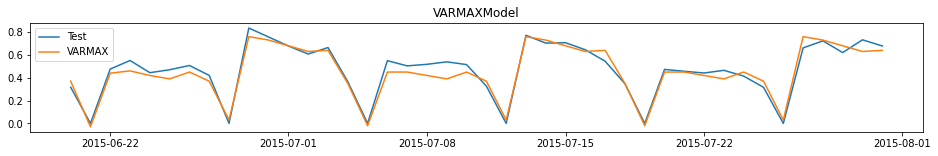

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_31_test, 'VARMAX')

In [ ]:
results = scoringMetric(store_31_test, 'VARMAX', 31, results)
results[results['Store'] == 31]

Time Series Model Store   MAPE  SMAPE  RMSE
36             ARIMA    31  20.44  50.66  0.21
37            ARIMAX    31   7.84  13.68  0.05
38            SARIMA    31  25.83  57.03  0.20
39           SARIMAX    31   6.52  22.22  0.05
40               VAR    31   8.09  36.95  0.06
41            VARMAX    31   8.09  36.94  0.06

## Store - 46:

In [ ]:
store_46 = dataset[dataset['Store'] == 46]
store_46.drop(columns=['Store'], inplace = True)
store_46.shape

(758, 4)

In [ ]:
# Lets check if we have missed any date in between while removing outliers
print('First and Last Dates of Store 1', store_46.index.min(), 'and', store_46.index.max())

First and Last Dates of Store 1 2013-01-01 00:00:00 and 2015-07-31 00:00:00


#### checking Missing Dates due to Outlier Removal

In [ ]:
# checking Missing Dates due to Outlier Removal
pd.date_range(start = '2013-01-01', end = '2015-07-13' ).difference(store_46.index)

DatetimeIndex(['2014-07-01', '2014-07-02', '2014-07-03', '2014-07-04',
               '2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', length=184, freq=None)

In [ ]:
# Missing Dates Value Imputation
temp = pd.date_range(start = '2013-01-01', end = '2015-07-31' )
store_46_missing_values = store_46.reindex(temp, fill_value=np.nan)
store_46_missing_values.shape

(942, 4)

In [ ]:
# Adding the Removed Dates to Impute them with Correct Values using Linear Interpolation 
store_46_missing_values = store_46_missing_values.assign(Sales_Linear_Interpolation = store_46_missing_values.Sales.interpolate(method = 'linear'))
store_46_missing_values = store_46_missing_values.assign(Customers_Linear_Interpolation = store_46_missing_values.Customers.interpolate(method = 'linear'))

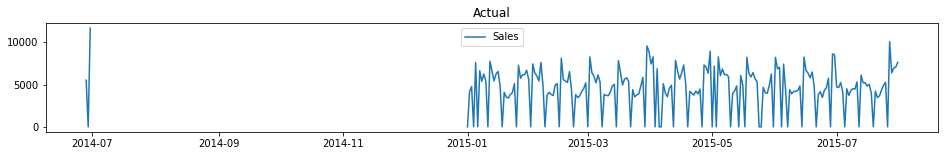

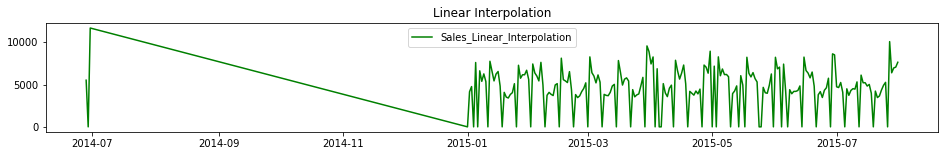

In [ ]:
# Missing Values fixed using INTERPOLATION Visualization
plt.figure(figsize=(16,2)) 
plt.plot(store_46_missing_values.loc['2014-06-28':]['Sales'], label='Sales')
plt.legend(loc='best')
plt.title('Actual')
plt.show()

plt.figure(figsize=(16,2)) 
plt.plot(store_46_missing_values.loc['2014-06-28':]['Sales_Linear_Interpolation'], label='Sales_Linear_Interpolation',color='green')
plt.legend(loc='best')
plt.title('Linear Interpolation')
plt.show()

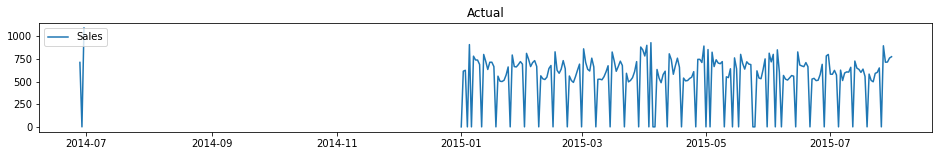

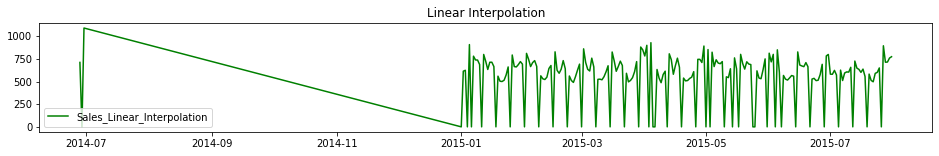

In [ ]:
# Missing Values fixed using INTERPOLATION Visualization
plt.figure(figsize=(16,2)) 
plt.plot(store_46_missing_values .loc['2014-06-28':]['Customers'], label='Sales')
plt.legend(loc='best')
plt.title('Actual')
plt.show()

plt.figure(figsize=(16,2)) 
plt.plot(store_46_missing_values .loc['2014-06-28':]['Customers_Linear_Interpolation'], label='Sales_Linear_Interpolation',color='green')
plt.legend(loc='best')
plt.title('Linear Interpolation')
plt.show()

In [ ]:
# custom Function to create Synthetic Data Point 
# create a list where the first 5 is One's then followed by 10 Zero's.
test_promo=[]
k=0
while k <= len([*range(0,170,15)]):
    for b in range(0,5):
        test_promo.append(1.0)
    if k < 12:
        for b in range(0,10):
            test_promo.append(0.0)
    k=k+1

In [ ]:
# Missing Values fixing for Promo 
store_46_missing_values['2014-06-30':'2014-12-31']['Promo'] = test_promo

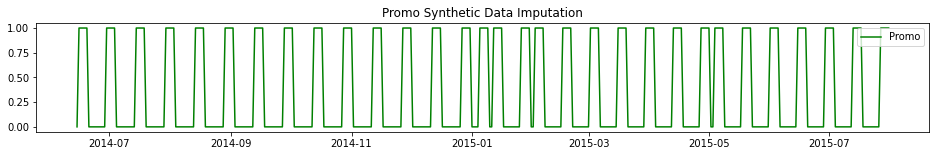

In [ ]:
# Missing Values fixed using INTERPOLATION Visualization
plt.figure(figsize=(16,2)) 
plt.plot(store_46_missing_values.loc['2014-06-15':]['Promo'],color='green',label='Promo')
plt.legend(loc='best')
plt.title('Promo Synthetic Data Imputation')
plt.show()

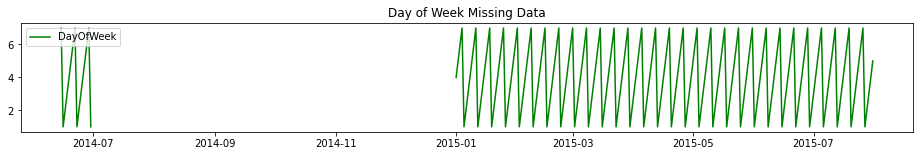

In [ ]:
plt.figure(figsize=(16,2)) 
plt.plot(store_46_missing_values.loc['2014-06-15':]['DayOfWeek'],color='green',label='DayOfWeek')
plt.legend(loc='best')
plt.title('Day of Week Missing Data')
plt.show()

In [ ]:
# Syntehtic Code for Day of Week generation 
for i in store_46_missing_values.index:
    store_46_missing_values.at[i,"DayOfWeek"] = i.weekday() + 1

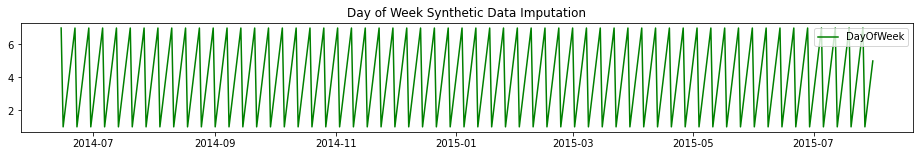

In [ ]:
plt.figure(figsize=(16,2)) 
plt.plot(store_46_missing_values.loc['2014-06-15':]['DayOfWeek'],color='green',label='DayOfWeek')
plt.legend(loc='best')
plt.title('Day of Week Synthetic Data Imputation')
plt.show()

In [ ]:
# Preprocessing Data
store_46_missing_values.drop(columns=['Sales', 'Customers'],inplace=True)
store_46_missing_values.rename(columns={'Sales_Linear_Interpolation':'Sales',
       'Customers_Linear_Interpolation':'Customers'},inplace=True)

In [ ]:
# Making Sunday Values 0 as we have Noted the Pattern
store_46_missing_values['Sales'].loc[store_46_missing_values['DayOfWeek'] == 7.0] = 0
store_46_missing_values['Customers'].loc[store_46_missing_values['DayOfWeek'] == 7.0] = 0


No handles with labels found to put in legend.


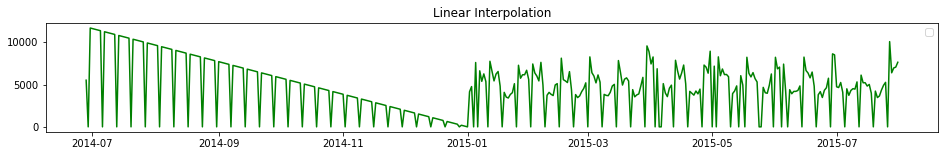

In [ ]:
plt.figure(figsize=(16,2)) 
plt.plot(store_46_missing_values.loc['2014-06-28':]['Sales'],color='green')
plt.legend(loc='best')
plt.title('Linear Interpolation')
plt.show()

#### Outlier Detection and Fixation

In [ ]:
#outlier Dectetion and Fixation
sales_threshold=store_46['Sales'].quantile(.99)
customers_threshold=store_46['Customers'].quantile(.99)
store_46_missing_values['sales_outlier']=np.where(store_46_missing_values['Sales']<=sales_threshold,0,1)
store_46_missing_values['customers_outlier']=np.where(store_46_missing_values['Customers']<=customers_threshold,0,1)

In [ ]:
store_46_outlier=store_46_missing_values[(store_46_missing_values['sales_outlier'] != 1) & (store_46_missing_values['customers_outlier'] != 1) ]
store_46_outlier.shape

(901, 6)

In [ ]:
temp=pd.date_range(start = '2013-01-01', end = '2015-07-31')
store_46_outlier_missing_values = store_46_outlier.reindex(temp, fill_value=np.nan)

#### Note : Re-applying as the Number of Data now missing in the Time Series is Less

In [ ]:
# Linear Interpolation
store_46_outlier_missing_values = store_46_outlier_missing_values.assign(Sales_Linear_Interpolation=store_46_outlier_missing_values.Sales.interpolate(method='linear'))
store_46_outlier_missing_values = store_46_outlier_missing_values.assign(Customers_Linear_Interpolation= store_46_outlier_missing_values.Customers.interpolate(method='linear'))
store_46_outlier_missing_values = store_46_outlier_missing_values.assign(Promo_Linear_Interpolation=store_46_outlier_missing_values.Promo.interpolate(method='linear'))
store_46_outlier_missing_values = store_46_outlier_missing_values.assign(DayOfWeek_Linear_Interpolation= store_46_outlier_missing_values.DayOfWeek.interpolate(method='linear'))

In [ ]:
# Droping Unnceccsary Columns
store_46_outlier_missing_values.drop(columns=['Sales', 'Customers','DayOfWeek','Promo','sales_outlier','customers_outlier'],inplace=True)

In [ ]:
# Store - 1:  Data PostProcessing for Analysis and Training
store_46_outlier_missing_values.rename(columns={'Sales_Linear_Interpolation':'Sales',
       'Customers_Linear_Interpolation':'Customers',
       'Promo_Linear_Interpolation':'Promo',
       'DayOfWeek_Linear_Interpolation' :'DayOfWeek'},inplace=True)

In [ ]:
# Imputing the Missing Values 
store_46_outlier_missing_values['DayOfWeek']=store_46_outlier_missing_values['DayOfWeek'].astype('int')

In [ ]:
#Copying the Missing Values Dataframe to Original DataFrame
store_46 = store_46_outlier_missing_values.copy()

In [ ]:
# Creating Dummies for Day of Week Column
store_46=pd.get_dummies(store_46, columns=['DayOfWeek'],drop_first=True)
store_46.shape

(942, 9)

#### Time Series - Casuality Test

In [ ]:
causality_sales = grangercausalitytests(store_46[['Sales','Customers']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=131.9933, p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=132.4155, p=0.0000  , df=1
likelihood ratio test: chi2=123.8899, p=0.0000  , df=1
parameter F test:         F=131.9933, p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=74.5661 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=149.9297, p=0.0000  , df=2
likelihood ratio test: chi2=139.1093, p=0.0000  , df=2
parameter F test:         F=74.5661 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=65.6134 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=198.3187, p=0.0000  , df=3
likelihood ratio test: chi2=179.9249, p=0.0000  , df=3
parameter F test:         F=65.6134 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=56.9779 , p=0.0000  

In [ ]:
causality_customers = grangercausalitytests(store_46[['Customers','Sales']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=50.1210 , p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=50.2813 , p=0.0000  , df=1
likelihood ratio test: chi2=48.9839 , p=0.0000  , df=1
parameter F test:         F=50.1210 , p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=41.9244 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=84.2973 , p=0.0000  , df=2
likelihood ratio test: chi2=80.7292 , p=0.0000  , df=2
parameter F test:         F=41.9244 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=39.3648 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=118.9815, p=0.0000  , df=3
likelihood ratio test: chi2=112.0252, p=0.0000  , df=3
parameter F test:         F=39.3648 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=35.3459 , p=0.0000  

- Since all the tests signify causality at significance level 0.05, it means that causality exists between sales and customers.

#### Time Series - Tests to Check the Stationarity of Data

In [ ]:
stationaryTest(store_46,46)

- ADF Test Results for "Sales" in Store 46 :
- ADF Statistic: -4.702804
- Critical Values @ 0.05: -2.86
- p-value: 0.000083
- ADF Test Suggests :Null Hypothesis (H0): The series is stationary




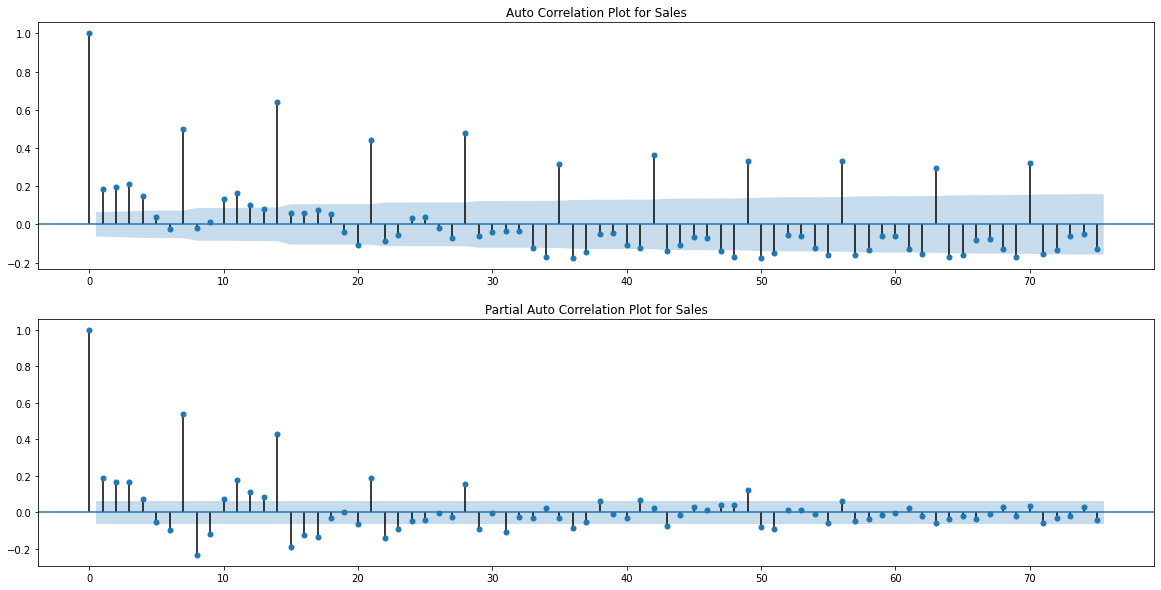

In [ ]:
correlationlPlot('Sales',store_46['Sales'])

**Insights:**


    Store 1 : p = 7
              q = 0
              d = 0
              
              
    Reason :  
              p's --> possibility is 7,14,21,28,35,49,56,.., but seeing the Data has a weekly Pattern and 7 Being Highly  
                      Partial Corelated with the Data series we opt for 7.
              d --> is 0 , As data is staionary and there is no requirement of Differencing.
              q --> is 0 , As the autocorrelation never dies down.

#### Train Test Split

In [ ]:
train_len = len(store_46)-42
store_46_train=store_46.iloc[:train_len,:]
store_46_test=store_46.iloc[train_len:,:]

In [ ]:
print('- Train and Test Data Shape of Store 46 :', store_46_train.shape ,'and' ,store_46_test.shape)

- Train and Test Data Shape of Store 46 : (900, 9) and (42, 9)


#### Standardization

In [ ]:
# Standarizing the Columns
store_46_train[["Sales", "Customers"]] = mms.fit_transform(store_46_train[["Sales", "Customers"]])
store_46_test[['Sales','Customers']] = mms.transform(store_46_test[['Sales','Customers']])

#### ARIMA

In [ ]:
# ARIMA
store_46_test=arimaFunction(store_46_train,store_46_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                  81.801
Method:                       css-mle   S.D. of innovations              0.221
Date:                Sun, 06 Mar 2022   AIC                           -145.603
Time:                        06:43:17   BIC                           -102.381
Sample:                    01-01-2013   HQIC                          -129.092
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4328      0.026     16.568      0.000       0.382       0.484
ar.L1.Sales     0.1668      0.028      5.927      0.000       0.112       0.222
ar.L2.Sales     0.1737      0.028      6.162    

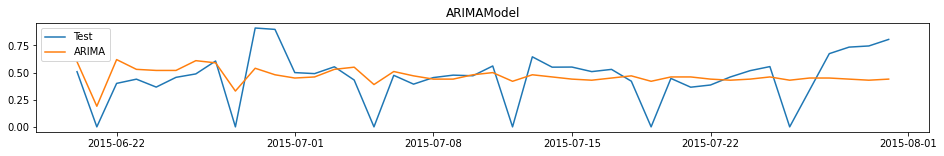

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_46_test,'ARIMA')

In [ ]:
results=scoringMetric(store_46_test,'ARIMA',46,results)
results[results['Store']==46]

Time Series Model Store  MAPE  SMAPE  RMSE
42             ARIMA    46  17.7  47.22   0.2

#### ARIMAX

In [ ]:
# ARIMAX
store_46_test=arimaxFunction(store_46_train,store_46_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                1523.638
Method:                       css-mle   S.D. of innovations              0.044
Date:                Sun, 06 Mar 2022   AIC                          -3013.276
Time:                        06:43:25   BIC                          -2931.635
Sample:                    01-01-2013   HQIC                         -2982.089
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0264      0.015     -1.712      0.087      -0.057       0.004
Customers       0.9172      0.010     90.518      0.000       0.897       0.937
Promo           0.0698      0.004     17.486    

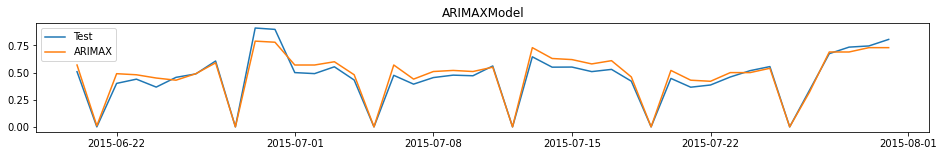

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_46_test,'ARIMAX')

In [ ]:
results = scoringMetric(store_46_test,'ARIMAX',46,results)
results[results['Store'] == 46]

Time Series Model Store   MAPE  SMAPE  RMSE
42             ARIMA    46  17.70  47.22  0.20
43            ARIMAX    46  10.18  15.10  0.06

#### SARIMA

In [ ]:
# SARIMA
store_46_test = sarimaFunction(store_46_train, store_46_test, (7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                  90.838
Date:                            Sun, 06 Mar 2022   AIC                           -151.677
Time:                                    06:46:01   BIC                            -79.641
Sample:                                01-01-2013   HQIC                          -124.159
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2893      0.027     10.554      0.000       0.236       0.343
ar.L2          0.2395      0.037   

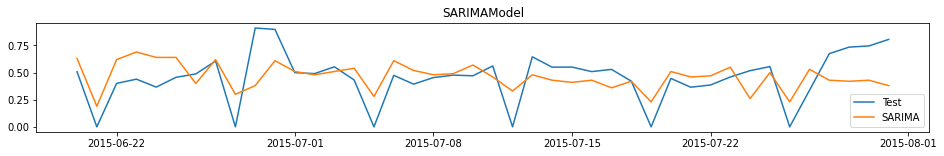

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_46_test,'SARIMA')

In [ ]:
results = scoringMetric(store_46_test,'SARIMA',46,results)
results[results['Store'] == 46]

Time Series Model Store   MAPE  SMAPE  RMSE
42             ARIMA    46  17.70  47.22  0.20
43            ARIMAX    46  10.18  15.10  0.06
44            SARIMA    46  23.81  53.12  0.21

#### SARIMAX

In [ ]:
# SARIMAX
store_46_test = sarimaxFunction(store_46_train,store_46_test,(7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                1526.289
Date:                            Sun, 06 Mar 2022   AIC                          -3006.579
Time:                                    06:57:15   BIC                          -2896.124
Sample:                                01-01-2013   HQIC                         -2964.384
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Customers       0.9136      0.008    116.794      0.000       0.898       0.929
Promo           0.0704      0.00

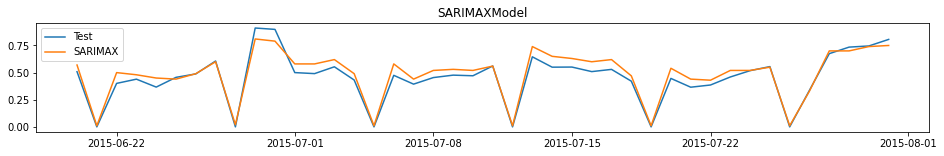

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_46_test,'SARIMAX')

In [ ]:
results = scoringMetric(store_46_test,'SARIMAX',46,results)
results[results['Store'] == 46]

Time Series Model Store   MAPE  SMAPE  RMSE
42             ARIMA    46  17.70  47.22  0.20
43            ARIMAX    46  10.18  15.10  0.06
44            SARIMA    46  23.81  53.12  0.21
45           SARIMAX    46   9.68  37.64  0.06

#### Johanson Test for Multivariate Time Analysis 

In [ ]:
johanson_coint_test(coint_johansen(store_46[['Sales', 'Customers']],-1,0))  
coint_rank(store_46[['Sales', 'Customers']])

   max_eig_stat  trace_stat
0    327.996440  204.709954
1    123.286486  123.286486 

- Crtical Values: (90%,95%,99%) of max_eig_stat :
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

- Crtical Values: (90%,95%,99%) of trace_stat :
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

- Rank of the Dataset for Features Sales & Customers is 2. 
- w1 and w2 are unique that happens when both Features are statioanry & not cointegrated we can build a VAR/ VARMAX model as it is.


#### VAR

In [ ]:
# VAR
store_46_test = varFunction(store_46_train, store_46_test, 7)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -8.854      -8.767   0.0001428      -8.821
1       -9.393      -9.284   8.329e-05      -9.351
2       -9.510      -9.378   7.411e-05      -9.460
3       -9.603      -9.450   6.749e-05      -9.545
4       -9.615      -9.440   6.669e-05      -9.548
5       -9.620      -9.423   6.636e-05      -9.545
6       -9.634      -9.415   6.544e-05      -9.550
7       -9.788      -9.546   5.615e-05      -9.695
8       -9.797      -9.534   5.560e-05      -9.697
9       -9.806      -9.521   5.511e-05      -9.697
10      -9.836      -9.530   5.347e-05      -9.719
11      -9.859      -9.530   5.227e-05      -9.733
12      -9.884      -9.533   5.098e-05      -9.750
13      -9.885      -9.512   5.093e-05      -9.742
14      -10.05      -9.660   4.301e-05      -9.903
15      -10.08     -9.661*   4.203e-05     -9.918*
16      -10.08      -9.644   4.

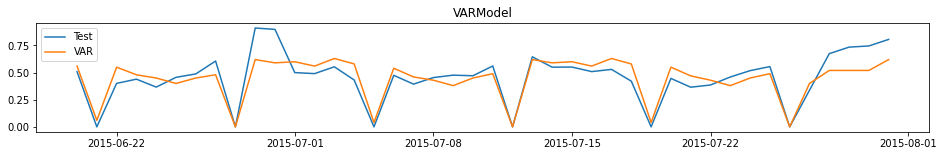

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_46_test, 'VAR')

In [ ]:
results = scoringMetric(store_46_test,'VAR', 46, results)
results[results['Store'] == 46]

Time Series Model Store   MAPE  SMAPE  RMSE
42             ARIMA    46  17.70  47.22  0.20
43            ARIMAX    46  10.18  15.10  0.06
44            SARIMA    46  23.81  53.12  0.21
45           SARIMAX    46   9.68  37.64  0.06
46               VAR    46  16.89  32.35  0.11

In [ ]:
# VARMAX
store_46_test = varmaxFunction(store_46_train,store_46_test,(7,0))

                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                1891.717
                              + intercept   AIC                          -3689.435
Date:                    Sun, 06 Mar 2022   BIC                          -3463.722
Time:                            07:00:41   HQIC                         -3603.211
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              436.66, 244.02   Jarque-Bera (JB):        854.43, 28.19
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.62, 1.18   Skew:                     -1.06, -0.13
P

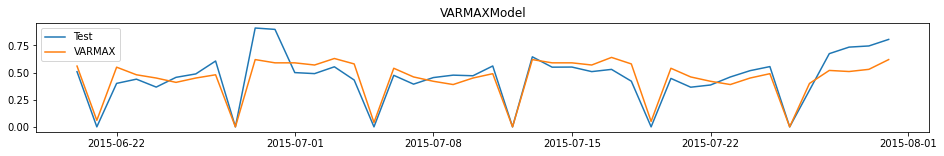

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_46_test,'VARMAX')

In [ ]:
results = scoringMetric(store_46_test, 'VARMAX', 46, results)
results[results['Store'] == 46]

Time Series Model Store   MAPE  SMAPE  RMSE
42             ARIMA    46  17.70  47.22  0.20
43            ARIMAX    46  10.18  15.10  0.06
44            SARIMA    46  23.81  53.12  0.21
45           SARIMAX    46   9.68  37.64  0.06
46               VAR    46  16.89  32.35  0.11
47            VARMAX    46  16.64  32.10  0.11

## Store - 13 : Analysis

In [ ]:
store_13 = dataset[dataset['Store'] == 13]
store_13.drop(columns=['Store'], inplace = True)
store_13.shape

(758, 4)

In [ ]:
# Lets Check the min and Max Date 
print('First and Last Dates of Store 13',store_13.index.min() ,'and' ,store_13.index.max())

First and Last Dates of Store 13 2013-01-01 00:00:00 and 2015-07-31 00:00:00


#### Checking Missing Dates due to Outlier Removal

In [ ]:
# checking Missing Dates due to Outlier Removal
pd.date_range(start = '2013-01-01', end = '2015-07-13').difference(store_13.index)

DatetimeIndex(['2014-07-01', '2014-07-02', '2014-07-03', '2014-07-04',
               '2014-07-05', '2014-07-06', '2014-07-07', '2014-07-08',
               '2014-07-09', '2014-07-10',
               ...
               '2014-12-22', '2014-12-23', '2014-12-24', '2014-12-25',
               '2014-12-26', '2014-12-27', '2014-12-28', '2014-12-29',
               '2014-12-30', '2014-12-31'],
              dtype='datetime64[ns]', length=184, freq=None)

In [ ]:
#Missing Dates Value Imputation
temp = pd.date_range(start = '2013-01-01', end = '2015-07-31' )
store_13_missing_values = store_13.reindex(temp, fill_value=np.nan)
store_13_missing_values.shape

(942, 4)

In [ ]:
#Linear Interpolation
store_13_missing_values = store_13_missing_values.assign(Sales_Linear_Interpolation=store_13_missing_values.Sales.interpolate(method='linear'))
store_13_missing_values = store_13_missing_values.assign(Customers_Linear_Interpolation= store_13_missing_values.Customers.interpolate(method='linear'))

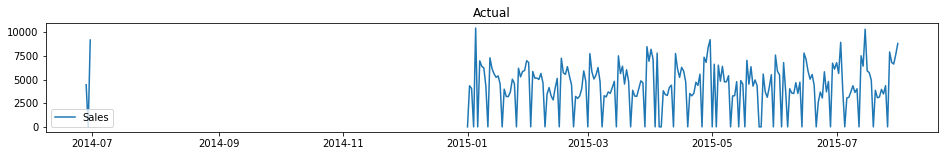

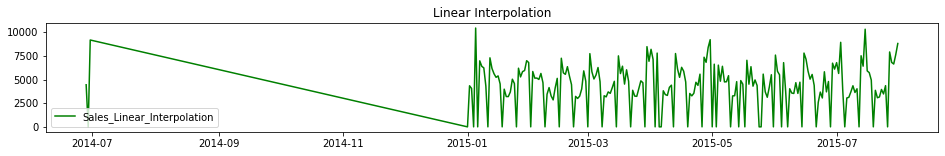

In [ ]:
# Missing Values fixed using INTERPOLATION Visualization
plt.figure(figsize=(16,2)) 
plt.plot(store_13_missing_values.loc['2014-06-28':]['Sales'], label='Sales')
plt.legend(loc='best')
plt.title('Actual')
plt.show()

plt.figure(figsize=(16,2)) 
plt.plot(store_13_missing_values.loc['2014-06-28':]['Sales_Linear_Interpolation'], label='Sales_Linear_Interpolation',color='green')
plt.legend(loc='best')
plt.title('Linear Interpolation')
plt.show()

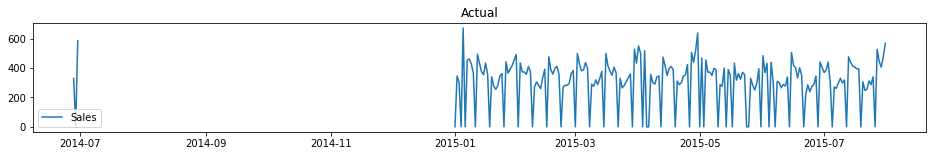

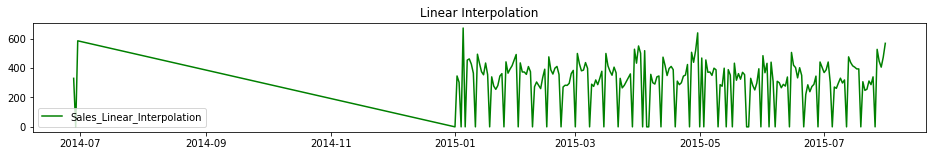

In [ ]:
# Missing Values fixed using INTERPOLATION Visualization
plt.figure(figsize=(16,2)) 
plt.plot(store_13_missing_values.loc['2014-06-28':]['Customers'], label='Sales')
plt.legend(loc='best')
plt.title('Actual')
plt.show()

plt.figure(figsize=(16,2)) 
plt.plot(store_13_missing_values.loc['2014-06-28':]['Customers_Linear_Interpolation'], label='Sales_Linear_Interpolation',color='green')
plt.legend(loc='best')
plt.title('Linear Interpolation')
plt.show()

#### Handle Missing Values for Promo

No handles with labels found to put in legend.


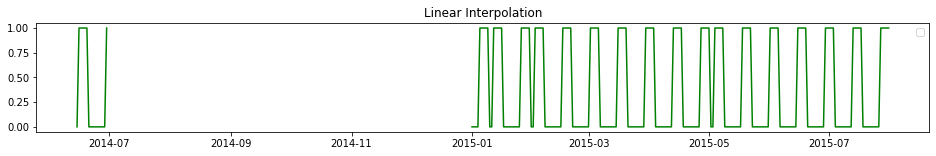

In [ ]:
plt.figure(figsize=(16,2)) 
plt.plot(store_13_missing_values.loc['2014-06-15':]['Promo'],color='green')
plt.legend(loc='best')
plt.title('Linear Interpolation')
plt.show()

In [ ]:
#custom Function to create Synthetic Data Point 
# create a list where the first 5 is One's then followed by 10 Zero's.
test_promo=[]
k=0
while k <= len([*range(0,170,15)]):
    for b in range(0,5):
        test_promo.append(1.0)
    if k < 12:
        for b in range(0,10):
            test_promo.append(0.0)
    k=k+1

In [ ]:
store_13_missing_values['2014-06-30':'2014-12-31']['Promo'] = test_promo

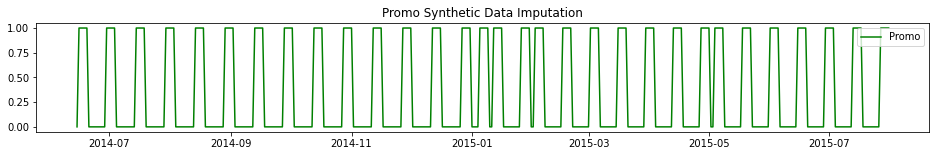

In [ ]:
# Missing Values fixed using Syntehtic Data Visualization
plt.figure(figsize=(16,2)) 
plt.plot(store_13_missing_values.loc['2014-06-15':]['Promo'],color='green',label='Promo')
plt.legend(loc='best')
plt.title('Promo Synthetic Data Imputation')
plt.show()

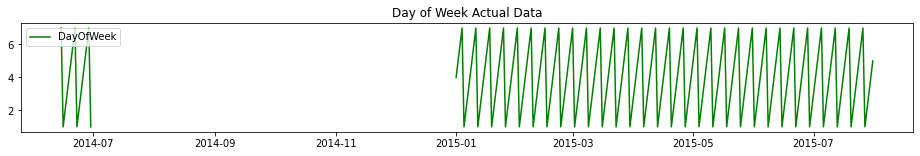

In [ ]:
# actual DayofWeek Data Visualization
plt.figure(figsize=(16,2)) 
plt.plot(store_13_missing_values.loc['2014-06-15':]['DayOfWeek'],color='green',label='DayOfWeek')
plt.legend(loc='best')
plt.title('Day of Week Actual Data')
plt.show()

In [ ]:
# Custom Function to create Synthetic Data Point for Day of Week
for i in store_13_missing_values.index:
    store_13_missing_values.at[i,"DayOfWeek"] = i.weekday() + 1

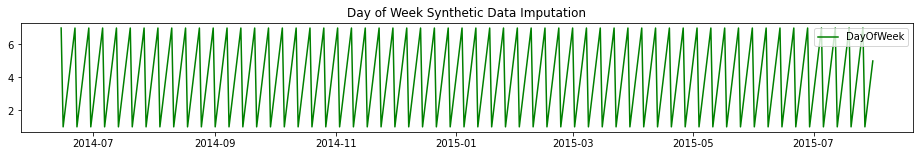

In [ ]:
# Missing Values fixed using Syntehtic Data Visualization for DayOfWeek
plt.figure(figsize=(16,2)) 
plt.plot(store_13_missing_values.loc['2014-06-15':]['DayOfWeek'],color='green',label='DayOfWeek')
plt.legend(loc='best')
plt.title('Day of Week Synthetic Data Imputation')
plt.show()

In [ ]:
# Droping Unnceccsary Columns
store_13_missing_values.drop(columns=['Sales', 'Customers'],inplace=True)

In [ ]:
# Store - 13 :  Data PostProcessing for Analysis and Training
store_13_missing_values.rename(columns={'Sales_Linear_Interpolation':'Sales',
       'Customers_Linear_Interpolation':'Customers'},inplace=True)

In [ ]:
# Making Sunday Sales 0 as Linear interpolation Could not fix the 6 months Data with 0 on sundays
store_13_missing_values['Sales'].loc[store_13_missing_values['DayOfWeek'] == 7.0] = 0
store_13_missing_values['Customers'].loc[store_13_missing_values['DayOfWeek'] == 7.0] = 0

No handles with labels found to put in legend.


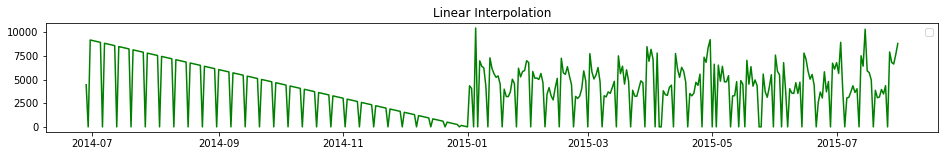

In [ ]:
# Missing Values fixed using Data Visualization
plt.figure(figsize=(16,2)) 
plt.plot(store_13_missing_values.loc['2014-06-28':]['Sales'],color='green')
plt.legend(loc='best')
plt.title('Linear Interpolation')
plt.show()

#### Outlier Detection and Fixation

In [ ]:
# Outlier Dectetion and Fixation
sales_threshold=store_13['Sales'].quantile(.99)
customers_threshold=store_13['Customers'].quantile(.99)
store_13_missing_values['sales_outlier']=np.where(store_13_missing_values['Sales']<=sales_threshold,0,1)
store_13_missing_values['customers_outlier']=np.where(store_13_missing_values['Customers']<=customers_threshold,0,1)

store_13_outlier=store_13_missing_values[(store_13_missing_values['sales_outlier'] != 1) & (store_13_missing_values['customers_outlier'] != 1) ]
store_13_outlier.shape

(932, 6)

In [ ]:
# Adding the Removed Dates to Impute them with Correct Values 
temp = pd.date_range(start = '2013-01-01', end = '2015-07-31')
store_13_outlier_missing_values = store_13_outlier.reindex(temp, fill_value=np.nan)
store_13_outlier_missing_values.shape

(942, 6)

In [ ]:
# Applying Linear Interopolation Again as the Data has now reduced
store_13_outlier_missing_values = store_13_outlier_missing_values.assign(Sales_Linear_Interpolation=store_13_outlier_missing_values.Sales.interpolate(method='linear'))
store_13_outlier_missing_values = store_13_outlier_missing_values.assign(Customers_Linear_Interpolation= store_13_outlier_missing_values.Customers.interpolate(method='linear'))
store_13_outlier_missing_values = store_13_outlier_missing_values.assign(Promo_Linear_Interpolation=store_13_outlier_missing_values.Promo.interpolate(method='linear'))
store_13_outlier_missing_values = store_13_outlier_missing_values.assign(DayOfWeek_Linear_Interpolation= store_13_outlier_missing_values.DayOfWeek.interpolate(method='linear'))

In [ ]:
# Droping Unnceccsary Columns
store_13_outlier_missing_values.drop(columns=['Sales', 'Customers','DayOfWeek','Promo','sales_outlier','customers_outlier'],inplace=True)

In [ ]:
# Store - 13 :  Data PostProcessing for Analysis and Training
store_13_outlier_missing_values.rename(columns={'Sales_Linear_Interpolation':'Sales',
                                                'Customers_Linear_Interpolation':'Customers',
                                                'Promo_Linear_Interpolation':'Promo',
                                                'DayOfWeek_Linear_Interpolation' :'DayOfWeek'},inplace=True)

In [ ]:
# Converting/TypeConversion of Dayof Week Columns
store_13_outlier_missing_values['DayOfWeek']=store_13_outlier_missing_values['DayOfWeek'].astype('int')

In [ ]:
#Saving the Treated Store data s Original Store Data for Predication and Training
store_13=store_13_outlier_missing_values.copy()

In [ ]:
# Creating Dummies for Day of Week Column
store_13=pd.get_dummies(store_13, columns=['DayOfWeek'],drop_first=True)

#### Time Series - Casuality Test

In [ ]:
causality_sales = grangercausalitytests(store_13[['Sales','Customers']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=148.2858, p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=148.7600, p=0.0000  , df=1
likelihood ratio test: chi2=138.1102, p=0.0000  , df=1
parameter F test:         F=148.2858, p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=70.0348 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=140.8186, p=0.0000  , df=2
likelihood ratio test: chi2=131.2185, p=0.0000  , df=2
parameter F test:         F=70.0348 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=54.3863 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=164.3845, p=0.0000  , df=3
likelihood ratio test: chi2=151.4814, p=0.0000  , df=3
parameter F test:         F=54.3863 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=50.6137 , p=0.0000  

In [ ]:
causality_customers = grangercausalitytests(store_13[['Customers','Sales']].dropna(), 4)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=82.8785 , p=0.0000  , df_denom=938, df_num=1
ssr based chi2 test:   chi2=83.1435 , p=0.0000  , df=1
likelihood ratio test: chi2=79.6734 , p=0.0000  , df=1
parameter F test:         F=82.8785 , p=0.0000  , df_denom=938, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=43.9921 , p=0.0000  , df_denom=935, df_num=2
ssr based chi2 test:   chi2=88.4547 , p=0.0000  , df=2
likelihood ratio test: chi2=84.5368 , p=0.0000  , df=2
parameter F test:         F=43.9921 , p=0.0000  , df_denom=935, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=37.0682 , p=0.0000  , df_denom=932, df_num=3
ssr based chi2 test:   chi2=112.0398, p=0.0000  , df=3
likelihood ratio test: chi2=105.8438, p=0.0000  , df=3
parameter F test:         F=37.0682 , p=0.0000  , df_denom=932, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=36.9385 , p=0.0000  

- Since all the tests signify causality at significance level 0.05, it means that causality exists between sales and customers.

#### Time Series - Tests to Check the Stationarity of Data 

In [ ]:
stationaryTest(store_13,13)

- ADF Test Results for "Sales" in Store 13 :
- ADF Statistic: -2.953816
- Critical Values @ 0.05: -2.86
- p-value: 0.039438
- ADF Test Suggests :Null Hypothesis (H0): The series is stationary




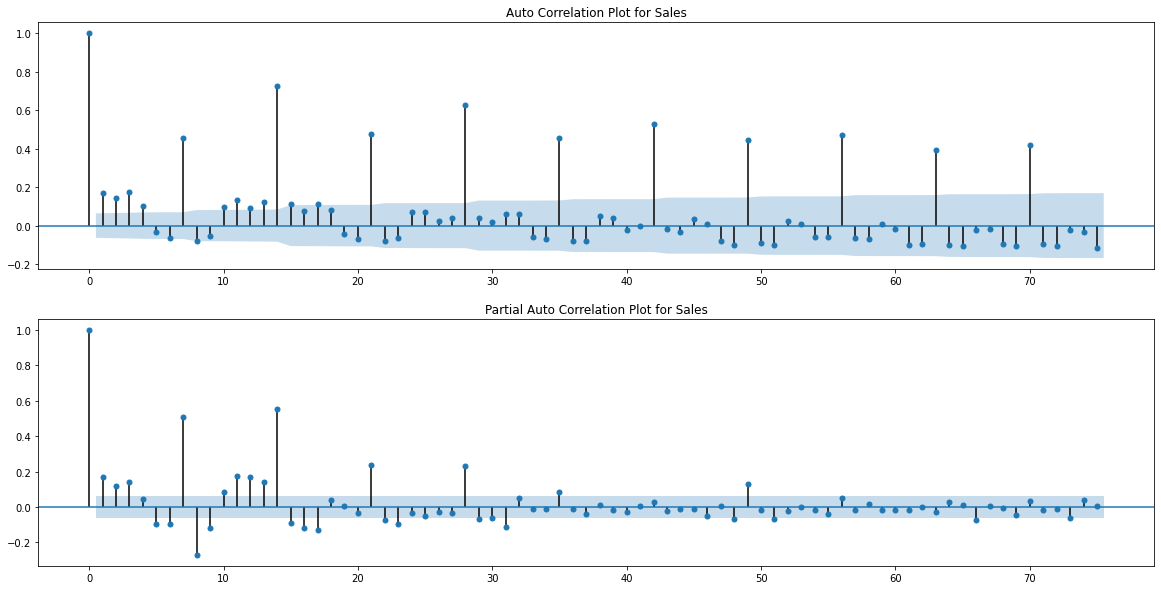

In [ ]:
correlationlPlot('Sales',store_13['Sales'])

**Insights:**


    Store 1 : p = 7
              q = 0
              d = 0
              
              
    Reason :  
              p's --> possibility is 7,14,21,28,35,49,56,.., but seeing the Data has a weekly Pattern and 7 Being Highly  
                      Partial Corelated with the Data series we opt for 7.
              d --> is 0 , As data is staionary and there is no requirement of Differencing.
              q --> is 0 , As the autocorrelation never dies down.

#### Train Test Split

In [ ]:
train_len = len(store_13)-42
store_13_train=store_13.iloc[:train_len,:]
store_13_test=store_13.iloc[train_len:,:]

In [ ]:
print('- Train and Test Data Shape of Store 13 :', store_13_train.shape ,'and' ,store_13_test.shape)

- Train and Test Data Shape of Store 13 : (900, 9) and (42, 9)


#### Standardization

In [ ]:
# Standarizing the Columns
store_13_train[["Sales", "Customers"]] = mms.fit_transform(store_13_train[["Sales", "Customers"]])
store_13_test[['Sales','Customers']] = mms.transform(store_13_test[['Sales','Customers']])

#### ARIMA

In [ ]:
###ARIMA
store_13_test=arimaFunction(store_13_train,store_13_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                  73.258
Method:                       css-mle   S.D. of innovations              0.223
Date:                Sun, 06 Mar 2022   AIC                           -128.516
Time:                        07:00:45   BIC                            -85.295
Sample:                    01-01-2013   HQIC                          -112.005
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.4398      0.022     20.393      0.000       0.397       0.482
ar.L1.Sales     0.1662      0.029      5.822      0.000       0.110       0.222
ar.L2.Sales     0.1491      0.029      5.211    

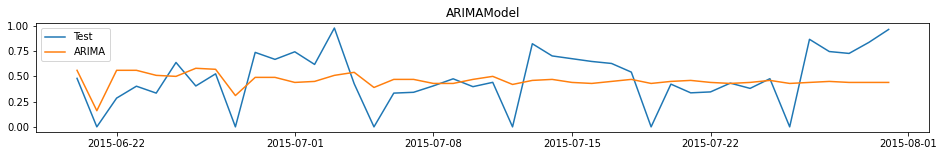

In [ ]:
# Ploting Data for Last 6 Weeks  
plot(store_13_test,'ARIMA')

In [ ]:
results=scoringMetric(store_13_test,'ARIMA',13,results)
results[results['Store']==13]

Time Series Model Store  MAPE  SMAPE  RMSE
48             ARIMA    13  26.5  56.66  0.25

#### ARIMAX

In [ ]:
###ARIMAX
store_13_test=arimaxFunction(store_13_train,store_13_test,(7,0,0))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  900
Model:                     ARMA(7, 0)   Log Likelihood                1623.371
Method:                       css-mle   S.D. of innovations              0.040
Date:                Sun, 06 Mar 2022   AIC                          -3212.742
Time:                        07:00:54   BIC                          -3131.101
Sample:                    01-01-2013   HQIC                         -3181.554
                         - 06-19-2015                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0373      0.012     -3.228      0.001      -0.060      -0.015
Customers       0.9671      0.010    101.369      0.000       0.948       0.986
Promo           0.0524      0.003     15.292    

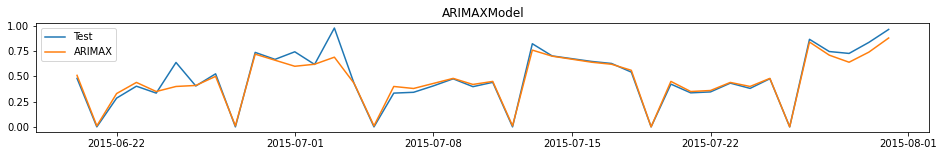

In [ ]:
# Ploting Data for Last 6 Weeks 
plot(store_13_test,'ARIMAX')

In [ ]:
results=scoringMetric(store_13_test,'ARIMAX',13,results)
results[results['Store']==13]

Time Series Model Store   MAPE  SMAPE  RMSE
48             ARIMA    13  26.50  56.66  0.25
49            ARIMAX    13   6.35  26.68  0.07

#### SARIMA

In [ ]:
# SARIMA
store_13_test=sarimaFunction(store_13_train,store_13_test,(7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                  92.531
Date:                            Sun, 06 Mar 2022   AIC                           -155.062
Time:                                    07:03:24   BIC                            -83.026
Sample:                                01-01-2013   HQIC                          -127.544
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3187      0.029     10.972      0.000       0.262       0.376
ar.L2          0.2029      0.039   

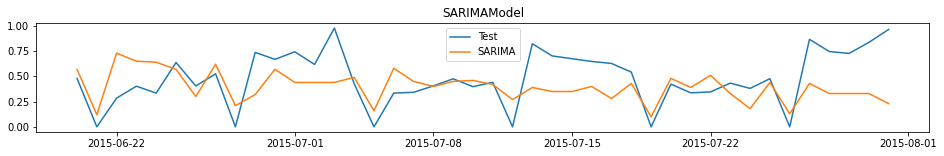

In [ ]:
# Ploting Data for Last 6 Weeks 
plot(store_13_test,'SARIMA')

In [ ]:
results=scoringMetric(store_13_test,'SARIMA',13,results)
results[results['Store']==13]

Time Series Model Store   MAPE  SMAPE  RMSE
48             ARIMA    13  26.50  56.66  0.25
49            ARIMAX    13   6.35  26.68  0.07
50            SARIMA    13  34.50  66.66  0.28

#### SARIMAX

In [ ]:
# SARIMAX
store_13_test=sarimaxFunction(store_13_train,store_13_test,(7,0,0),(7,0,0,12))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                  900
Model:             SARIMAX(7, 0, 0)x(7, 0, 0, 12)   Log Likelihood                1625.302
Date:                            Sun, 06 Mar 2022   AIC                          -3204.605
Time:                                    07:14:21   BIC                          -3094.150
Sample:                                01-01-2013   HQIC                         -3162.410
                                     - 06-19-2015                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Customers       0.9572      0.007    130.747      0.000       0.943       0.972
Promo           0.0541      0.00

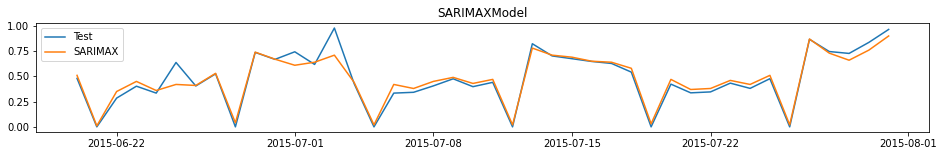

In [ ]:
# Ploting Data for Last 6 Weeks 
plot(store_13_test,'SARIMAX')

In [ ]:
results=scoringMetric(store_13_test,'SARIMAX',13,results)
results[results['Store']==13]

Time Series Model Store   MAPE  SMAPE  RMSE
48             ARIMA    13  26.50  56.66  0.25
49            ARIMAX    13   6.35  26.68  0.07
50            SARIMA    13  34.50  66.66  0.28
51           SARIMAX    13   7.19  35.85  0.07

In [ ]:
johanson_coint_test(coint_johansen(store_13[['Sales', 'Customers']],-1,0))  
coint_rank(store_13[['Sales', 'Customers']])

   max_eig_stat  trace_stat
0    363.122011  244.954403
1    118.167608  118.167608 

- Crtical Values: (90%,95%,99%) of max_eig_stat :
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

- Crtical Values: (90%,95%,99%) of trace_stat :
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

- Rank of the Dataset for Features Sales & Customers is 2. 
- w1 and w2 are unique that happens when both Features are statioanry & not cointegrated we can build a VAR/ VARMAX model as it is.


#### Johanson Test for Multivariate Time Analysis

In [ ]:
johanson_coint_test(coint_johansen(store_13[['Sales', 'Customers']],-1,0))  
coint_rank(store_13[['Sales', 'Customers']])

   max_eig_stat  trace_stat
0    363.122011  244.954403
1    118.167608  118.167608 

- Crtical Values: (90%,95%,99%) of max_eig_stat :
 [[ 9.4748 11.2246 15.0923]
 [ 2.9762  4.1296  6.9406]] 

- Crtical Values: (90%,95%,99%) of trace_stat :
 [[10.4741 12.3212 16.364 ]
 [ 2.9762  4.1296  6.9406]] 

- Rank of the Dataset for Features Sales & Customers is 2. 
- w1 and w2 are unique that happens when both Features are statioanry & not cointegrated we can build a VAR/ VARMAX model as it is.


#### VAR

In [ ]:
# VAR
store_13_test = varFunction(store_13_train, store_13_test, 7)

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -9.238      -9.150   9.726e-05      -9.205
1       -9.691      -9.582   6.182e-05      -9.649
2       -9.841      -9.710   5.320e-05      -9.791
3       -9.957      -9.804   4.738e-05      -9.899
4       -9.968      -9.793   4.688e-05      -9.901
5       -9.992      -9.795   4.577e-05      -9.916
6       -10.02      -9.796   4.472e-05      -9.931
7       -10.11      -9.873   4.049e-05      -10.02
8       -10.13      -9.865   3.995e-05      -10.03
9       -10.15      -9.867   3.899e-05      -10.04
10      -10.21      -9.900   3.693e-05      -10.09
11      -10.24      -9.911   3.571e-05      -10.11
12      -10.26      -9.911   3.495e-05      -10.13
13      -10.27      -9.900   3.456e-05      -10.13
14      -10.35     -9.959*   3.187e-05      -10.20
15      -10.37      -9.956   3.129e-05     -10.21*
16      -10.37      -9.936   3.

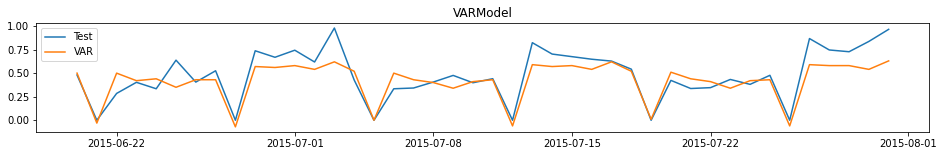

In [ ]:
# Ploting Data for Last 6 Weeks 
plot(store_13_test,'VAR')

In [ ]:
results = scoringMetric(store_13_test, 'VAR', 13, results)
results[results['Store'] == 13]

Time Series Model Store   MAPE  SMAPE  RMSE
48             ARIMA    13  26.50  56.66  0.25
49            ARIMAX    13   6.35  26.68  0.07
50            SARIMA    13  34.50  66.66  0.28
51           SARIMAX    13   7.19  35.85  0.07
52               VAR    13  18.70  43.72  0.14

#### VARMAX

In [ ]:
# VARMAX
store_13_test = varmaxFunction(store_13_train, store_13_test,(7,0))

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             Statespace Model Results                             
Dep. Variable:     ['Sales', 'Customers']   No. Observations:                  900
Model:                            VARX(7)   Log Likelihood                2046.377
                              + intercept   AIC                          -3998.754
Date:                    Sun, 06 Mar 2022   BIC                          -3773.041
Time:                            07:18:06   HQIC                         -3912.530
Sample:                        01-01-2013                                         
                             - 06-19-2015                                         
Covariance Type:                      opg                                         
Ljung-Box (Q):              201.05, 139.36   Jarque-Bera (JB):        729.66, 39.09
Prob(Q):                        0.00, 0.00   Prob(JB):                   0.00, 0.00
Heteroskedasticity (H):         1.26, 1.10   Skew:                     -1.04, -0.24
P

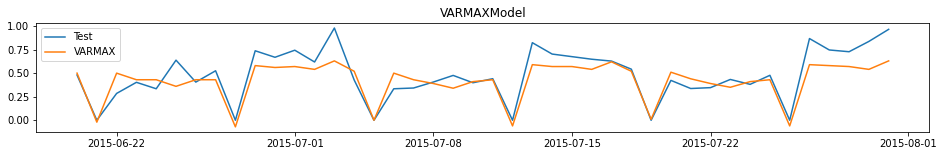

In [ ]:
# Ploting Data for Last 6 Weeks 
plot(store_13_test, 'VARMAX')

In [ ]:
results = scoringMetric(store_13_test,'VARMAX',13,results)
results[results['Store'] == 13]

Time Series Model Store   MAPE  SMAPE  RMSE
48             ARIMA    13  26.50  56.66  0.25
49            ARIMAX    13   6.35  26.68  0.07
50            SARIMA    13  34.50  66.66  0.28
51           SARIMAX    13   7.19  35.85  0.07
52               VAR    13  18.70  43.72  0.14
53            VARMAX    13  18.49  43.52  0.14

## Model Selection and Evaluation

- After building Models for all Stores, we'll create a DataFrame with with MAPE value of models.
- We'll select model with minimum MAPE value for each store & apply green color as an indicator.

In [ ]:
MAPE_result = pd.DataFrame({
                            'Model': ['ARIMA', 'ARIMAX', 'SARIMA', 'SARIMAX', 'VAR', 'VARMAX']
                            })
MAPE_result = MAPE_result.set_index('Model')

for store in results['Store'].unique():
  MAPE_result[f'Store-{store}'] = np.array(results[results['Store'] == store]['MAPE'])
MAPE_result.style.highlight_min(color = 'lightgreen', axis = 0)